## Imports Used

In [ ]:
# Data Handling
import pandas as pd
import numpy as np
import datetime

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

# Data Retrieval
import yfinance as yf

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Machine Learning Models and Tools
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from scipy.stats import uniform, randint

# Neural Networks (Keras and TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Neural Networks (PyTorch)
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader


## Helper Functions

In [ ]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [ ]:
import numpy as np

def df_to_windowed_df(dataframe, first_date_str, last_date_str, ticker, n=3):
  first_date = str_to_datetime(first_date_str)
  last_date  = str_to_datetime(last_date_str)

  target_date = first_date

  dates = []
  X, Y = [], []

  last_time = False
  while True:
    df_subset = dataframe.loc[:target_date].tail(n+1)

    if len(df_subset) != n+1:
      print(f'Error: Window of size {n} is too large for date {target_date}')
      return

    values = df_subset['Close_' + ticker].to_numpy()
    x, y = values[:-1], values[-1]

    dates.append(target_date)
    X.append(x)
    Y.append(y)

    next_week = dataframe.loc[target_date:target_date+datetime.timedelta(days=7)]
    next_datetime_str = str(next_week.head(2).tail(1).index.values[0])
    next_date_str = next_datetime_str.split('T')[0]
    year_month_day = next_date_str.split('-')
    year, month, day = year_month_day
    next_date = datetime.datetime(day=int(day), month=int(month), year=int(year))

    if last_time:
      break

    target_date = next_date

    if target_date == last_date:
      last_time = True

  ret_df = pd.DataFrame({})
  ret_df['Target Date'] = dates

  X = np.array(X)
  for i in range(0, n):
    X[:, i]
    ret_df[f'Target-{n-i}'] = X[:, i]

  ret_df['Target'] = Y

  return ret_df


In [ ]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)


In [ ]:
import matplotlib.pyplot as plt

def split_and_plot_data(dates, X, y, ticker, train_size=0.8, val_size=0.1):
    # Determine the split indices
    q_train = int(len(dates) * train_size)
    q_val = int(len(dates) * (train_size + val_size))

    # Split the data into dictionaries
    train_data = {'dates': dates[:q_train], 'X': X[:q_train], 'y': y[:q_train]}
    val_data = {'dates': dates[q_train:q_val], 'X': X[q_train:q_val], 'y': y[q_train:q_val]}
    test_data = {'dates': dates[q_val:], 'X': X[q_val:], 'y': y[q_val:]}

    # Plot the data
    plt.plot(train_data['dates'], train_data['y'])
    plt.plot(val_data['dates'], val_data['y'])
    plt.plot(test_data['dates'], test_data['y'])

    # Add legend and labels
    plt.legend(['Train', 'Validation', 'Test'])
    plt.xlabel('Date')
    plt.ylabel('Target')
    plt.title(f'{ticker}: Train, Validation, and Test Data Splits')
    plt.xticks(rotation=45)
    plt.show()

    # Return the data as a tuple of dictionaries
    return (train_data, val_data, test_data)


In [ ]:
def calculate_mae(array1, array2):
    if array1.shape != array2.shape:
        raise ValueError("Both arrays must have the same shape.")
    return np.mean(np.abs(array1 - array2))

## Data Collection

In [ ]:
# Define Tickers of Interest
tickers = {'technology': ['NVDA', 'GOOG'],
           'healthcare': ['LLY', 'ABBV', 'MRK'],
           'construction': ['TT', 'CRH', 'URI'],
           'food': ['ADM', 'KHC', 'GIS']}

In [ ]:
# Create Dataset
ticker_set = 'healthcare' # set group of tickers
start_date = '2000-01-01' # set start date
end_date = '2020-01-01' # set end date

use_single = False # True if only want to look at 1 stock
single_index = 0 # choose the 1 stock here

if use_single:
  symbol = tickers[ticker_set][single_index]
  stock = yf.Ticker(symbol)
  data = stock.history(start=start_date, end=end_date)
  description = 'Stock ' + symbol + ' From ' + start_date + ' to ' + end_date
  print(description)
else:S
  data_1_list = []
  for symbol in tickers[ticker_set]:
    stock = yf.Ticker(symbol)
    data_1 = stock.history(start=start_date, end=end_date)
    data_1_columns = data_1.columns
    def add_prefix(text):
      return symbol + '-' + text
    data_1 = data_1.rename(add_prefix, axis='columns')
    data_1_list.append(data_1)
  data = pd.concat(data_1_list)
  description = ticker_set + ' Stocks From ' + start_date + ' to ' + end_date
data.head()
# data = dataframe containing data
# (NOTE!! - There is no column for Date, The date is the index)
# Note: IF Stock data is not available for a certain date, it will return NaN

LLY-Open   LLY-High    LLY-Low  LLY-Close  \
Date                                                                    
2000-01-03 00:00:00-05:00  32.571702  33.793141  32.571702  32.853573   
2000-01-04 00:00:00-05:00  32.195871  32.790931  31.444216  31.820044   
2000-01-05 00:00:00-05:00  31.632132  32.728295  31.569494  32.227192   
2000-01-06 00:00:00-05:00  32.571696  33.166756  32.227188  33.166756   
2000-01-07 00:00:00-05:00  34.075014  35.609642  33.824462  35.609642   

                           LLY-Volume  LLY-Dividends  LLY-Stock Splits  \
Date                                                                     
2000-01-03 00:00:00-05:00   2645000.0            0.0               0.0   
2000-01-04 00:00:00-05:00   3701000.0            0.0               0.0   
2000-01-05 00:00:00-05:00   3411000.0            0.0               0.0   
2000-01-06 00:00:00-05:00   2460100.0            0.0               0.0   
2000-01-07 00:00:00-05:00   5863300.0            0.0               0.0   

                           ABBV-Open  ABBV-High  ABBV-Low  ...  ABBV-Volume  \
Date                                                       ...                
2000-01-03 00:00:00-05:00        NaN        NaN       NaN  ...          NaN   
2000-01-04 00:00:00-05:00        NaN        NaN       NaN  ...          NaN   
2000-01-05 00:00:00-05:00        NaN        NaN       NaN  ...          NaN   
2000-01-06 00:00:00-05:00        NaN        NaN       NaN  ...          NaN   
2000-01-07 00:00:00-05:00        NaN        NaN       NaN  ...          NaN   

                           ABBV-Dividends  ABBV-Stock Splits  MRK-Open  \
Date                                                                     
2000-01-03 00:00:00-05:00             NaN                NaN       NaN   
2000-01-04 00:00:00-05:00             NaN                NaN       NaN   
2000-01-05 00:00:00-05:00             NaN                NaN       NaN   
2000-01-06 00:00:00-05:00             NaN                NaN       NaN   
2000-01-07 00:00:00-05:00             NaN                NaN       NaN   

                           MRK-High  MRK-Low  MRK-Close  MRK-Volume  \
Date                                                                  
2000-01-03 00:00:00-05:00       NaN      NaN        NaN         NaN   
2000-01-04 00:00:00-05:00       NaN      NaN        NaN         NaN   
2000-01-05 00:00:00-05:00       NaN      NaN        NaN         NaN   
2000-01-06 00:00:00-05:00       NaN      NaN        NaN         NaN   
2000-01-07 00:00:00-05:00       NaN      NaN        NaN         NaN   

                           MRK-Dividends  MRK-Stock Splits  
Date                                                        
2000-01-03 00:00:00-05:00            NaN               NaN  
2000-01-04 00:00:00-05:00            NaN               NaN  
2000-01-05 00:00:00-05:00            NaN               NaN  
2000-01-06 00:00:00-05:00            NaN               NaN  
2000-01-07 00:00:00-05:00            NaN               NaN  

[5 rows x 21 columns]

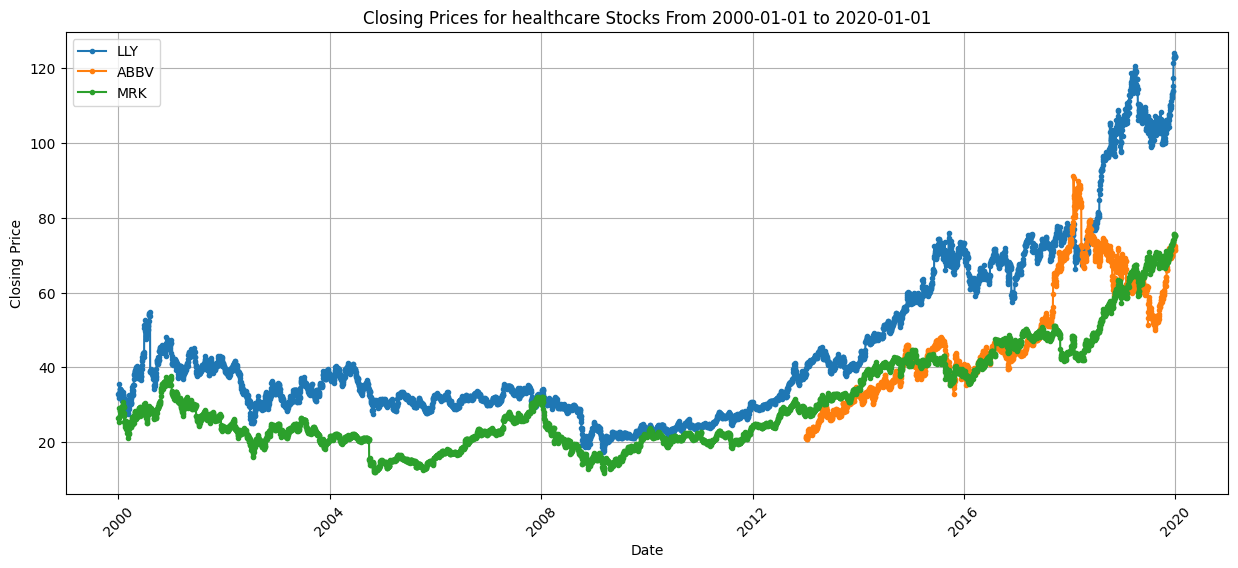

In [ ]:
# Visualize Dataset
plt.figure(figsize=(15, 6))
if use_single:
  plt.plot(data.index, data[tickers[ticker_set][single_index] + '-Close'], marker='.', label=ticker)
else:
  for ticker in tickers[ticker_set]:
    plt.plot(data.index, data[ticker + '-Close'], marker='.', label=ticker)
plt.title('Closing Prices for ' + description)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Define Tickers of Interest
tickers = {'technology': ['NVDA', 'GOOG'],
           'healthcare': ['LLY', 'ABBV', 'MRK'],
           'construction': ['TT', 'CRH', 'URI'],
           'food': ['ADM', 'KHC', 'GIS']}
selected_ticker_set = 'construction'  # Choose industry
start_date = '2015-01-01'
end_date = '2020-01-01'

use_single = True  # Set to False for multiple stocks
single_index = 1 # Index of the stock to analyze (if single)

In [ ]:

if use_single:
    symbol = tickers[selected_ticker_set][single_index]
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data = stock_data[['Close']].dropna()
    description = f"Stock {symbol} from {start_date} to {end_date}"
else:
    stock_data_list = []
    for symbol in tickers[selected_ticker_set]:
        stock = yf.Ticker(symbol)
        data = stock.history(start=start_date, end=end_date)
        data = data[['Close']].dropna().rename(columns={'Close': f"{symbol}-Close"})
        stock_data_list.append(data)
    stock_data = pd.concat(stock_data_list, axis=1)
    description = f"{selected_ticker_set} Stocks from {start_date} to {end_date}"


[*********************100%***********************]  1 of 1 completed


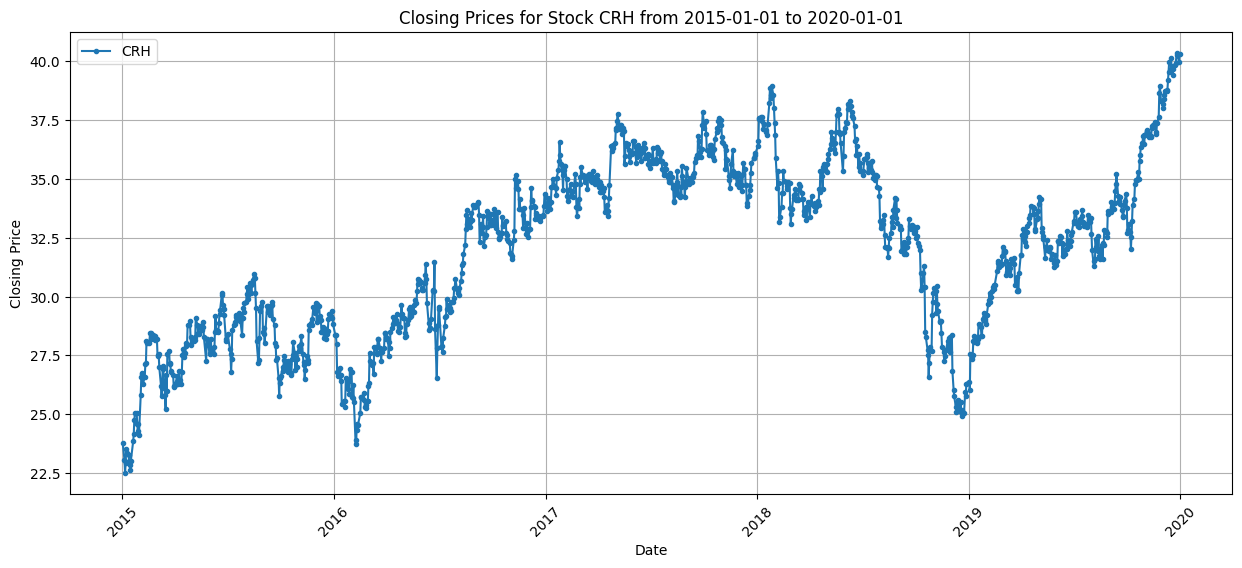

In [ ]:
# Step 3: Visualize Dataset
plt.figure(figsize=(15, 6))
if use_single:
    plt.plot(stock_data.index, stock_data['Close'], marker='.', label=symbol)
else:
    for col in stock_data.columns:
        plt.plot(stock_data.index, stock_data[col], marker='.', label=col.split('-')[0])
plt.title(f"Closing Prices for {description}")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# Define Tickers of Interest
tickers = {'technology': ['NVDA', 'GOOG'],
           'healthcare': ['LLY', 'ABBV', 'MRK'],
           'construction': ['TT', 'CRH', 'URI'],
           'food': ['ADM', 'KHC', 'GIS']}
selected_ticker_set = 'construction'  # Choose industry
start_date = '2015-01-01'
end_date = '2020-01-01'

use_single = True  # Set to False for multiple stocks
single_index = 1 # Index of the stock to analyze (if single)

In [ ]:

if use_single:
    symbol = tickers[selected_ticker_set][single_index]
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data = stock_data[['Close']].dropna()
    description = f"Stock {symbol} from {start_date} to {end_date}"
else:
    stock_data_list = []
    for symbol in tickers[selected_ticker_set]:
        stock = yf.Ticker(symbol)
        data = stock.history(start=start_date, end=end_date)
        data = data[['Close']].dropna().rename(columns={'Close': f"{symbol}-Close"})
        stock_data_list.append(data)
    stock_data = pd.concat(stock_data_list, axis=1)
    description = f"{selected_ticker_set} Stocks from {start_date} to {end_date}"


[*********************100%***********************]  1 of 1 completed


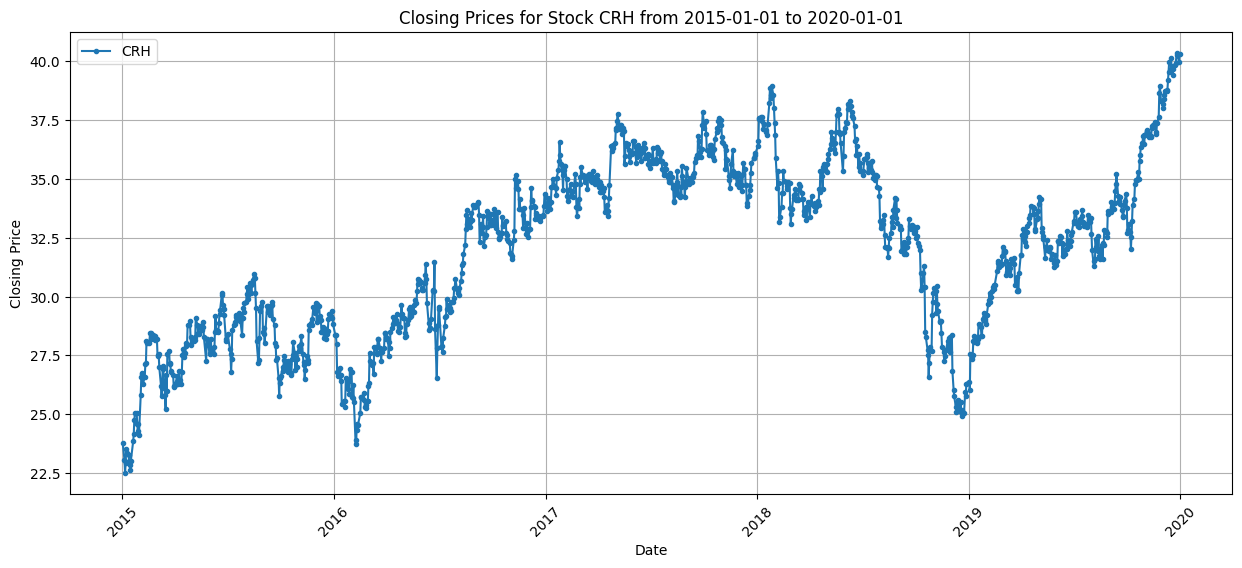

In [ ]:
# Step 3: Visualize Dataset
plt.figure(figsize=(15, 6))
if use_single:
    plt.plot(stock_data.index, stock_data['Close'], marker='.', label=symbol)
else:
    for col in stock_data.columns:
        plt.plot(stock_data.index, stock_data[col], marker='.', label=col.split('-')[0])
plt.title(f"Closing Prices for {description}")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
# downloading stock data

stock_name = "AAPL"
# YYYY-MM-DD
start_date = "2000-01-01"
end_date = "2020-01-01"

data = yf.download(stock_name, start=start_date, end=end_date)
print()
print(data.head())

[*********************100%***********************]  1 of 1 completed


Price      Adj Close     Close      High       Low      Open     Volume
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL
Date                                                                   
2000-01-03  0.843077  0.999442  1.004464  0.907924  0.936384  535796800
2000-01-04  0.771997  0.915179  0.987723  0.903460  0.966518  512377600
2000-01-05  0.783294  0.928571  0.987165  0.919643  0.926339  778321600
2000-01-06  0.715508  0.848214  0.955357  0.848214  0.947545  767972800
2000-01-07  0.749401  0.888393  0.901786  0.852679  0.861607  460734400


In [ ]:
print(len(data))

5031


In [ ]:
# check for any columns with missingg or empty data entries
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(data)

Price       Adj Close      Close       High        Low       Open      Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL        AAPL
Date                                                                         
2000-01-03   0.843077   0.999442   1.004464   0.907924   0.936384   535796800
2000-01-04   0.771997   0.915179   0.987723   0.903460   0.966518   512377600
2000-01-05   0.783294   0.928571   0.987165   0.919643   0.926339   778321600
2000-01-06   0.715508   0.848214   0.955357   0.848214   0.947545   767972800
2000-01-07   0.749401   0.888393   0.901786   0.852679   0.861607   460734400
2000-01-10   0.736221   0.872768   0.912946   0.845982   0.910714   505064000
2000-01-11   0.698562   0.828125   0.887277   0.808036   0.856585   441548800
2000-01-12   0.656668   0.778460   0.852679   0.772321   0.848214   976068800
2000-01-13   0.728689   0.863839   0.881696   0.825893   0.843610  1032684800
2000-01-14   0.756462   0.896763   0.912946   0.887277   0.89285

In [ ]:
print(data)

Price       Adj Close      Close       High        Low       Open     Volume
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL
Date                                                                        
2000-01-03   0.843077   0.999442   1.004464   0.907924   0.936384  535796800
2000-01-04   0.771997   0.915179   0.987723   0.903460   0.966518  512377600
2000-01-05   0.783294   0.928571   0.987165   0.919643   0.926339  778321600
2000-01-06   0.715508   0.848214   0.955357   0.848214   0.947545  767972800
2000-01-07   0.749401   0.888393   0.901786   0.852679   0.861607  460734400
...               ...        ...        ...        ...        ...        ...
2019-12-24  68.898689  71.067497  71.222504  70.730003  71.172501   48478800
2019-12-26  70.265671  72.477501  72.495003  71.175003  71.205002   93121200
2019-12-27  70.238998  72.449997  73.492500  72.029999  72.779999  146266000
2019-12-30  70.655891  72.879997  73.172501  71.305000  72.364998  144114400

In [ ]:
data.shape

(5031, 6)

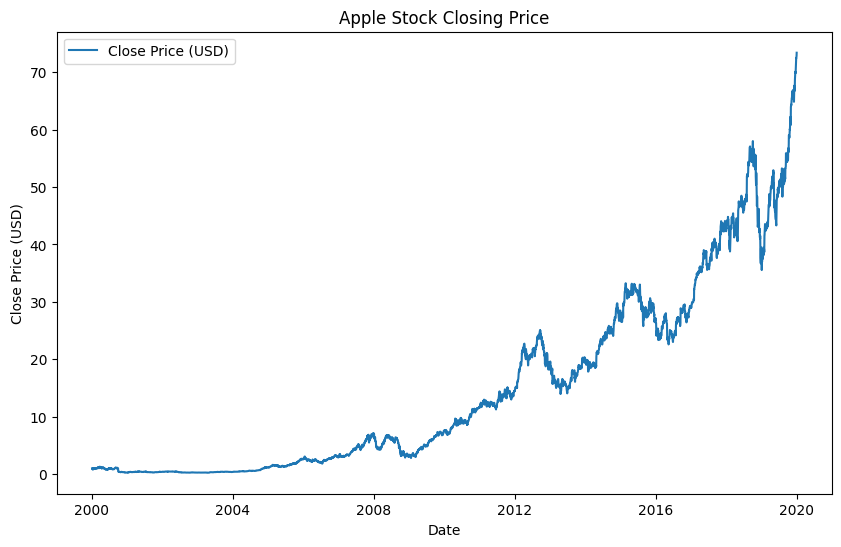

In [ ]:
# visualize data we loaded in
# plot closing price
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price (USD)')
plt.title('Apple Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

In [ ]:
# Define Tickers of Interest
tickers = {'technology': ['NVDA', 'GOOG'],
           'healthcare': ['LLY', 'ABBV', 'MRK'],
           'construction': ['TT', 'CRH', 'URI'],
           'food': ['ADM', 'KHC', 'GIS']}

In [ ]:
# Create Dataset
ticker_set = 'healthcare' # set group of tickers
start_date = '2014-01-01' # set start date
end_date = '2020-01-01' # set end date

use_single = False # True if only want to look at 1 stock
single_index = 0 # choose the 1 stock here

if use_single:
  symbol = tickers[ticker_set][single_index]
  stock = yf.Ticker(symbol)
  data = stock.history(start=start_date, end=end_date)
  description = 'Stock ' + symbol + ' From ' + start_date + ' to ' + end_date
  print(description)
else:
  data_1_list = []
  for symbol in tickers[ticker_set]:
    stock = yf.Ticker(symbol)
    data_1 = stock.history(start=start_date, end=end_date)
    data_1_columns = data_1.columns
    def add_prefix(text):
      return symbol + '-' + text
    data_1 = data_1.rename(add_prefix, axis='columns')
    data_1_list.append(data_1)
  data = pd.concat(data_1_list)
  description = ticker_set + ' Stocks From ' + start_date + ' to ' + end_date
data.head()
# data = dataframe containing data
# (NOTE!! - There is no column for Date, The date is the index)
# Note: IF Stock data is not available for a certain date, it will return NaN

LLY-Open   LLY-High    LLY-Low  LLY-Close  \
Date                                                                    
2014-01-02 00:00:00-05:00  40.777155  40.873156  40.449145  40.585148   
2014-01-03 00:00:00-05:00  40.625135  40.961146  40.537132  40.881142   
2014-01-06 00:00:00-05:00  40.945141  41.553156  40.937139  41.225147   
2014-01-07 00:00:00-05:00  41.225152  41.665167  40.921145  40.953144   
2014-01-08 00:00:00-05:00  40.665147  40.921154  40.417139  40.889153   

                           LLY-Volume  LLY-Dividends  LLY-Stock Splits  \
Date                                                                     
2014-01-02 00:00:00-05:00   3175900.0            0.0               0.0   
2014-01-03 00:00:00-05:00   4006300.0            0.0               0.0   
2014-01-06 00:00:00-05:00   7898300.0            0.0               0.0   
2014-01-07 00:00:00-05:00   7359200.0            0.0               0.0   
2014-01-08 00:00:00-05:00   7517100.0            0.0               0.0   

                           ABBV-Open  ABBV-High  ABBV-Low  ...  ABBV-Volume  \
Date                                                       ...                
2014-01-02 00:00:00-05:00        NaN        NaN       NaN  ...          NaN   
2014-01-03 00:00:00-05:00        NaN        NaN       NaN  ...          NaN   
2014-01-06 00:00:00-05:00        NaN        NaN       NaN  ...          NaN   
2014-01-07 00:00:00-05:00        NaN        NaN       NaN  ...          NaN   
2014-01-08 00:00:00-05:00        NaN        NaN       NaN  ...          NaN   

                           ABBV-Dividends  ABBV-Stock Splits  MRK-Open  \
Date                                                                     
2014-01-02 00:00:00-05:00             NaN                NaN       NaN   
2014-01-03 00:00:00-05:00             NaN                NaN       NaN   
2014-01-06 00:00:00-05:00             NaN                NaN       NaN   
2014-01-07 00:00:00-05:00             NaN                NaN       NaN   
2014-01-08 00:00:00-05:00             NaN                NaN       NaN   

                           MRK-High  MRK-Low  MRK-Close  MRK-Volume  \
Date                                                                  
2014-01-02 00:00:00-05:00       NaN      NaN        NaN         NaN   
2014-01-03 00:00:00-05:00       NaN      NaN        NaN         NaN   
2014-01-06 00:00:00-05:00       NaN      NaN        NaN         NaN   
2014-01-07 00:00:00-05:00       NaN      NaN        NaN         NaN   
2014-01-08 00:00:00-05:00       NaN      NaN        NaN         NaN   

                           MRK-Dividends  MRK-Stock Splits  
Date                                                        
2014-01-02 00:00:00-05:00            NaN               NaN  
2014-01-03 00:00:00-05:00            NaN               NaN  
2014-01-06 00:00:00-05:00            NaN               NaN  
2014-01-07 00:00:00-05:00            NaN               NaN  
2014-01-08 00:00:00-05:00            NaN               NaN  

[5 rows x 21 columns]

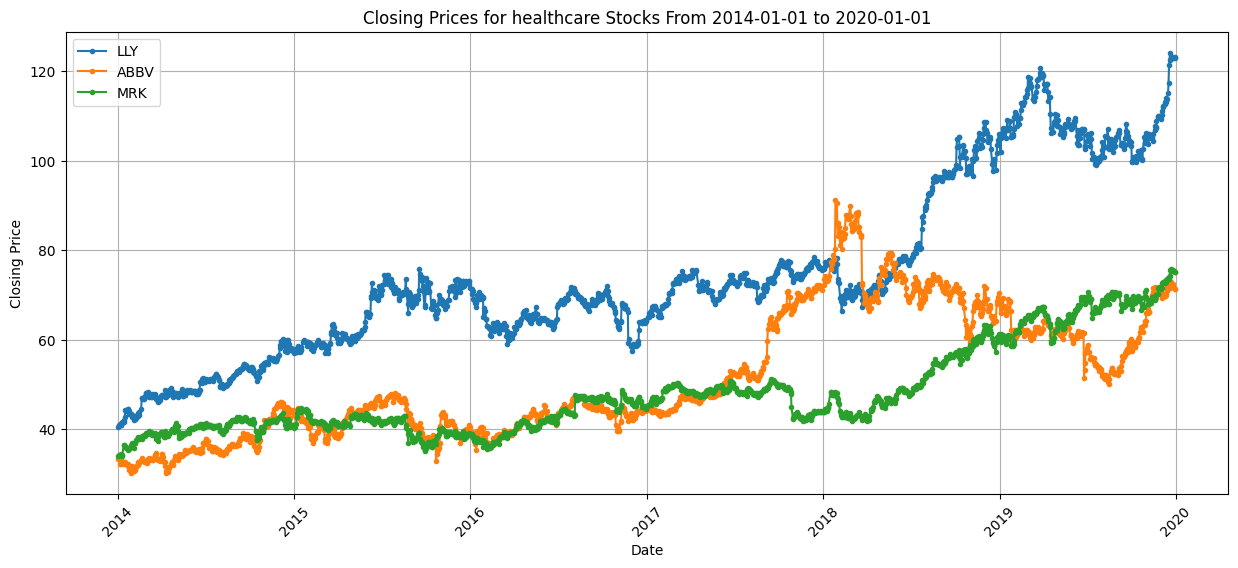

In [ ]:
# Visualize Dataset
plt.figure(figsize=(15, 6))
if use_single:
  plt.plot(data.index, data[tickers[ticker_set][single_index] + '-Close'], marker='.')
else:
  for ticker in tickers[ticker_set]:
    plt.plot(data.index, data[ticker + '-Close'], marker='.', label=ticker)
plt.title('Closing Prices for ' + description)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

## Data Collection using Yahoo Finance

In [ ]:
import yfinance as yf

tickers = ['LLY', 'ABBV', 'MRK', 'TT', 'CRH', 'URI']

data = {}
for ticker in tickers:
    data[ticker] = yf.download(ticker, start="2020-01-01", end="2023-12-31")
    data[ticker].columns = ['_'.join(col) for col in data[ticker].columns]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [ ]:
import pandas as pd

df_LLY = data['LLY']
df_ABBV = data['ABBV']
df_MRK = data['MRK']
df_TT = data['TT']
df_CRH = data['CRH']
df_URI = data['URI']

df_LLY

Adj Close_ABBV  Close_ABBV   High_ABBV    Low_ABBV   Open_ABBV  \
Date                                                                         
2020-01-02       72.264885   89.550003   89.570000   88.510002   89.080002   
2020-01-03       71.578964   88.699997   89.389999   87.900002   88.169998   
2020-01-06       72.143837   89.400002   89.620003   87.980003   88.220001   
2020-01-07       71.732285   88.889999   89.540001   88.260002   88.930000   
2020-01-08       72.240677   89.519997   90.059998   88.870003   89.150002   
...                    ...         ...         ...         ...         ...   
2023-12-22      149.475891  154.940002  155.460007  153.089996  153.289993   
2023-12-26      149.167160  154.619995  155.279999  154.130005  154.250000   
2023-12-27      149.418015  154.880005  154.970001  153.720001  154.050003   
2023-12-28      149.292603  154.750000  155.630005  154.539993  155.250000   
2023-12-29      149.504837  154.970001  155.210007  154.410004  154.539993   

            Volume_ABBV  
Date                     
2020-01-02      5639200  
2020-01-03      5988500  
2020-01-06      6786600  
2020-01-07      7242500  
2020-01-08      7696800  
...                 ...  
2023-12-22      3372800  
2023-12-26      2073400  
2023-12-27      3747400  
2023-12-28      2601200  
2023-12-29      3711400  

[1006 rows x 6 columns]

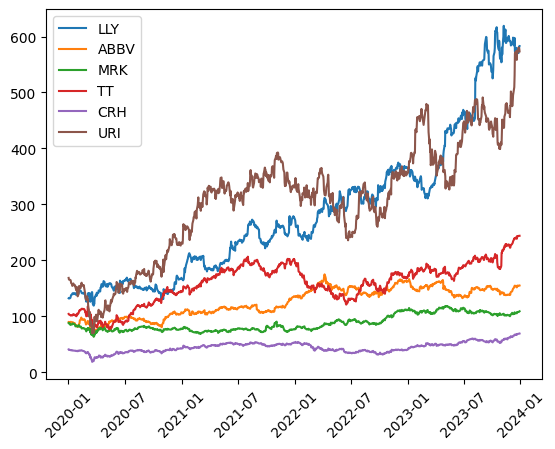

In [ ]:
import matplotlib.pyplot as plt
plt.xticks(rotation=45)

for ticker in tickers:
  plt.plot(data[ticker].index, data[ticker]['Close_' + ticker])

plt.legend(tickers)


In [ ]:
# Step 1: Define Tickers of Interest
tickers = {
    'technology': ['NVDA', 'GOOG'],
    'healthcare': ['LLY', 'ABBV', 'MRK'],
    'construction': ['TT', 'CRH', 'URI'],
    'food': ['ADM', 'KHC', 'GIS']
}
selected_ticker_set = 'healthcare'  # Choose industry
start_date = '2015-01-01'
end_date = '2020-01-01'

use_single = True  # Set to False for multiple stocks
single_index = 2  # Index of the stock to analyze (if single)

In [ ]:
# Step 2: Fetch Dataset
if use_single:
    symbol = tickers[selected_ticker_set][single_index]
    stock_data = yf.download(symbol, start=start_date, end=end_date)
    stock_data = stock_data[['Close']].dropna()
    description = f"Stock {symbol} from {start_date} to {end_date}"
else:
    stock_data_list = []
    for symbol in tickers[selected_ticker_set]:
        stock = yf.Ticker(symbol)
        data = stock.history(start=start_date, end=end_date)
        data = data[['Close']].dropna().rename(columns={'Close': f"{symbol}-Close"})
        stock_data_list.append(data)
    stock_data = pd.concat(stock_data_list, axis=1)
    description = f"{selected_ticker_set} Stocks from {start_date} to {end_date}"

[*********************100%***********************]  1 of 1 completed


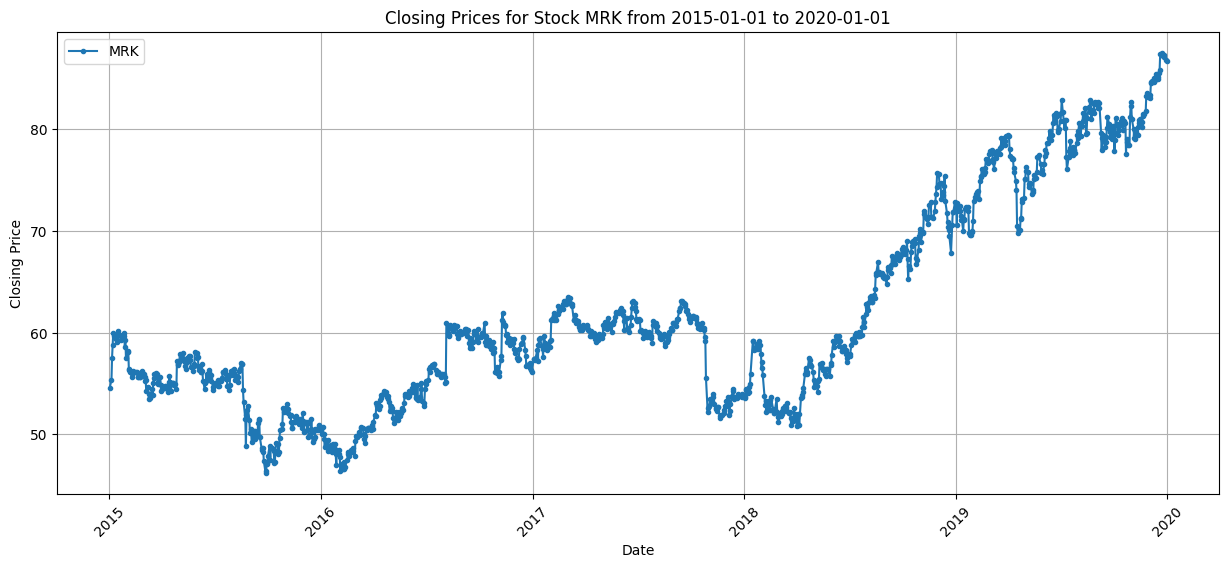

In [ ]:
# Step 3: Visualize Dataset
plt.figure(figsize=(15, 6))
if use_single:
    plt.plot(stock_data.index, stock_data['Close'], marker='.', label=symbol)
else:
    for col in stock_data.columns:
        plt.plot(stock_data.index, stock_data[col], marker='.', label=col.split('-')[0])
plt.title(f"Closing Prices for {description}")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.show()

## Data Preprocessing

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

# Convert to PyTorch tensors
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(x), np.array(y)

SEQ_LENGTH = 60  # Sequence length for the Transformer
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train-test split
train_size = int(0.7 * len(X))
val_size = int(0.15 * len(X))

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# Convert to PyTorch tensors
import torch
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
print(data.head)

<bound method NDFrame.head of Price       Adj Close      Close       High        Low       Open     Volume  \
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL   
Date                                                                           
2000-01-03   0.843077   0.999442   1.004464   0.907924   0.936384  535796800   
2000-01-04   0.771997   0.915179   0.987723   0.903460   0.966518  512377600   
2000-01-05   0.783294   0.928571   0.987165   0.919643   0.926339  778321600   
2000-01-06   0.715508   0.848214   0.955357   0.848214   0.947545  767972800   
2000-01-07   0.749401   0.888393   0.901786   0.852679   0.861607  460734400   
...               ...        ...        ...        ...        ...        ...   
2019-12-24  68.898689  71.067497  71.222504  70.730003  71.172501   48478800   
2019-12-26  70.265671  72.477501  72.495003  71.175003  71.205002   93121200   
2019-12-27  70.238998  72.449997  73.492500  72.029999  72.779999  146266000   
2019-12-30

In [ ]:
print(data.head)

<bound method NDFrame.head of Price       Adj Close      Close       High        Low       Open     Volume  \
Ticker           AAPL       AAPL       AAPL       AAPL       AAPL       AAPL   
Date                                                                           
2000-01-03   0.843077   0.999442   1.004464   0.907924   0.936384  535796800   
2000-01-04   0.771997   0.915179   0.987723   0.903460   0.966518  512377600   
2000-01-05   0.783294   0.928571   0.987165   0.919643   0.926339  778321600   
2000-01-06   0.715508   0.848214   0.955357   0.848214   0.947545  767972800   
2000-01-07   0.749401   0.888393   0.901786   0.852679   0.861607  460734400   
...               ...        ...        ...        ...        ...        ...   
2019-12-24  68.898689  71.067497  71.222504  70.730003  71.172501   48478800   
2019-12-26  70.265671  72.477501  72.495003  71.175003  71.205002   93121200   
2019-12-27  70.238998  72.449997  73.492500  72.029999  72.779999  146266000   
2019-12-30

In [ ]:
# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X = data[['7_MA', '21_MA', 'Lag_1', 'Lag_2', 'Volume']]
y = data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order


In [ ]:
y_test

Ticker           AAPL
Date                 
2016-01-07  24.112499
2016-01-08  24.240000
2016-01-11  24.632500
2016-01-12  24.990000
2016-01-13  24.347500
...               ...
2019-12-24  71.067497
2019-12-26  72.477501
2019-12-27  72.449997
2019-12-30  72.879997
2019-12-31  73.412498

[1003 rows x 1 columns]

In [ ]:
# standardize features of our dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Dataset Creation / Preprocessing

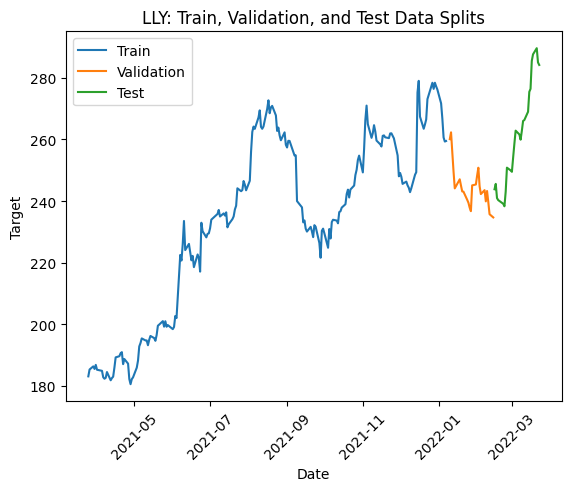

In [ ]:
# Start day second time around: '2021-03-25'
windowed_df_LLY = df_to_windowed_df(data['LLY'],
                                '2021-03-25',
                                '2022-03-23',
                                ticker='LLY',
                                n=5)
dates_LLY, X_LLY, y_LLY = windowed_df_to_date_X_y(windowed_df_LLY)
train_data_LLY, val_data_LLY, test_data_LLY = split_and_plot_data(dates_LLY, X_LLY, y_LLY, ticker='LLY')

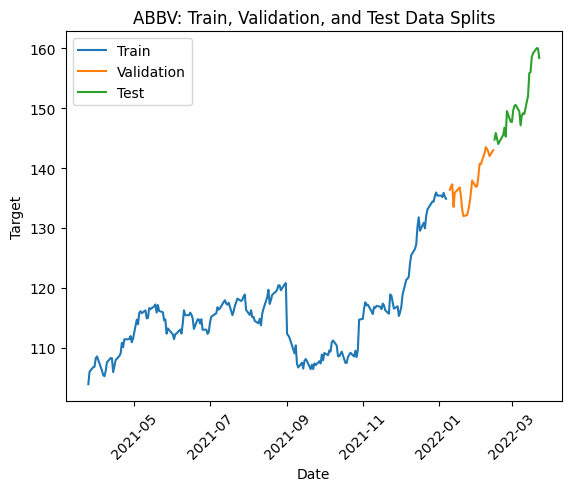

In [ ]:
# Start day second time around: '2021-03-25'
windowed_df_ABBV = df_to_windowed_df(data['ABBV'],
                                '2021-03-25',
                                '2022-03-23',
                                ticker='ABBV',
                                n=5)
dates_ABBV, X_ABBV, y_ABBV = windowed_df_to_date_X_y(windowed_df_ABBV)
train_data_ABBV, val_data_ABBV, test_data_ABBV = split_and_plot_data(dates_ABBV, X_ABBV, y_ABBV, ticker='ABBV')

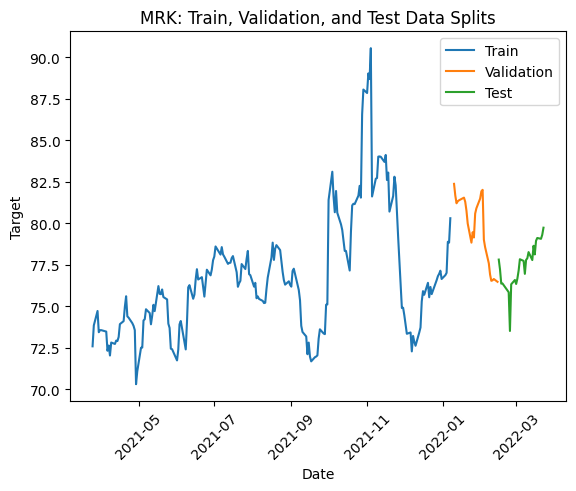

In [ ]:
# Start day second time around: '2021-03-25'
windowed_df_MRK = df_to_windowed_df(data['MRK'],
                                '2021-03-25',
                                '2022-03-23',
                                ticker='MRK',
                                n=5)
dates_MRK, X_MRK, y_MRK = windowed_df_to_date_X_y(windowed_df_MRK)
train_data_MRK, val_data_MRK, test_data_MRK = split_and_plot_data(dates_MRK, X_MRK, y_MRK, ticker='MRK')

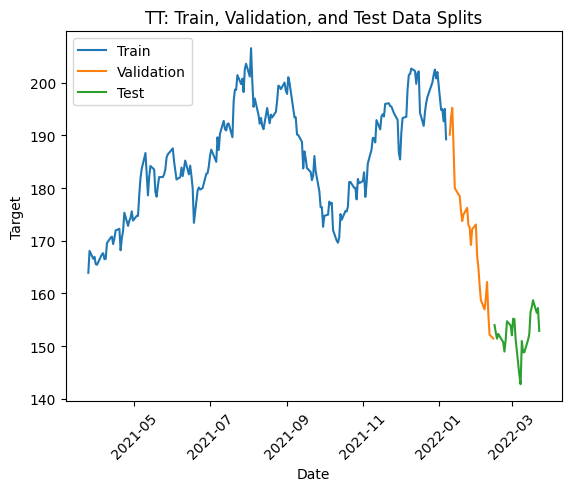

In [ ]:
# Start day second time around: '2021-03-25'
windowed_df_TT = df_to_windowed_df(data['TT'],
                                '2021-03-25',
                                '2022-03-23',
                                ticker='TT',
                                n=5)
dates_TT, X_TT, y_TT = windowed_df_to_date_X_y(windowed_df_TT)
train_data_TT, val_data_TT, test_data_TT = split_and_plot_data(dates_TT, X_TT, y_TT, ticker='TT')

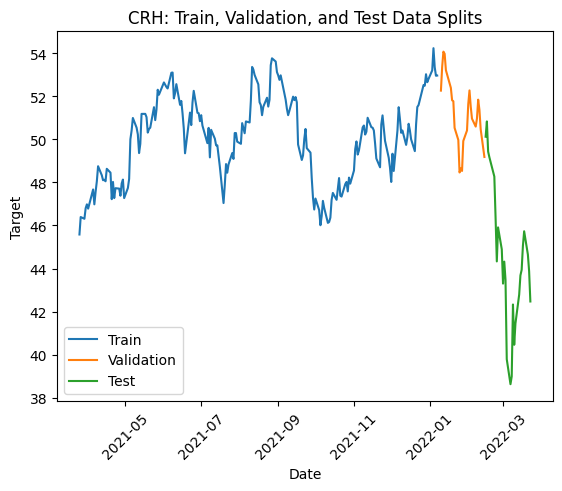

In [ ]:
# Start day second time around: '2021-03-25'
windowed_df_CRH = df_to_windowed_df(data['CRH'],
                                '2021-03-25',
                                '2022-03-23',
                                ticker='CRH',
                                n=5)
dates_CRH, X_CRH, y_CRH = windowed_df_to_date_X_y(windowed_df_CRH)
train_data_CRH, val_data_CRH, test_data_CRH = split_and_plot_data(dates_CRH, X_CRH, y_CRH, ticker='CRH')

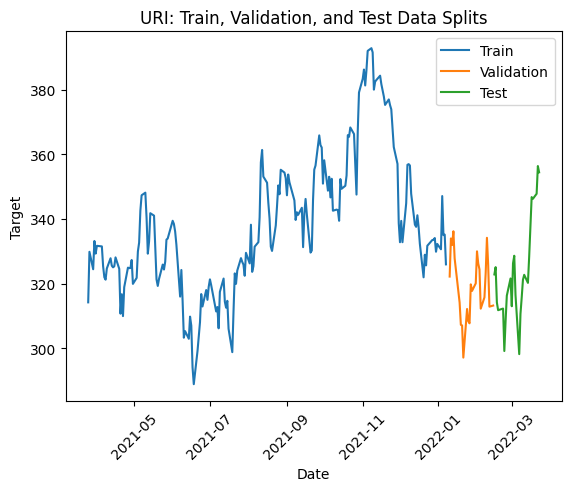

In [ ]:
# Start day second time around: '2021-03-25'
windowed_df_URI = df_to_windowed_df(data['URI'],
                                '2021-03-25',
                                '2022-03-23',
                                ticker='URI',
                                n=5)
dates_URI, X_URI, y_URI = windowed_df_to_date_X_y(windowed_df_URI)
train_data_URI, val_data_URI, test_data_URI = split_and_plot_data(dates_URI, X_URI, y_URI, ticker='URI')

## Example dataframe and shape analysis

In [ ]:
windowed_df_LLY

Target Date    Target-5    Target-4    Target-3    Target-2    Target-1  \
0    2021-03-25  183.929993  184.289993  185.839996  183.679993  180.169998   
1    2021-03-26  184.289993  185.839996  183.679993  180.169998  183.089996   
2    2021-03-29  185.839996  183.679993  180.169998  183.089996  185.309998   
3    2021-03-30  183.679993  180.169998  183.089996  185.309998  186.339996   
4    2021-03-31  180.169998  183.089996  185.309998  186.339996  185.500000   
..          ...         ...         ...         ...         ...         ...   
247  2022-03-17  266.019989  266.299988  269.000000  275.459991  276.440002   
248  2022-03-18  266.299988  269.000000  275.459991  276.440002  285.510010   
249  2022-03-21  269.000000  275.459991  276.440002  285.510010  287.640015   
250  2022-03-22  275.459991  276.440002  285.510010  287.640015  289.640015   
251  2022-03-23  276.440002  285.510010  287.640015  289.640015  285.019989   

         Target  
0    183.089996  
1    185.309998  
2    186.339996  
3    185.500000  
4    186.820007  
..          ...  
247  285.510010  
248  287.640015  
249  289.640015  
250  285.019989  
251  284.190002  

[252 rows x 7 columns]

In [ ]:
dates_LLY.shape, X_LLY.shape, y_LLY.shape

((252,), (252, 5, 1), (252,))

In [ ]:
# Step 4: Preprocess Data with Date-based Splitting
scaler = MinMaxScaler(feature_range=(0, 1))

# Specify date range for training and testing
train_end_date = "2018-12-31"

# Split based on dates
train_data = stock_data[:train_end_date]
test_data = stock_data[train_end_date:]

# Scale training and testing data
scaled_train_data = scaler.fit_transform(train_data[['Close']])
scaled_test_data = scaler.transform(test_data[['Close']])

# Create sequences for training data
sequence_length = 60
X_train, y_train = [], []
for i in range(sequence_length, len(scaled_train_data)):
    X_train.append(scaled_train_data[i-sequence_length:i, 0])
    y_train.append(scaled_train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Create sequences for testing data
X_test, y_test = [], []
for i in range(sequence_length, len(scaled_test_data)):
    X_test.append(scaled_test_data[i-sequence_length:i, 0])
    y_test.append(scaled_test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

## Models Used

In [ ]:
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads, ff_dim, num_layers, output_dim, dropout=0.1):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.positional_encoding = nn.Parameter(torch.zeros(1, SEQ_LENGTH, embed_dim))
        self.encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=num_heads,
            dim_feedforward=ff_dim,
            dropout=dropout
        )
        self.transformer = nn.TransformerEncoder(self.encoder_layer, num_layers=num_layers)
        self.fc_out = nn.Linear(embed_dim, output_dim)

    def forward(self, x):
        # Add embeddings and positional encoding
        x = self.embedding(x) + self.positional_encoding
        x = self.transformer(x)
        # Take the output of the last time step
        out = self.fc_out(x[:, -1, :])
        return out

# Initialize the model
INPUT_DIM = 1  # Number of tickers
EMBED_DIM = 64
NUM_HEADS = 4
FF_DIM = 128
NUM_LAYERS = 2
OUTPUT_DIM = 1  # Predict prices for all tickers

model = TransformerModel(INPUT_DIM, EMBED_DIM, NUM_HEADS, FF_DIM, NUM_LAYERS, OUTPUT_DIM)


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [ ]:
import torch.optim as optim

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
def train_model(model, X_train, y_train, X_val, y_val, num_epochs=20, batch_size=32):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for i in range(0, len(X_train), batch_size):
            X_batch = X_train[i:i+batch_size]
            y_batch = y_train[i:i+batch_size]

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0.0
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_val), batch_size):
                X_batch = X_val[i:i+batch_size]
                y_batch = y_val[i:i+batch_size]
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(X_train)}, Validation Loss: {val_loss/len(X_val)}")

# Train the model
train_model(model, X_train, y_train, X_val, y_val, num_epochs=20)


Epoch 1/20, Train Loss: 0.00108800656751225, Validation Loss: 0.005685333245792869
Epoch 2/20, Train Loss: 0.0018422772103769433, Validation Loss: 0.002350319352510838
Epoch 3/20, Train Loss: 0.0019493274505167915, Validation Loss: 0.0035333175461884983
Epoch 4/20, Train Loss: 0.0023681307161506934, Validation Loss: 0.006932114589147728
Epoch 5/20, Train Loss: 0.0034275587641485125, Validation Loss: 0.010609902732865105
Epoch 6/20, Train Loss: 0.004876442368893588, Validation Loss: 0.0053523594523941335
Epoch 7/20, Train Loss: 0.0034276173716224286, Validation Loss: 0.0026712758081585334
Epoch 8/20, Train Loss: 0.0022006045939876734, Validation Loss: 0.002241714259182941
Epoch 9/20, Train Loss: 0.0015122387313721856, Validation Loss: 0.0016596777437452497
Epoch 10/20, Train Loss: 0.0005070591475458945, Validation Loss: 0.0004362476958409368
Epoch 11/20, Train Loss: 0.00016354618572934503, Validation Loss: 0.0005196343233298989
Epoch 12/20, Train Loss: 0.00013592583294024332, Validation

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"Test Loss: {test_loss.item()}")

# Reverse scaling for interpretability
predicted_prices = scaler.inverse_transform(predictions.numpy())
actual_prices = scaler.inverse_transform(y_test.numpy())


Test Loss: 0.008322750218212605


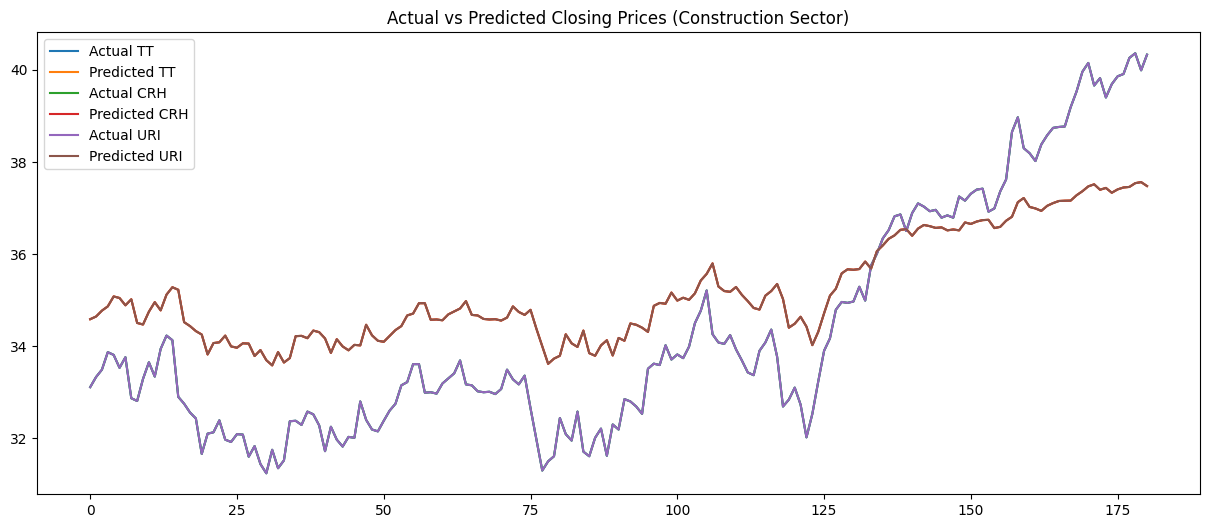

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
# Iterate through the selected tickers instead of all tickers
for i, ticker in enumerate(tickers[selected_ticker_set]):
    # Plot only the first column (index 0) since there's only one stock
    plt.plot(actual_prices[:, 0], label=f"Actual {ticker}")
    plt.plot(predicted_prices[:, 0], label=f"Predicted {ticker}")
plt.legend()
plt.title("Actual vs Predicted Closing Prices (Construction Sector)")
plt.show()


In [ ]:
# Step 4: Preprocess Data with Date-based Splitting
scaler = MinMaxScaler(feature_range=(0, 1))

# Specify date range for training and testing
train_end_date = "2018-12-31"

# Split based on dates
train_data = stock_data[:train_end_date]
test_data = stock_data[train_end_date:]

# Scale training and testing data
scaled_train_data = scaler.fit_transform(train_data[['Close']])
scaled_test_data = scaler.transform(test_data[['Close']])

# Create sequences for training data
sequence_length = 60
X_train, y_train = [], []
for i in range(sequence_length, len(scaled_train_data)):
    X_train.append(scaled_train_data[i-sequence_length:i, 0])
    y_train.append(scaled_train_data[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Create sequences for testing data
X_test, y_test = [], []
for i in range(sequence_length, len(scaled_test_data)):
    X_test.append(scaled_test_data[i-sequence_length:i, 0])
    y_test.append(scaled_test_data[i, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

# Reshape for LSTM input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# LINEAR REGRESSION APPROACH

In [ ]:
# trying linear regression

model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 0.3855769089002136
Mean Absolute Error: 0.42952491585062325


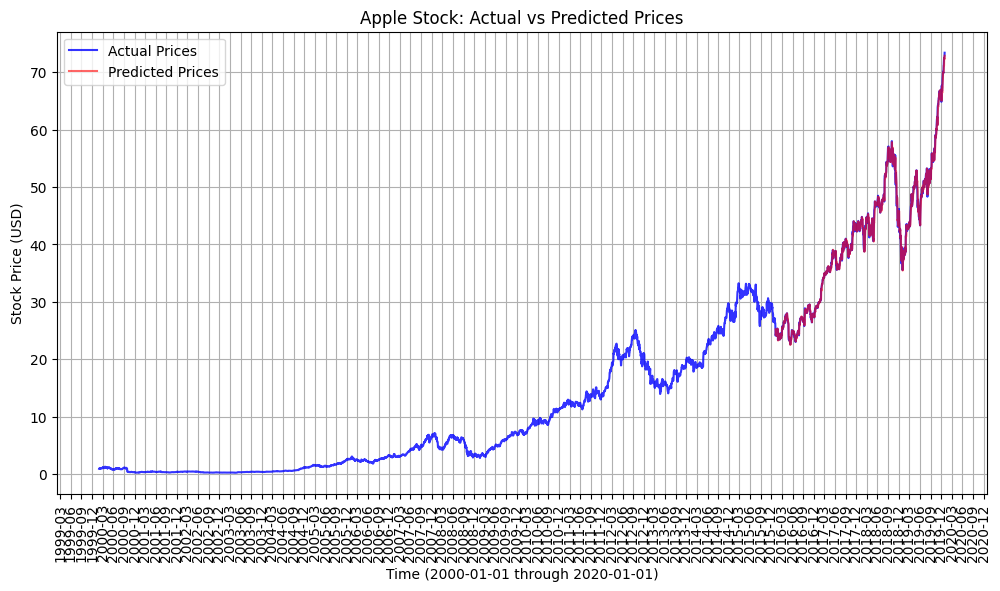

In [ ]:
# visualize model predictions vs actual stock closing prices

plt.figure(figsize=(12, 6))

# plot ground truth prices
plt.plot(data.index, data['Close'], label='Actual Prices', color='blue', alpha=0.8)

# plot predicted prices
plt.plot(data.index[-len(y_pred):], y_pred, label='Predicted Prices', color='red', alpha=0.6)

# formatting plot to account for dates format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # adjust this interval if we need
plt.xticks(rotation=90)

plt.xlabel('Time (2000-01-01 through 2020-01-01)')
plt.ylabel('Stock Price (USD)')
plt.title('Apple Stock: Actual vs Predicted Prices')
plt.legend()

plt.grid(True)
plt.show()


# RANDOM FORREST APROACH

In [ ]:
# get our data loaded in first

stock_name = "AAPL"
# YYYY-MM-DD
start_date = "2000-01-01"
end_date = "2020-01-01"

data = yf.download(stock_name, start=start_date, end=end_date)
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

data = data.dropna()  # want tto drop rows with NaN values after feature creation

[*********************100%***********************]  1 of 1 completed


In [ ]:
print(data.head())


Price      Adj Close     Close      High       Low      Open     Volume  \
Ticker          AAPL      AAPL      AAPL      AAPL      AAPL       AAPL   
Date                                                                      
2000-02-01  0.755050  0.895089  0.937500  0.892857  0.928571  318035200   
2000-02-02  0.744223  0.882254  0.911830  0.866071  0.899554  464195200   
2000-02-03  0.778116  0.922433  0.930804  0.895089  0.895647  475193600   
2000-02-04  0.813421  0.964286  0.982143  0.925223  0.928013  425320000   
2000-02-07  0.859081  1.018415  1.020089  0.945871  0.964286  441067200   

Price           7_MA     21_MA     Lag_1     Lag_2  
Ticker                                              
Date                                                
2000-02-01  0.949378  0.921530  0.926339  0.907366  
2000-02-02  0.939891  0.915949  0.895089  0.926339  
2000-02-03  0.928492  0.916295  0.882254  0.895089  
2000-02-04  0.925701  0.917995  0.922433  0.882254  
2000-02-07  0.930883  0.9261

In [ ]:
# extracting feature we want
X = data[['7_MA', '21_MA', 'Lag_1', 'Lag_2', 'Volume']]  # Example features
y = data['Close']  # here, the target is the closing price

In [ ]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [ ]:
# train and make predictions using random forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# make our prediction
y_pred = rf_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [ ]:
# model evaluation using MSE
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

Mean Squared Error: 186.5795595537429
Mean Absolute Error: 10.054858566314604


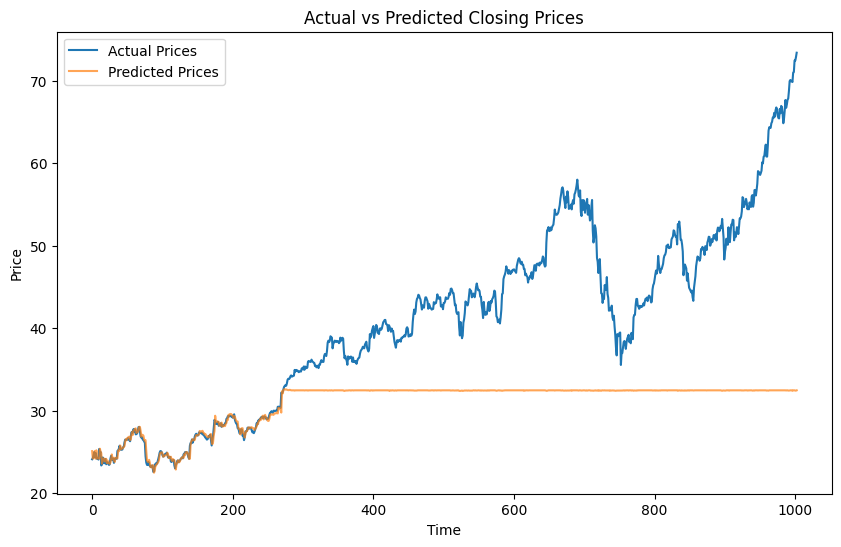

In [ ]:
# visualize our results
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices', alpha=0.7)
plt.title('Actual vs Predicted Closing Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

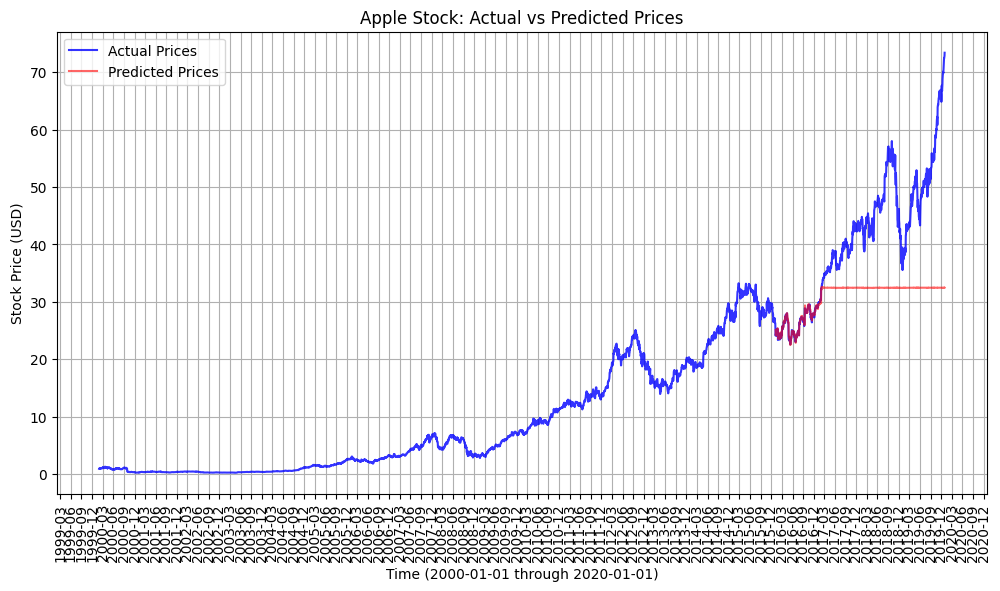

In [ ]:
# visualize model predictions vs actual stock closing prices

plt.figure(figsize=(12, 6))

# plot ground truth prices
plt.plot(data.index, data['Close'], label='Actual Prices', color='blue', alpha=0.8)

# plot predicted prices
plt.plot(data.index[-len(y_pred):], y_pred, label='Predicted Prices', color='red', alpha=0.6)

# formatting plot to account for dates format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # adjust this interval if we need
plt.xticks(rotation=90)

plt.xlabel('Time (2000-01-01 through 2020-01-01)')
plt.ylabel('Stock Price (USD)')
plt.title('Apple Stock: Actual vs Predicted Prices')
plt.legend()

plt.grid(True)
plt.show()


# XGBoost Regressor

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor

In [ ]:

# train model
xgb_model = XGBRegressor(n_estimators=500, learning_rate=0.2, max_depth=8, random_state=42)
xgb_model.fit(X_train, y_train)

# have model make predictionss
y_pred = xgb_model.predict(X_test)

# find our error
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


Mean Squared Error (MSE): 184.37444927664396
Mean Absolute Error (MAE): 9.991655056878315


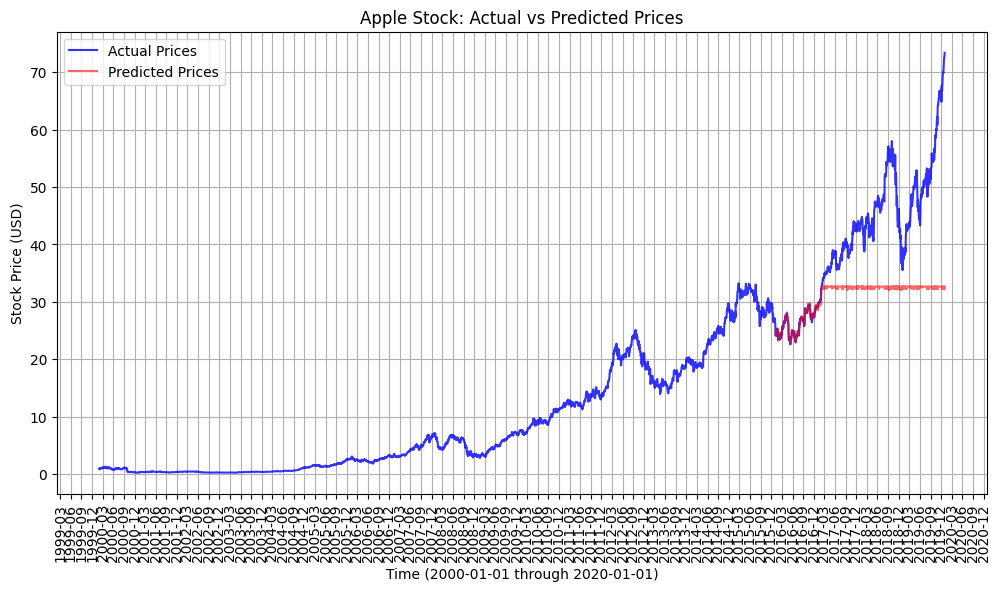

In [ ]:
# visualize model predictions vs actual stock closing prices

plt.figure(figsize=(12, 6))

# plot ground truth prices
plt.plot(data.index, data['Close'], label='Actual Prices', color='blue', alpha=0.8)

# plot predicted prices
plt.plot(data.index[-len(y_pred):], y_pred, label='Predicted Prices', color='red', alpha=0.6)

# formatting plot to account for dates format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # adjust this interval if we need
plt.xticks(rotation=90)

plt.xlabel('Time (2000-01-01 through 2020-01-01)')
plt.ylabel('Stock Price (USD)')
plt.title('Apple Stock: Actual vs Predicted Prices')
plt.legend()

plt.grid(True)
plt.show()


# LSTM APPROACH

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [ ]:
# fetch and Prepare Data


stock_name = "AAPL"
# YYYY-MM-DD
start_date = "2000-01-01"
end_date = "2020-01-01"

data = yf.download(stock_name, start=start_date, end=end_date)

# data = yf.download('AAPL', start='2015-01-01', end='2023-12-31')
data = data[['Close']]

[*********************100%***********************]  1 of 1 completed


In [ ]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

In [ ]:
# make our sequence

sequence_length = 50  # this is the number of past days to use for the model prediction
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data['Close'].iloc[i-sequence_length:i].values)  # past number of days specified
    y.append(data['Close'].iloc[i])  # we predict the next day's price

X, y = np.array(X), np.array(y)


In [ ]:
# we train test split our data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# reshaping X for LSTM model (samples, time_steps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [ ]:
# building the LSTM Model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))  # single output for regression here

model.compile(optimizer='adam', loss='mean_squared_error')

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# train
model.fit(X_train, y_train, batch_size=32, epochs=20)

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 83ms/step - loss: 0.0050
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 112ms/step - loss: 6.1035e-05
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 83ms/step - loss: 6.0568e-05
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 60ms/step - loss: 5.6644e-05
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 6.0000e-05
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 14s 101ms/step - loss: 4.6485e-05
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 4.3065e-05
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 53ms/step - loss: 4.3499e-05
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 46ms/step - loss: 4.6899e-05
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 4.0217e-05
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 52ms/step - loss: 3.7878e-05
Epoch 12/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step - loss: 3.4740e-05
Epoch 13/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - loss: 3.3950e-05
Epoch 14/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 47ms/ste

In [ ]:
# make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)  # revsersese scale
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


In [ ]:
mse = mean_squared_error(y_test_actual, y_pred)
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 5.461422091261944


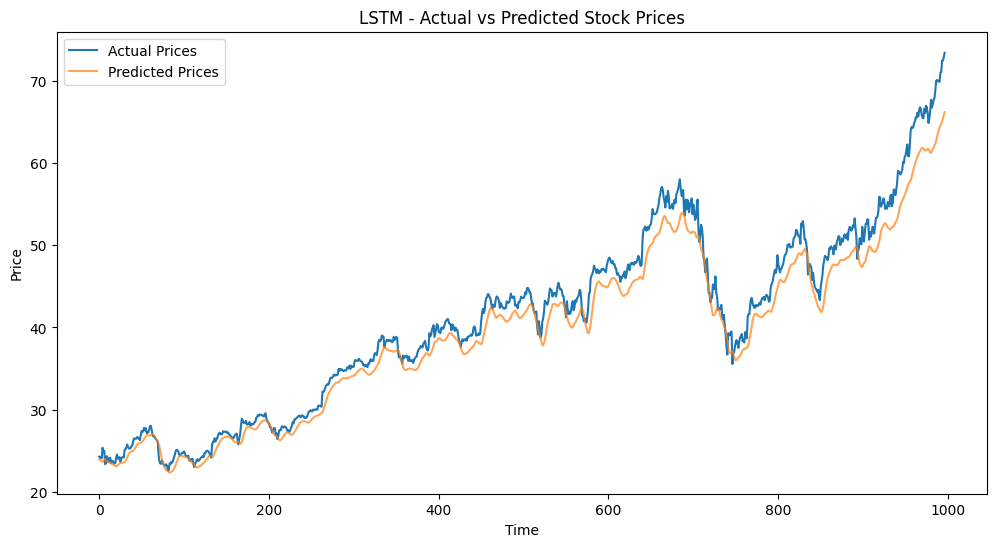

In [ ]:
# visualize resutls
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(y_test_actual, label='Actual Prices')
plt.plot(y_pred, label='Predicted Prices', alpha=0.7)
plt.title('LSTM - Actual vs Predicted Stock Prices')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

[*********************100%***********************]  1 of 1 completed


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


125/125 ━━━━━━━━━━━━━━━━━━━━ 12s 61ms/step - loss: 0.0076 - val_loss: 0.0035
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 63ms/step - loss: 6.3547e-05 - val_loss: 0.0038
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - loss: 5.3670e-05 - val_loss: 0.0024
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 10s 50ms/step - loss: 6.2986e-05 - val_loss: 0.0014
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 94ms/step - loss: 5.9483e-05 - val_loss: 0.0014
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 64ms/step - loss: 6.2844e-05 - val_loss: 0.0011
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 49ms/step - loss: 5.2423e-05 - val_loss: 0.0023
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step - loss: 4.7377e-05 - val_loss: 0.0012
Epoch 9/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 5.3903e-05 - val_loss: 0.0011
Epoch 10/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 50ms/step - loss: 4.3499e-05 - val_loss: 0.0016
Epoch 11/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - loss: 4.0210e-05 - val_loss: 0.0027
Epoch 

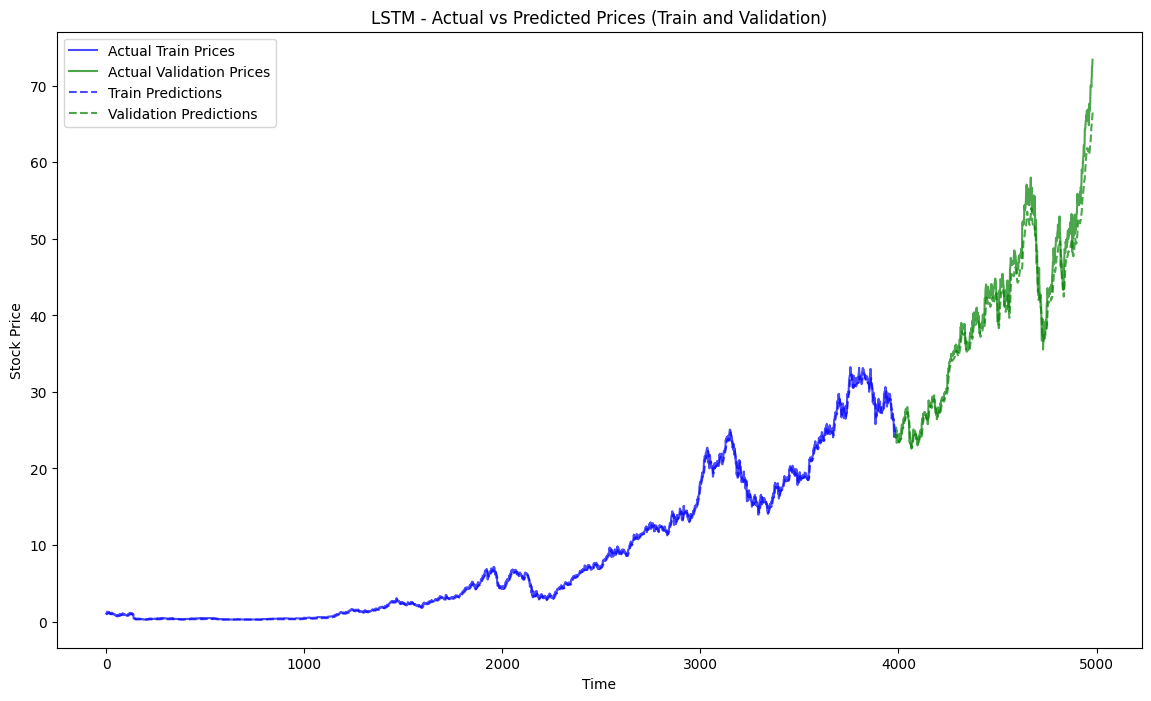

In [ ]:
stock_name = "AAPL"
# YYYY-MM-DD
start_date = "2000-01-01"
end_date = "2020-01-01"

data = yf.download(stock_name, start=start_date, end=end_date)
data = data[['Close']]

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close'] = scaler.fit_transform(data[['Close']])

sequence_length = 50  # Number of past days to use for prediction
X, y = [], []
for i in range(sequence_length, len(data)):
    X.append(data['Close'].iloc[i-sequence_length:i].values)  # prior 50 days
    y.append(data['Close'].iloc[i])  # pred next day's price

X, y = np.array(X), np.array(y)

# train test split wiht 80 20
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# reshape lstm
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_val = X_val.reshape((X_val.shape[0], X_val.shape[1], 1))

# create lstm modell
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25, activation='relu'))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# train
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=32,
    epochs=20
)

# have our modle predict
y_train_pred = model.predict(X_train)
y_val_pred = model.predict(X_val)


y_train_pred = scaler.inverse_transform(y_train_pred)
y_val_pred = scaler.inverse_transform(y_val_pred)

y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_val_actual = scaler.inverse_transform(y_val.reshape(-1, 1))

# errors
mse_train = mean_squared_error(y_train_actual, y_train_pred)
mse_val = mean_squared_error(y_val_actual, y_val_pred)

print(f"Train MSE: {mse_train}")
print(f"Validation MSE: {mse_val}")

# visualization below
plt.figure(figsize=(14, 8))

plt.plot(range(len(y_train_actual)), y_train_actual, label='Actual Train Prices', alpha=0.7, color='blue')
plt.plot(range(len(y_train_actual), len(y_train_actual) + len(y_val_actual)), y_val_actual, label='Actual Validation Prices', alpha=0.7, color='green')

plt.plot(range(len(y_train_pred)), y_train_pred, label='Train Predictions', alpha=0.7, linestyle='--', color='blue')
plt.plot(range(len(y_train_pred), len(y_train_pred) + len(y_val_pred)), y_val_pred, label='Validation Predictions', alpha=0.7, linestyle='--', color='green')

plt.title('LSTM - Actual vs Predicted Prices (Train and Validation)')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Multilayer Perceptron (MLP)

In [ ]:
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt


In [ ]:
# scale the features below
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# create the MLP model
mlp_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),  # input
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # output
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# make model
mlp_model.compile(optimizer=Adam(learning_rate=0.0001), loss='mse', metrics=['mae'])

In [ ]:
# traiing our model
history = mlp_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

# evaluate the model and see its performance
y_pred = mlp_model.predict(X_test_scaled).flatten()

Epoch 1/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0456 - mae: 0.1181 - val_loss: 0.6260 - val_mae: 0.5604
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0436 - mae: 0.1154 - val_loss: 0.8291 - val_mae: 0.6646
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0364 - mae: 0.1091 - val_loss: 0.5194 - val_mae: 0.5108
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0410 - mae: 0.1116 - val_loss: 0.7597 - val_mae: 0.6296
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0420 - mae: 0.1137 - val_loss: 0.5913 - val_mae: 0.5436
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0443 - mae: 0.1129 - val_loss: 0.5535 - val_mae: 0.5263
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0392 - mae: 0.1100 - val_loss: 0.7696 - val_mae: 0.6328
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0369 - mae: 0.1075 - val_loss: 0.8052 - val_mae: 0.6505
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/

In [ ]:
# errors below
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

Mean Squared Error (MSE): 0.6852525015661706
Mean Absolute Error (MAE): 0.5920064190211348


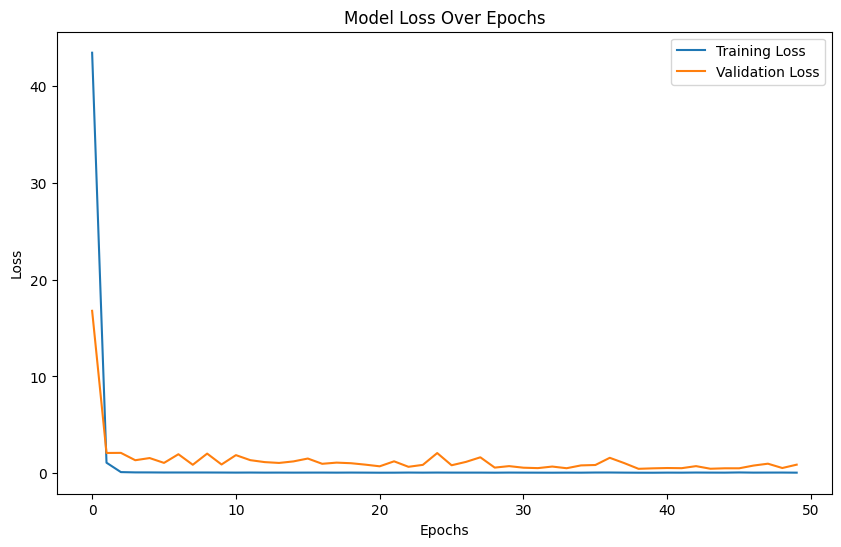

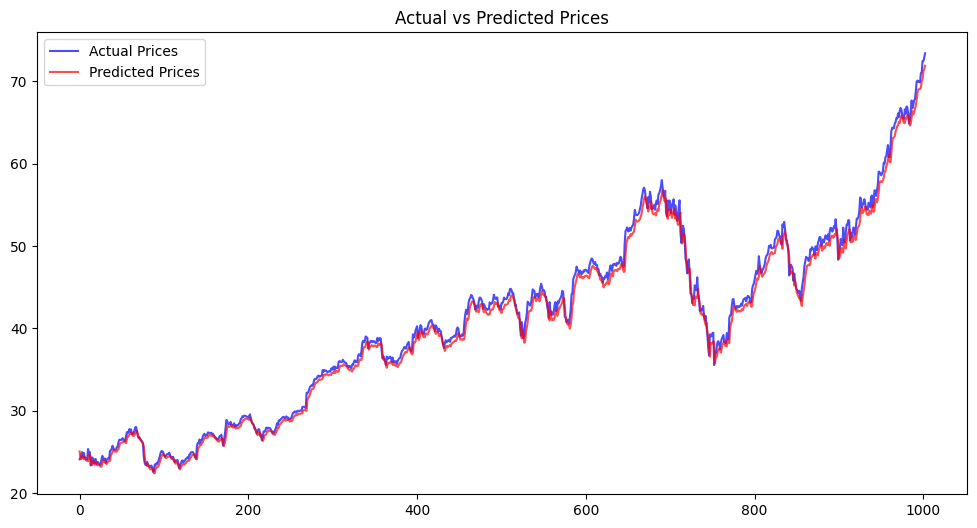

In [ ]:
# plotting time
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Prices', color='red', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()

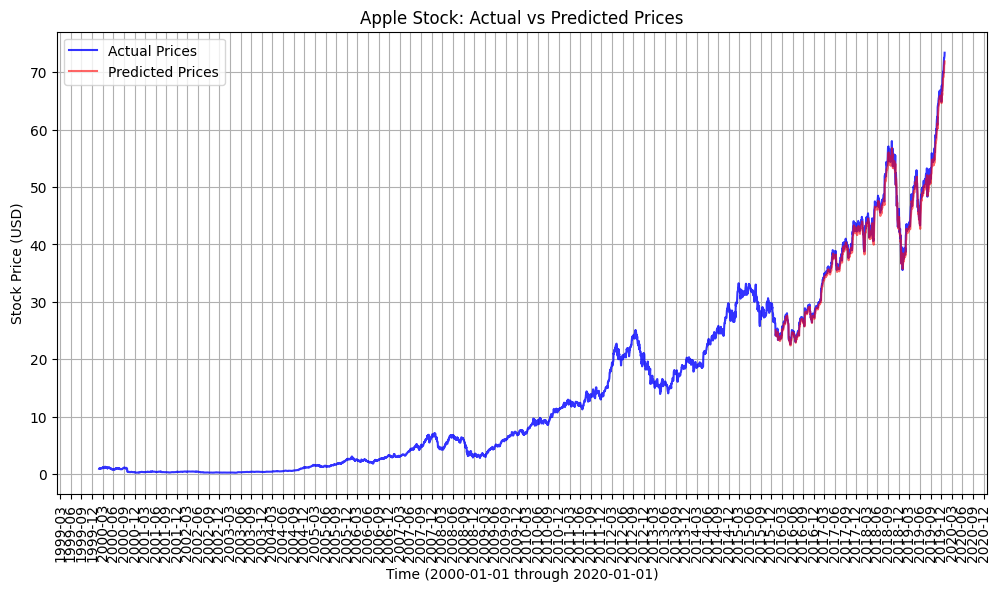

In [ ]:
# visualize model predictions vs actual stock closing prices

plt.figure(figsize=(12, 6))

# plot ground truth prices
plt.plot(data.index, data['Close'], label='Actual Prices', color='blue', alpha=0.8)

# plot predicted prices
plt.plot(data.index[-len(y_pred):], y_pred, label='Predicted Prices', color='red', alpha=0.6)

# formatting plot to account for dates format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # adjust this interval if we need
plt.xticks(rotation=90)

plt.xlabel('Time (2000-01-01 through 2020-01-01)')
plt.ylabel('Stock Price (USD)')
plt.title('Apple Stock: Actual vs Predicted Prices')
plt.legend()

plt.grid(True)
plt.show()


In [ ]:
# RNN Model Definition

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(1, x.size(0), self.hidden_size)

        # Pass through RNN
        out, _ = self.rnn(x, h0)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out)
        return out

In [ ]:
# Hyperparameters
input_size = 1 # Each number in the sequence is a single value
hidden_size = 256
output_size = 1  # Predicting the next number in the sequence
learning_rate = 0.001
num_epochs = 5000

# Create a sample dataset
values = list(range(1, 100))

# input_list = []
# for i, value in enumerate(values):
#   x1 = [item - (len(values) - 1 - i) if item - (len(values) - 1 - i) > 0 else 0 for item in values[i:i + input_size]]
#   input_list.append(x1)

X = torch.tensor([values], dtype=torch.float32)
y = torch.tensor([[i + 1 for i in values]], dtype=torch.float32)

# Create a sample look-ahead dataset
X_ahead = torch.tensor([[i - 1 for i in values]], dtype=torch.float32)

# Create the model and optimizer
model = SimpleRNN(input_size, hidden_size, output_size)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

tensor([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13., 14.,
         15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26., 27., 28.,
         29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40., 41., 42.,
         43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53., 54., 55., 56.,
         57., 58., 59., 60., 61., 62., 63., 64., 65., 66., 67., 68., 69., 70.,
         71., 72., 73., 74., 75., 76., 77., 78., 79., 80., 81., 82., 83., 84.,
         85., 86., 87., 88., 89., 90., 91., 92., 93., 94., 95., 96., 97., 98.,
         99.]])

In [ ]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    outputs = model(X.unsqueeze(2))  # Add a dimension for input size
    loss = criterion(outputs, y.unsqueeze(2))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/5000], Loss: 2875.6133
Epoch [20/5000], Loss: 2550.2612
Epoch [30/5000], Loss: 2342.1118
Epoch [40/5000], Loss: 2153.8457
Epoch [50/5000], Loss: 1978.5499
Epoch [60/5000], Loss: 1814.5292
Epoch [70/5000], Loss: 1660.4432
Epoch [80/5000], Loss: 1521.8600
Epoch [90/5000], Loss: 1395.6823
Epoch [100/5000], Loss: 1280.6765
Epoch [110/5000], Loss: 1175.8048
Epoch [120/5000], Loss: 1080.0991
Epoch [130/5000], Loss: 992.7152
Epoch [140/5000], Loss: 912.9194
Epoch [150/5000], Loss: 840.0154
Epoch [160/5000], Loss: 773.3766
Epoch [170/5000], Loss: 712.4352
Epoch [180/5000], Loss: 656.6778
Epoch [190/5000], Loss: 605.6389
Epoch [200/5000], Loss: 558.8987
Epoch [210/5000], Loss: 516.0765
Epoch [220/5000], Loss: 476.8262
Epoch [230/5000], Loss: 440.8331
Epoch [240/5000], Loss: 407.8102
Epoch [250/5000], Loss: 377.4964
Epoch [260/5000], Loss: 349.6550
Epoch [270/5000], Loss: 324.1472
Epoch [280/5000], Loss: 300.5519
Epoch [290/5000], Loss: 278.9142
Epoch [300/5000], Loss: 258.9973
Epoch [

Predicted output: [[ 2.0015316  2.9987879  4.001103   4.999009   6.001822   6.996242
   8.002502   8.999497  10.000341  11.003248  12.002304  12.998067
  13.995302  14.996662  16.000166  17.00255   18.002792  19.002031
  20.001339  21.00066   21.99963   22.998547  23.998108  24.998497
  25.999172  26.9996    27.99987   29.000357  30.001026  31.001383
  32.001163  33.00072   34.000507  35.000484  36.00018   36.999516
  37.99902   38.99913   39.99958   40.999733  41.99951   42.999523
  44.000156  45.00093   46.001072  47.000584  48.000244  49.000492
  50.00085   51.000584  51.999733  52.999073  53.999065  54.999424
  55.999622  56.999607  57.99977   59.000317  60.001     61.001392
  62.001263  63.00069   63.99991   64.999176  65.998764  66.998856
  67.99944   69.00034   70.0011    71.00135   72.00093   73.0001
  73.999374  74.999146  75.99949   77.00012   78.0006    79.00067
  80.00031   80.99979   81.99959   82.999916  84.00043   85.00055
  85.99992   86.99933   88.000145  89.00137   90

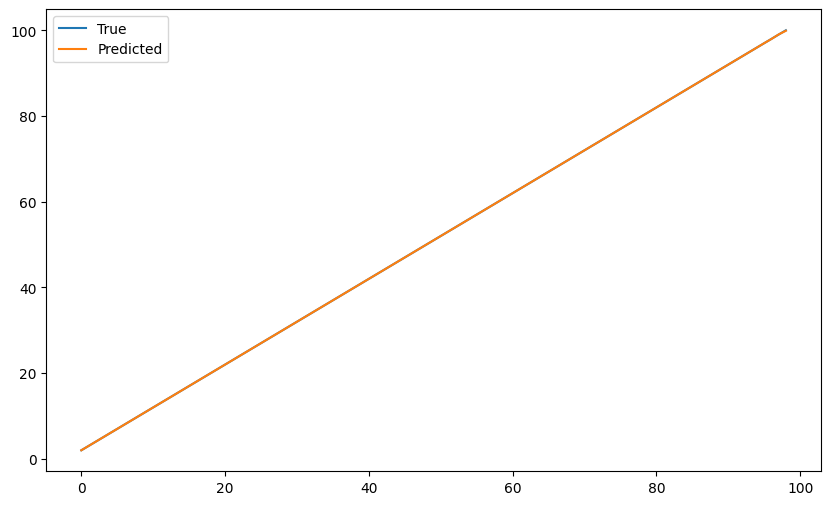

In [ ]:
# Predictions
model.eval()
with torch.no_grad():
    predictions = model(X.unsqueeze(2)).squeeze(2).numpy()
    print('Predicted output:', predictions)

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y[0].numpy(), label='True')
plt.plot(predictions[0], label='Predicted')
plt.legend()
plt.show()

In [ ]:
# Train model with look-ahead data

# Create the model and optimizer
model_ahead = SimpleRNN(input_size, hidden_size, output_size)
optimizer_ahead = torch.optim.Adam(model_ahead.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

num_epochs = 4800

# Training loop
for epoch in range(num_epochs):
    model_ahead.train()
    outputs = model_ahead(X_ahead.unsqueeze(2))  # Add a dimension for input size
    loss = criterion(outputs, y.unsqueeze(2))

    optimizer_ahead.zero_grad()
    loss.backward()
    optimizer_ahead.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/4800], Loss: 2863.6562
Epoch [20/4800], Loss: 2532.1550
Epoch [30/4800], Loss: 2322.7302
Epoch [40/4800], Loss: 2136.3254
Epoch [50/4800], Loss: 1961.7985
Epoch [60/4800], Loss: 1800.1741
Epoch [70/4800], Loss: 1648.9117
Epoch [80/4800], Loss: 1511.3274
Epoch [90/4800], Loss: 1386.2671
Epoch [100/4800], Loss: 1272.2714
Epoch [110/4800], Loss: 1168.2933
Epoch [120/4800], Loss: 1073.3287
Epoch [130/4800], Loss: 986.6097
Epoch [140/4800], Loss: 907.3944
Epoch [150/4800], Loss: 835.0025
Epoch [160/4800], Loss: 768.8140
Epoch [170/4800], Loss: 708.2715
Epoch [180/4800], Loss: 652.8710
Epoch [190/4800], Loss: 602.1540
Epoch [200/4800], Loss: 555.7051
Epoch [210/4800], Loss: 513.1467
Epoch [220/4800], Loss: 474.1352
Epoch [230/4800], Loss: 438.3578
Epoch [240/4800], Loss: 405.5298
Epoch [250/4800], Loss: 375.3929
Epoch [260/4800], Loss: 347.7127
Epoch [270/4800], Loss: 322.2757
Epoch [280/4800], Loss: 298.8878
Epoch [290/4800], Loss: 277.3726
Epoch [300/4800], Loss: 257.5690
Epoch [

In [ ]:
X_ahead[-1][-1].item()

7.0

In [ ]:
X_last = torch.tensor([[X_ahead[-1][-1].item()]], dtype=torch.float32)

In [ ]:
# Predictions
model_ahead.eval()
with torch.no_grad():
    predictions_ahead = model_ahead(X.unsqueeze(2)).squeeze(2).numpy()
    print('Predicted output:', predictions_ahead)

Predicted output: [[ 5.7900996 23.830738  31.701443  11.218626  -4.240773   4.038618
  18.308353  17.251331   8.190263   7.6778684 14.189539  17.824202
  15.411407  13.615463  16.168846  19.68839   20.213848  19.081356
  19.820091  22.454659  24.1842    23.997372  23.987251  25.710995
  27.870676  28.573208  28.37688   29.253685  31.39089   32.907917
  32.942772  33.066914  34.744473  36.925724  37.64295   37.302654
  38.05177   40.415737  42.223457  42.117016  41.789623  43.35773
  46.06632   47.18014   46.550976  46.606495  48.810223  51.341408
  51.8763    51.30103   51.835747  54.049873  56.051846  56.53753
  56.516537  57.322395  58.99099   60.470577  61.27026   61.873173
  62.77207   63.940784  65.08284   66.07445   67.007164  67.97578
  68.98506   70.000656  71.00566   72.00371   73.001236  74.000145
  74.99993   76.00009   77.00043   78.000824  79.001144  80.0014
  81.00165   82.00165   83.00087   83.99948   84.99914   86.00109
  87.00319   88.0023    88.999756  89.99919   91.0

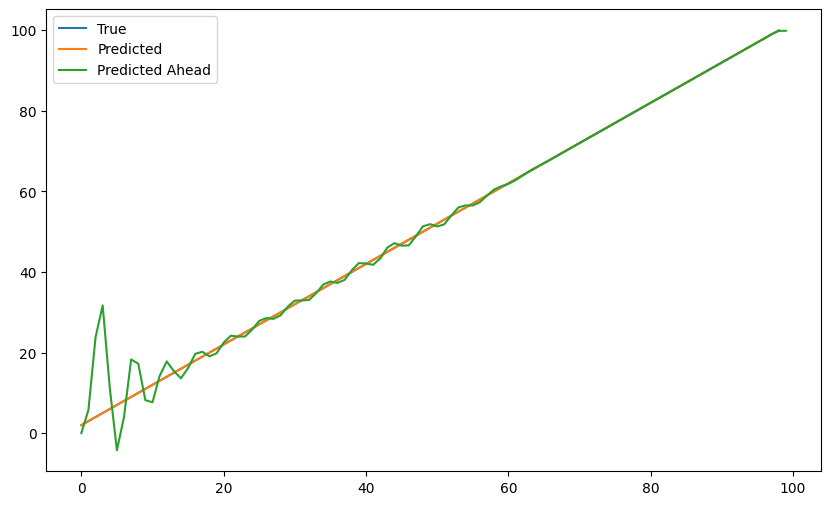

[  2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.  15.
  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.  29.
  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.  43.
  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.
  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.  71.
  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.
  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.  99.
 100.]
[ 2.0015316  2.9987879  4.001103   4.999009   6.001822   6.996242
  8.002502   8.999497  10.000341  11.003248  12.002304  12.998067
 13.995302  14.996662  16.000166  17.00255   18.002792  19.002031
 20.001339  21.00066   21.99963   22.998547  23.998108  24.998497
 25.999172  26.9996    27.99987   29.000357  30.001026  31.001383
 32.001163  33.00072   34.000507  35.000484  36.00018   36.999516
 37.99902   38.99913   39.99958   40.999733  41.99951   42.999523
 44.000156  45.00093   46.001072  

In [ ]:
placeholder = np.array([0])
predictions_ahead_plot = np.append(placeholder, predictions_ahead[0])

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(y[0].numpy(), label='True')
plt.plot(predictions[0], label='Predicted')
plt.plot(predictions_ahead_plot, label='Predicted Ahead')
plt.legend()
plt.show()

print(y[0].numpy())
print(predictions[0])
print(predictions_ahead_plot)

In [ ]:
# Now lets use stock data

In [ ]:
X_stock = data[tickers[ticker_set][single_index] + '-Close']
X_stock = list(X_stock.dropna().to_numpy())
print(X_stock)
next_day_true_price = X_stock[-100:]
X_stock = X_stock[:-100]
print(X_stock)
print(next_day_true_price)
y_stock = torch.tensor([X_stock], dtype=torch.float32)
print(X_stock)
print(len(X_stock))
X_stock.insert(0, 0)
X_stock.pop()
print(X_stock)
print(len(X_stock))
X_stock = torch.tensor([X_stock], dtype=torch.float32)

[40.585147857666016, 40.881141662597656, 41.22514724731445, 40.95314407348633, 40.88915252685547, 41.34516525268555, 41.54517364501953, 41.657169342041016, 41.95317840576172, 42.729209899902344, 44.24125289916992, 44.12923812866211, 44.473262786865234, 44.48125076293945, 44.121238708496094, 43.29722595214844, 43.30521011352539, 43.38521957397461, 43.129215240478516, 42.61720275878906, 43.20921325683594, 42.12918472290039, 42.481197357177734, 42.177188873291016, 42.177188873291016, 42.56919479370117, 43.17721939086914, 43.60922622680664, 43.04412841796875, 43.17329406738281, 43.75453567504883, 44.602176666259766, 46.894859313964844, 46.86256790161133, 46.7899169921875, 46.84642791748047, 47.20969009399414, 47.355003356933594, 48.065406799316406, 48.121917724609375, 47.65369415283203, 48.31566619873047, 47.97661590576172, 47.40343475341797, 47.298500061035156, 47.548770904541016, 47.169342041015625, 47.790924072265625, 47.0966796875, 47.5245361328125, 47.5245361328125, 47.95238494873047,

In [ ]:
print(X_stock)
print(y_stock)

tensor([[  0.0000,  40.5851,  40.8811,  ..., 100.7424, 103.2352, 102.9758]])
tensor([[ 40.5851,  40.8811,  41.2251,  ..., 103.2352, 102.9758, 105.6169]])


In [ ]:
# Create the model and optimizer
model_stock = SimpleRNN(input_size, hidden_size, output_size)
optimizer_stock = torch.optim.Adam(model_stock.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

num_epochs = 5000

# Training loop
for epoch in range(num_epochs):
    model_stock.train()
    outputs = model_stock(X_stock.unsqueeze(2))  # Add a dimension for input size
    loss = criterion(outputs, y_stock.unsqueeze(2))

    optimizer_stock.zero_grad()
    loss.backward()
    optimizer_stock.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/5000], Loss: 4696.6187
Epoch [20/5000], Loss: 4220.0552
Epoch [30/5000], Loss: 3901.6755
Epoch [40/5000], Loss: 3611.2847
Epoch [50/5000], Loss: 3331.8000
Epoch [60/5000], Loss: 3069.0139
Epoch [70/5000], Loss: 2824.1577
Epoch [80/5000], Loss: 2596.8816
Epoch [90/5000], Loss: 2386.3777
Epoch [100/5000], Loss: 2191.7397
Epoch [110/5000], Loss: 2012.0741
Epoch [120/5000], Loss: 1846.5219
Epoch [130/5000], Loss: 1694.2618
Epoch [140/5000], Loss: 1554.5079
Epoch [150/5000], Loss: 1426.5037
Epoch [160/5000], Loss: 1309.5189
Epoch [170/5000], Loss: 1202.8502
Epoch [180/5000], Loss: 1105.8179
Epoch [190/5000], Loss: 1017.7656
Epoch [200/5000], Loss: 938.0621
Epoch [210/5000], Loss: 866.1001
Epoch [220/5000], Loss: 801.2971
Epoch [230/5000], Loss: 743.0963
Epoch [240/5000], Loss: 690.9665
Epoch [250/5000], Loss: 644.4028
Epoch [260/5000], Loss: 602.9272
Epoch [270/5000], Loss: 566.0881
Epoch [280/5000], Loss: 533.4609
Epoch [290/5000], Loss: 504.6475
Epoch [300/5000], Loss: 479.2766


In [ ]:
# Pickle the object to a file
import pickle
with open("model_stock_obj2.pkl", "wb") as f:
    pickle.dump(model_stock, f)

In [ ]:
X_stock

tensor([[  0.0000,  40.5851,  40.8811,  ..., 100.7424, 103.2352, 102.9758]])

In [ ]:
# Predictions

predictions_list = []

pred_input = data[tickers[ticker_set][single_index] + '-Close']
pred_input = list(pred_input.dropna().to_numpy())
pred_input = pred_input[:-100]
pred_input.insert(0, 0)
pred_input.pop()

print(pred_input)

model_stock.eval()

with torch.no_grad():
    predictions_stock_train = model_stock(X_stock.unsqueeze(2)).squeeze(2).numpy()
    print('Predicted output:', predictions_stock_train)

for i in range(100):
  with torch.no_grad():
      pred_input_tensor = torch.tensor([pred_input], dtype=torch.float32)
      # print(pred_input)
      predictions_stock = model_stock(pred_input_tensor.unsqueeze(2)).squeeze(2).numpy()
      # print('Predicted output:', predictions_stock)
      predictions_list.append(predictions_stock[0][-1])
      pred_input = pred_input[1:]
      pred_input.append(next_day_true_price[i])

[0, 40.585147857666016, 40.881141662597656, 41.22514724731445, 40.95314407348633, 40.88915252685547, 41.34516525268555, 41.54517364501953, 41.657169342041016, 41.95317840576172, 42.729209899902344, 44.24125289916992, 44.12923812866211, 44.473262786865234, 44.48125076293945, 44.121238708496094, 43.29722595214844, 43.30521011352539, 43.38521957397461, 43.129215240478516, 42.61720275878906, 43.20921325683594, 42.12918472290039, 42.481197357177734, 42.177188873291016, 42.177188873291016, 42.56919479370117, 43.17721939086914, 43.60922622680664, 43.04412841796875, 43.17329406738281, 43.75453567504883, 44.602176666259766, 46.894859313964844, 46.86256790161133, 46.7899169921875, 46.84642791748047, 47.20969009399414, 47.355003356933594, 48.065406799316406, 48.121917724609375, 47.65369415283203, 48.31566619873047, 47.97661590576172, 47.40343475341797, 47.298500061035156, 47.548770904541016, 47.169342041015625, 47.790924072265625, 47.0966796875, 47.5245361328125, 47.5245361328125, 47.952384948730

In [ ]:
next_day_predicted_price = predictions_list[0]
print(next_day_predicted_price)
print(next_day_true_price[0])
print(predictions_list)
print(next_day_true_price)

103.21956
105.43152618408203
[103.21956, 105.040184, 105.12199, 106.42273, 103.08334, 102.58785, 103.03149, 104.67823, 103.66477, 103.61553, 103.810326, 102.26638, 103.92599, 103.44877, 103.30071, 104.32949, 104.98771, 105.70152, 105.129654, 106.0041, 105.84022, 103.51261, 103.399574, 104.048096, 103.9314, 103.373024, 102.72176, 103.477905, 104.87023, 106.16805, 107.50743, 106.12639, 105.01213, 103.667564, 104.08877, 104.74062, 104.28667, 103.42391, 100.639565, 100.63709, 101.2489, 101.0413, 100.54212, 100.53619, 100.26628, 101.29581, 101.11643, 102.403305, 101.27474, 101.40572, 101.59878, 101.08491, 102.50149, 100.92594, 100.944145, 102.77509, 105.191475, 104.23688, 104.49125, 105.54153, 104.55444, 104.81742, 103.569725, 105.48199, 105.13584, 105.32583, 104.76082, 104.96906, 104.821785, 104.203865, 105.6016, 106.5847, 107.34234, 106.9374, 106.85941, 107.99338, 109.363945, 109.6702, 109.88473, 109.74066, 109.23153, 109.751945, 111.08261, 112.66137, 113.50903, 114.013115, 114.02356, 113

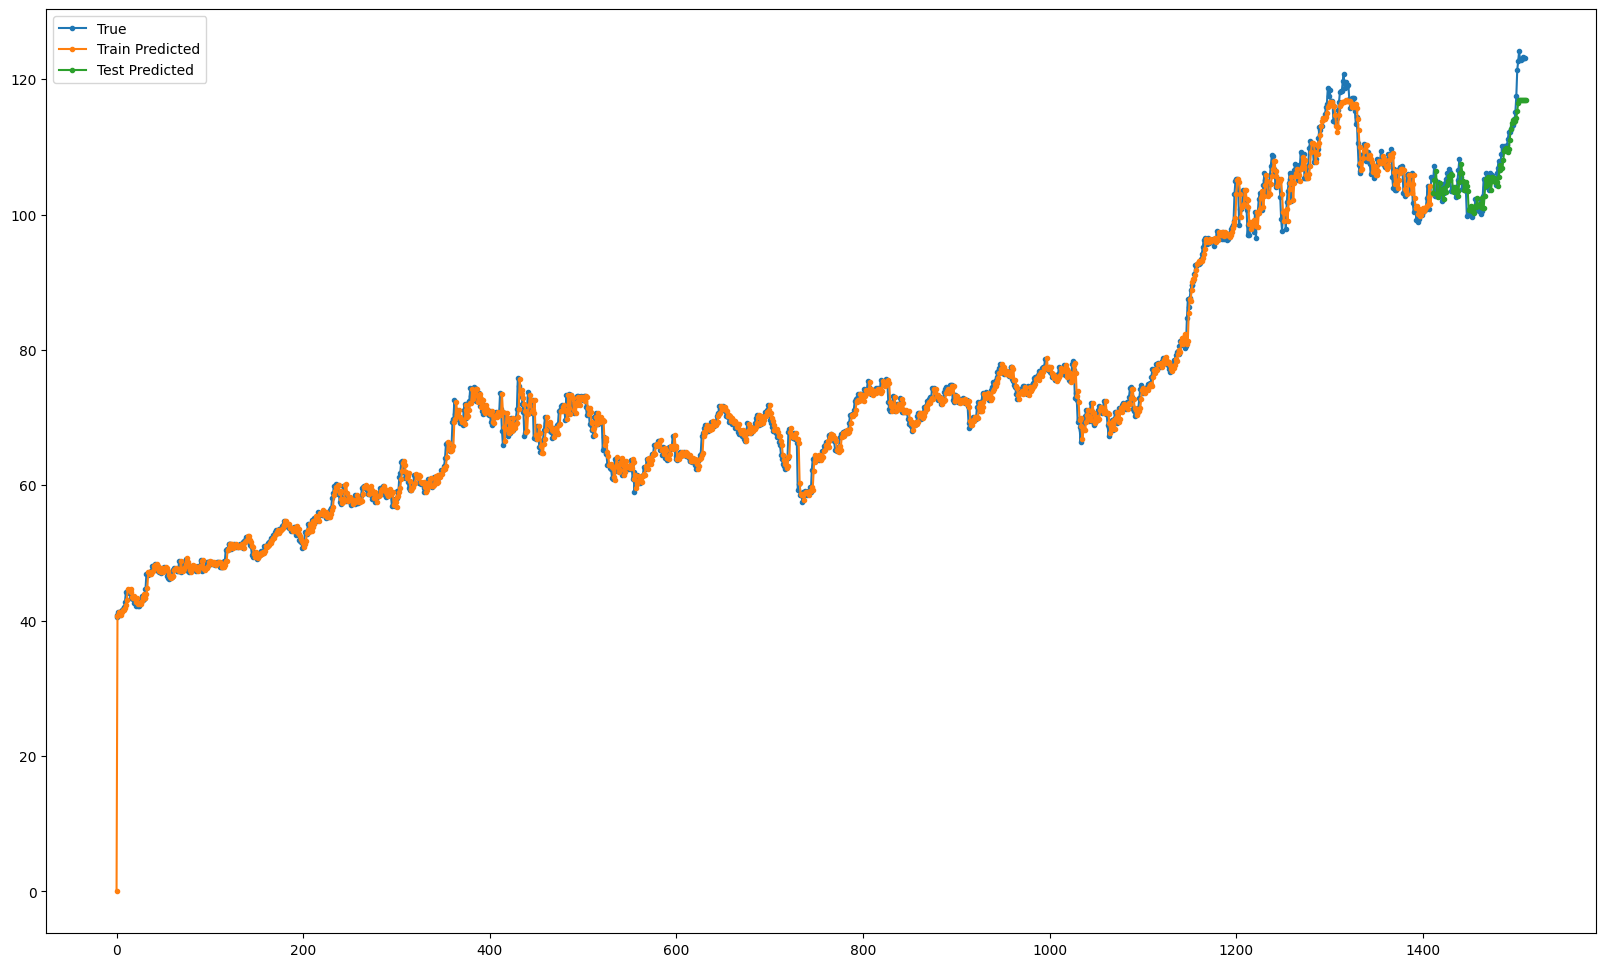

[ 40.585148  40.88114   41.225147 ... 103.23522  102.97577  105.61688 ]
[ 77.83177   89.322365  63.330513 ... 116.93645  116.94337  116.939644]
[  0.          40.70326996  40.86952209 ... 101.50641632 103.05835724
 103.21955872]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

In [ ]:
placeholder = np.array([0])
predictions_stock_plot = np.append(placeholder, predictions_stock_train[0])

predictions_future = []
for item in predictions_stock_plot:
  predictions_future.append(np.NaN)
predictions_future.extend(predictions_list)

X_stock_review = data[tickers[ticker_set][single_index] + '-Close']
X_stock_review = list(X_stock_review.dropna().to_numpy())

# Plot results
plt.figure(figsize=(20, 12))
plt.plot(X_stock_review, label='True', marker='.')
plt.plot(predictions_stock_plot, label='Train Predicted', marker='.')
plt.plot(predictions_future, label='Test Predicted', marker='.')
plt.legend()
plt.show()

print(y_stock[0].numpy())
print(predictions_stock[0])
print(predictions_stock_plot)
print(predictions_future)
print(next_day_true_price)

In [ ]:
from sklearn.metrics import mean_squared_error
print('True:', next_day_true_price)
print('Predicted:', predictions_list)
print('MSE Loss:', mean_squared_error(next_day_true_price, predictions_list))

True: [105.43152618408203, 105.27399444580078, 107.2200698852539, 102.7795639038086, 102.7236557006836, 102.99388885498047, 104.86703491210938, 103.45052337646484, 103.869873046875, 104.0096664428711, 102.05268096923828, 104.16807556152344, 103.18959045410156, 103.41324615478516, 104.60609436035156, 105.27705383300781, 106.19963836669922, 105.53800201416016, 106.79606628417969, 106.28350830078125, 103.50643157958984, 103.53440856933594, 104.08419799804688, 103.87920379638672, 103.33869171142578, 102.63044738769531, 103.55305480957031, 105.04408264160156, 106.56306457519531, 108.24981689453125, 106.40465545654297, 105.53800201416016, 103.80467224121094, 104.20536041259766, 104.7179183959961, 104.21468353271484, 103.40393829345703, 99.71359252929688, 99.98384094238281, 100.83186340332031, 100.4870834350586, 99.8906478881836, 99.9931640625, 99.63905334472656, 100.98098754882812, 100.55231475830078, 102.22975158691406, 100.59890747070312, 101.07417297363281, 101.2419204711914, 100.56164550

In [ ]:
# Lets use scheduled sampling

# Create the model and optimizer
model_stock = SimpleRNN(input_size, hidden_size, output_size)
optimizer_stock = torch.optim.Adam(model_stock.parameters(), lr=learning_rate)
criterion = nn.MSELoss()

num_epochs = 5000

def decay():
  pass


# Training loop
for epoch in range(num_epochs):
    model_stock.train()
    outputs = model_stock(X_stock.unsqueeze(2))  # Add a dimension for input size
    loss = criterion(outputs, y_stock.unsqueeze(2))

    optimizer_stock.zero_grad()
    loss.backward()
    optimizer_stock.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

In [ ]:
def scheduled_sampling(model, inputs, targets, current_step, max_steps, sample_prob):
    outputs = []
    hidden = torch.zeros(1, hidden_size)
    for i in range(sequence_length):
        if torch.rand(1) < sample_prob(current_step, max_steps):
            input_tensor = model.predict(inputs[:, i])  # Model's previous prediction
        else:
            input_tensor = targets[:, i]
        output, hidden = model(input_tensor, hidden)
        outputs.append(output)
    return outputs

# Training loop
for epoch in range(epochs):
    for batch in data_loader:
        inputs, targets = batch
        # Calculate sampling probability based on current step
        sample_prob = ...
        outputs = scheduled_sampling(model, inputs, targets, current_step, max_steps, sample_prob)
        loss = calculate_loss(outputs, targets)
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_step += 1

## Model creation (LLY, ABBV, MRK)

## LLY Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model_LLY = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model_LLY.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model_LLY.fit(train_data_LLY['X'], train_data_LLY['y'], validation_data=(val_data_LLY['X'], val_data_LLY['y']), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 60ms/step - loss: 55846.4688 - mean_absolute_error: 234.6212 - val_loss: 59464.1914 - val_mean_absolute_error: 243.7580
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 54757.8633 - mean_absolute_error: 232.2946 - val_loss: 59151.0156 - val_mean_absolute_error: 243.1148
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 54510.7891 - mean_absolute_error: 231.7880 - val_loss: 58814.7305 - val_mean_absolute_error: 242.4222
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 53895.9531 - mean_absolute_error: 230.4114 - val_loss: 58370.7539 - val_mean_absolute_error: 241.5046
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 53119.3867 - mean_absolute_error: 228.6355 - val_loss: 57742.3398 - val_mean_absolute_error: 240.2001
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 52534.6562 - mean_absolute_error: 227.4007 - val_loss: 56865.1719 - val_mean_absolute_error: 238.3668
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/

## ABBV Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model_ABBV = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model_ABBV.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model_ABBV.fit(train_data_ABBV['X'], train_data_ABBV['y'], validation_data=(val_data_ABBV['X'], val_data_ABBV['y']), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 13390.1182 - mean_absolute_error: 115.4673 - val_loss: 18838.3047 - val_mean_absolute_error: 137.2044
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 13137.4609 - mean_absolute_error: 114.3818 - val_loss: 18710.1719 - val_mean_absolute_error: 136.7367
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 13149.8721 - mean_absolute_error: 114.4501 - val_loss: 18556.9102 - val_mean_absolute_error: 136.1752
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 12889.3730 - mean_absolute_error: 113.3291 - val_loss: 18373.2695 - val_mean_absolute_error: 135.4992
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 12825.4580 - mean_absolute_error: 113.0359 - val_loss: 18138.7793 - val_mean_absolute_error: 134.6310
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 12521.2559 - mean_absolute_error: 111.6726 - val_loss: 17807.8867 - val_mean_absolute_error: 133.3961
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9

## MRK Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model_MRK = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model_MRK.compile(loss='mse',
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model_MRK.fit(train_data_MRK['X'], train_data_MRK['y'], validation_data=(val_data_MRK['X'], val_data_MRK['y']), epochs=100)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 93ms/step - loss: 5874.1235 - mean_absolute_error: 76.5647 - val_loss: 6348.1006 - val_mean_absolute_error: 79.6508
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5855.3276 - mean_absolute_error: 76.4382 - val_loss: 6309.9312 - val_mean_absolute_error: 79.4109
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5817.7959 - mean_absolute_error: 76.1993 - val_loss: 6270.1182 - val_mean_absolute_error: 79.1598
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 5780.0796 - mean_absolute_error: 75.9479 - val_loss: 6217.7744 - val_mean_absolute_error: 78.8284
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 5695.6802 - mean_absolute_error: 75.3836 - val_loss: 6150.2686 - val_mean_absolute_error: 78.3991
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5664.0625 - mean_absolute_error: 75.1625 - val_loss: 6065.6646 - val_mean_absolute_error: 77.8576
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 5558.03

## Making Predictions (LLY)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


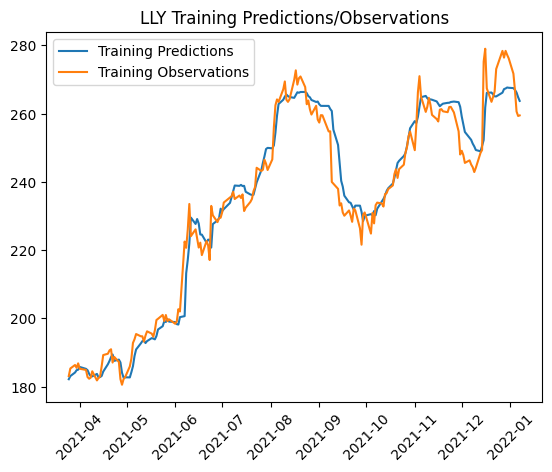

In [ ]:
train_predictions_LLY = model_LLY.predict(train_data_LLY['X']).flatten()

plt.plot(train_data_LLY['dates'], train_predictions_LLY)
plt.plot(train_data_LLY['dates'], train_data_LLY['y'])
plt.xticks(rotation=45)
plt.title("LLY Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


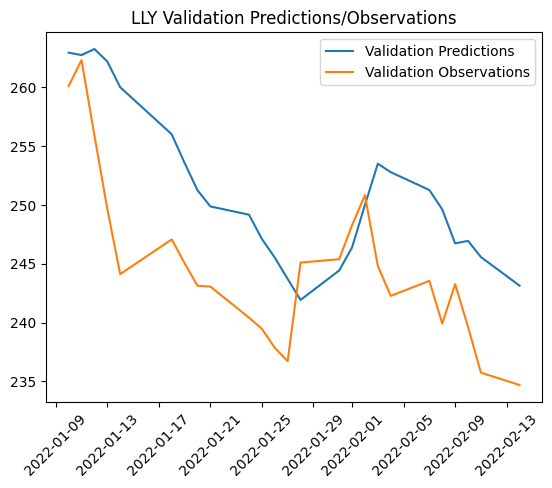

In [ ]:
val_predictions_LLY = model_LLY.predict(val_data_LLY['X']).flatten()

plt.plot(val_data_LLY['dates'], val_predictions_LLY)
plt.plot(val_data_LLY['dates'], val_data_LLY['y'])
plt.xticks(rotation=45)
plt.title("LLY Validation Predictions/Observations")
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


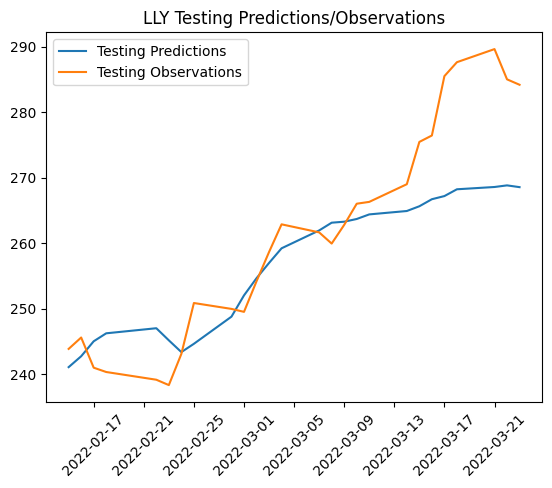

In [ ]:
test_predictions_LLY= model_LLY.predict(test_data_LLY['X']).flatten()

plt.plot(test_data_LLY['dates'], test_predictions_LLY)
plt.plot(test_data_LLY['dates'], test_data_LLY['y'])
plt.xticks(rotation=45)
plt.title("LLY Testing Predictions/Observations")
plt.legend(['Testing Predictions', 'Testing Observations'])

## Overall Prediction

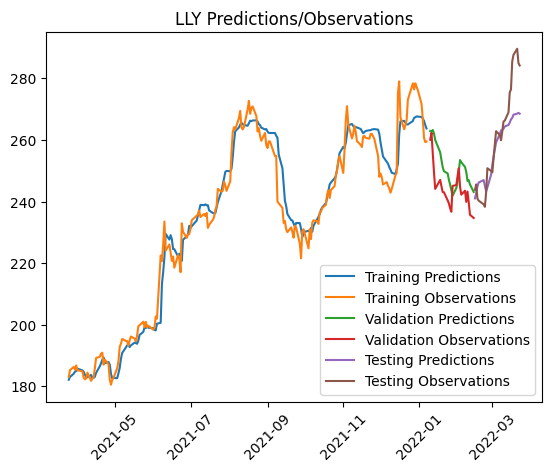

In [ ]:
plt.plot(train_data_LLY['dates'], train_predictions_LLY)
plt.plot(train_data_LLY['dates'], train_data_LLY['y'])
plt.plot(val_data_LLY['dates'], val_predictions_LLY)
plt.plot(val_data_LLY['dates'], val_data_LLY['y'])
plt.plot(test_data_LLY['dates'], test_predictions_LLY)
plt.plot(test_data_LLY['dates'], test_data_LLY['y'])
plt.xticks(rotation=45)
plt.title("LLY Predictions/Observations")
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

## Making Predictions (ABBV)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


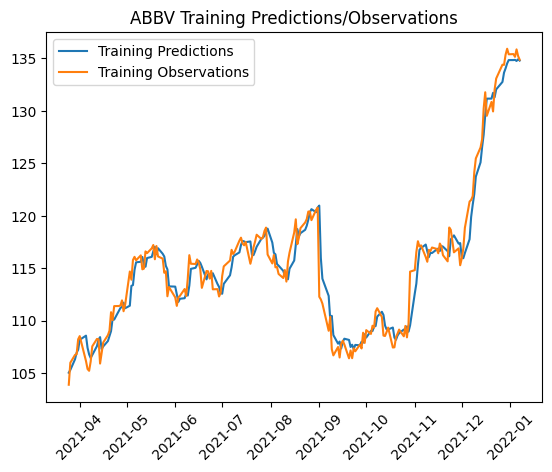

In [ ]:
train_predictions_ABBV = model_ABBV.predict(train_data_ABBV['X']).flatten()

plt.plot(train_data_ABBV['dates'], train_predictions_ABBV)
plt.plot(train_data_ABBV['dates'], train_data_ABBV['y'])
plt.xticks(rotation=45)
plt.title("ABBV Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


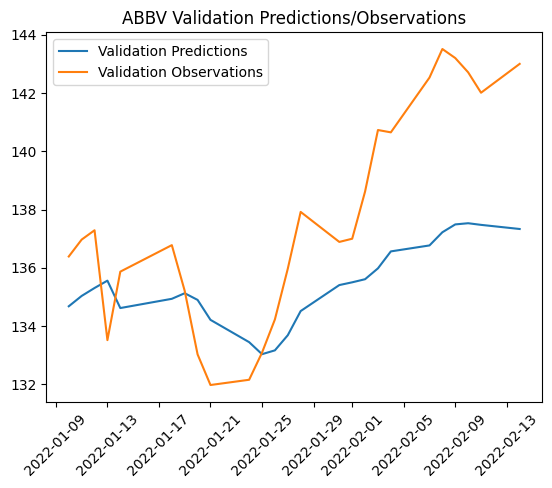

In [ ]:
val_predictions_ABBV = model_ABBV.predict(val_data_ABBV['X']).flatten()

plt.plot(val_data_ABBV['dates'], val_predictions_ABBV)
plt.plot(val_data_ABBV['dates'], val_data_ABBV['y'])
plt.xticks(rotation=45)
plt.title("ABBV Validation Predictions/Observations")
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


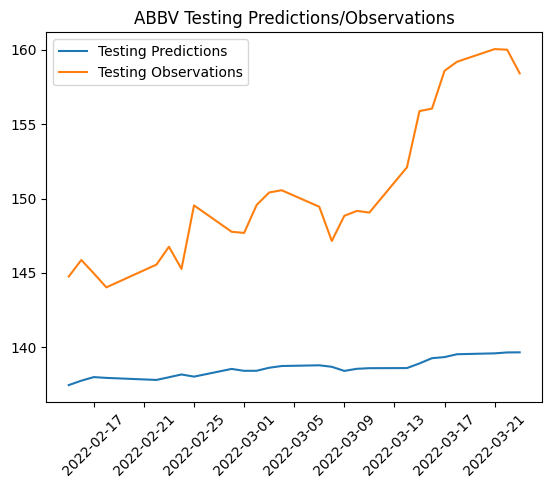

In [ ]:
test_predictions_ABBV= model_ABBV.predict(test_data_ABBV['X']).flatten()

plt.plot(test_data_ABBV['dates'], test_predictions_ABBV)
plt.plot(test_data_ABBV['dates'], test_data_ABBV['y'])
plt.xticks(rotation=45)
plt.title("ABBV Testing Predictions/Observations")
plt.legend(['Testing Predictions', 'Testing Observations'])

## Overall Prediction

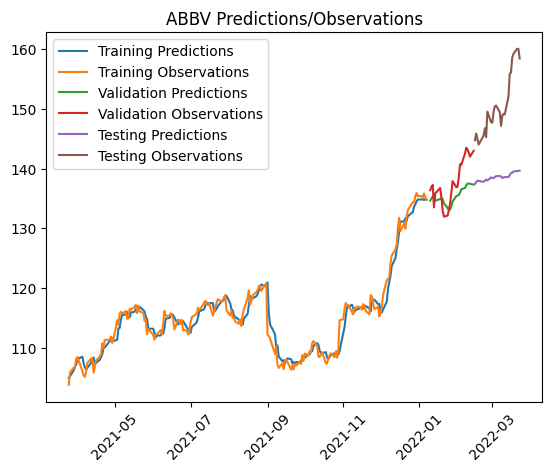

In [ ]:
plt.plot(train_data_ABBV['dates'], train_predictions_ABBV)
plt.plot(train_data_ABBV['dates'], train_data_ABBV['y'])
plt.plot(val_data_ABBV['dates'], val_predictions_ABBV)
plt.plot(val_data_ABBV['dates'], val_data_ABBV['y'])
plt.plot(test_data_ABBV['dates'], test_predictions_ABBV)
plt.plot(test_data_ABBV['dates'], test_data_ABBV['y'])
plt.xticks(rotation=45)
plt.title("ABBV Predictions/Observations")
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

## Making Predictions (MRK)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


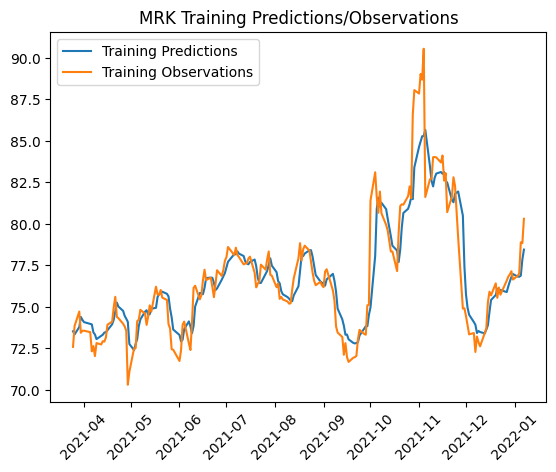

In [ ]:
train_predictions_MRK = model_MRK.predict(train_data_MRK['X']).flatten()

plt.plot(train_data_MRK['dates'], train_predictions_MRK)
plt.plot(train_data_MRK['dates'], train_data_MRK['y'])
plt.xticks(rotation=45)
plt.title("MRK Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


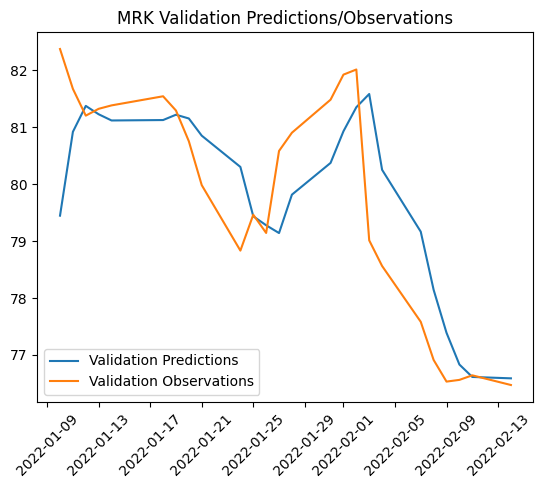

In [ ]:
val_predictions_MRK = model_MRK.predict(val_data_MRK['X']).flatten()

plt.plot(val_data_MRK['dates'], val_predictions_MRK)
plt.plot(val_data_MRK['dates'], val_data_MRK['y'])
plt.xticks(rotation=45)
plt.title("MRK Validation Predictions/Observations")
plt.legend(['Validation Predictions', 'Validation Observations'])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


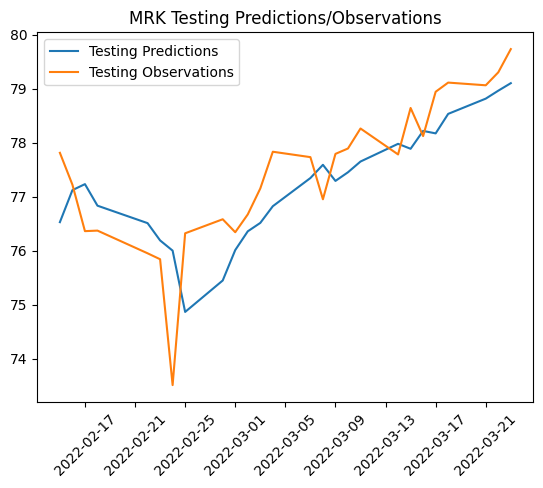

In [ ]:
test_predictions_MRK= model_MRK.predict(test_data_MRK['X']).flatten()

plt.plot(test_data_MRK['dates'], test_predictions_MRK)
plt.plot(test_data_MRK['dates'], test_data_MRK['y'])
plt.xticks(rotation=45)
plt.title("MRK Testing Predictions/Observations")
plt.legend(['Testing Predictions', 'Testing Observations'])

## Overall Prediction

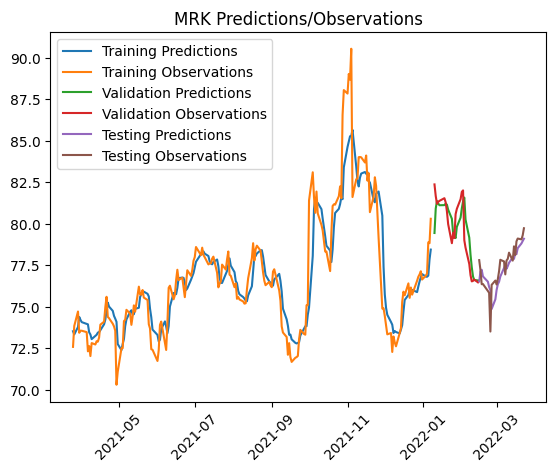

In [ ]:
plt.plot(train_data_MRK['dates'], train_predictions_MRK)
plt.plot(train_data_MRK['dates'], train_data_MRK['y'])
plt.plot(val_data_MRK['dates'], val_predictions_MRK)
plt.plot(val_data_MRK['dates'], val_data_MRK['y'])
plt.plot(test_data_MRK['dates'], test_predictions_MRK)
plt.plot(test_data_MRK['dates'], test_data_MRK['y'])
plt.xticks(rotation=45)
plt.title("MRK Predictions/Observations")
plt.legend(['Training Predictions',
            'Training Observations',
            'Validation Predictions',
            'Validation Observations',
            'Testing Predictions',
            'Testing Observations'])

In [ ]:
# Step 5: Build LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer for predicted price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Set up callbacks: EarlyStopping and ModelCheckpoint
checkpoint_path = "best_model.keras"  # Save model with the .keras extension
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(
    filepath=checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Step 6: Train the Model with Callbacks
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=20,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, model_checkpoint]
)

Epoch 1/20
29/30 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.0475
Epoch 1: val_loss improved from inf to 0.01036, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - loss: 0.0459 - val_loss: 0.0104
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 0.0073
Epoch 2: val_loss improved from 0.01036 to 0.00823, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0073 - val_loss: 0.0082
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0047
Epoch 3: val_loss improved from 0.00823 to 0.00428, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - loss: 0.0047 - val_loss: 0.0043
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0039
Epoch 4: val_loss did not improve from 0.00428
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0039 - val_loss: 0.0075
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0037
Epoch 5: val_loss improved from 0.00428 to 0.00361, saving model to best_m

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Training Loss (MSE): 0.001496272161602974
Testing Loss (MSE): 0.0024323591496795416
Mean Squared Error (Test Set): 2.1173090656032216


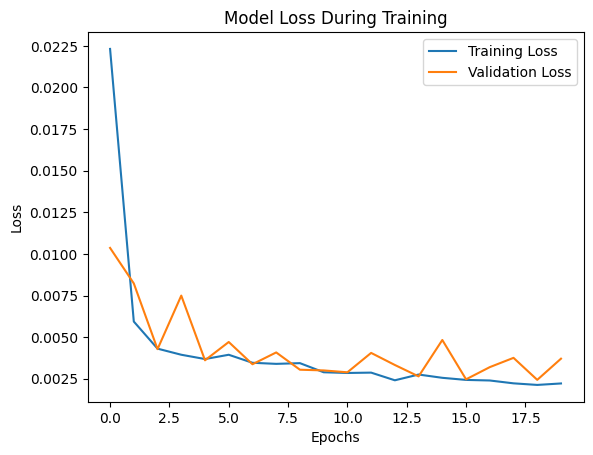

In [ ]:
# Step 7: Evaluate the Model
# Load the best model
model.load_weights(checkpoint_path)
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

# Predict and calculate MSE
predictions = model.predict(X_test)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_original = scaler.inverse_transform(predictions)
mse = mean_squared_error(y_test_original, predictions_original)

# Print metrics
print(f"Training Loss (MSE): {train_loss}")
print(f"Testing Loss (MSE): {test_loss}")
print(f"Mean Squared Error (Test Set): {mse}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Tested on data from 2015-01-01 to 2018-12-31 for predictions from 2018-12-31 to 2020-01-01
      


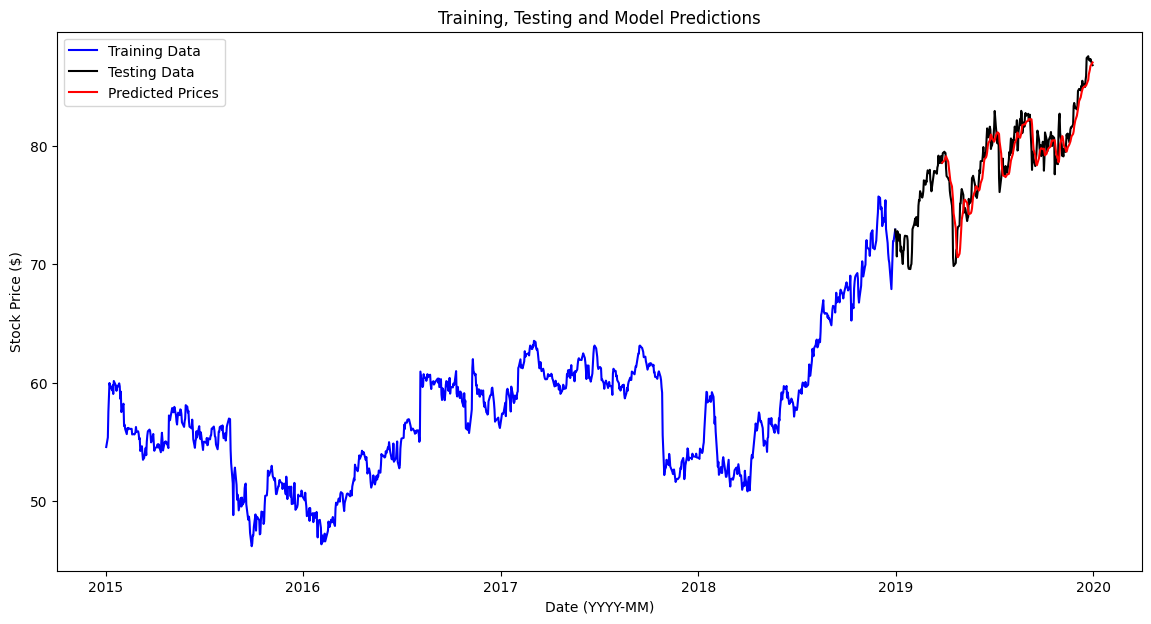

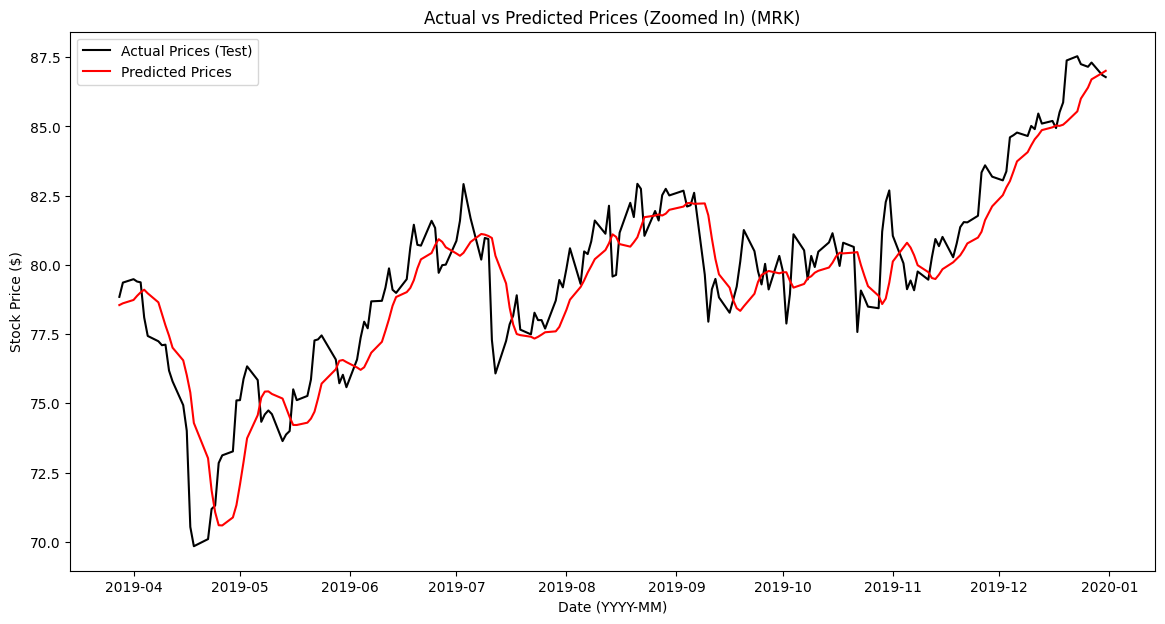

In [ ]:
# Step 8: Predict and Visualize
print(f"""
Tested on data from {start_date} to {train_end_date} for predictions from {train_end_date} to {end_date}
      """)

# Convert training and testing data back to original scale for visualization
train_original = scaler.inverse_transform(scaled_train_data)
test_original = scaler.inverse_transform(scaled_test_data)

# Plot the training and testing data
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_original, label="Training Data", color="blue")
plt.plot(test_data.index, test_original, label="Testing Data", color="black")
plt.plot(test_data.index[sequence_length:], predictions_original, label="Predicted Prices", color="red")
plt.title("Training, Testing and Model Predictions")
plt.xlabel("Date (YYYY-MM)")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()

# Overlay predictions on test data
plt.figure(figsize=(14, 7))
plt.plot(test_data.index[sequence_length:], y_test_original, label="Actual Prices (Test)", color="black")
plt.plot(test_data.index[sequence_length:], predictions_original, label="Predicted Prices", color="red")
plt.title(f"Actual vs Predicted Prices (Zoomed In) ({symbol})")
plt.xlabel("Date (YYYY-MM)")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()


## Feature Selection and Hyperparamter Tuning

## Feature selection

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

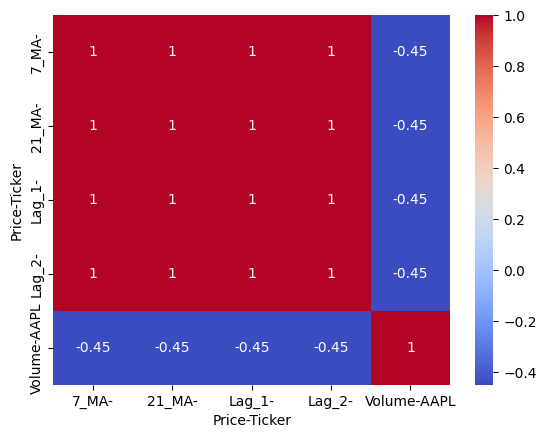

In [ ]:

X = data[['7_MA', '21_MA', 'Lag_1', 'Lag_2', 'Volume']]  # features

correlation_matrix = X.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()


In [ ]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
# we are fitting a random forest model to view the  feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# features
importances = rf_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
print(feature_importance)



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


          Feature  Importance
2       (Lag_1, )    0.763233
0        (7_MA, )    0.161521
3       (Lag_2, )    0.064243
1       (21_MA, )    0.010880
4  (Volume, AAPL)    0.000123


In [ ]:
0.763233 + 0.161521

0.9247540000000001

### Let's see what happens with these new features we select

In [ ]:
stock_name = "AAPL"
# YYYY-MM-DD
start_date = "2000-01-01"
end_date = "2020-01-01"

data = yf.download(stock_name, start=start_date, end=end_date)

# feature engineering

# using 7-day and 21-day Moving Averages
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()

# feature engineering: lagging values of closing price
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X = data[['Lag_1', '7_MA']]
y = data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order

# scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# create MLP model
mlp_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train_scaled.shape[1]),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)  # output
])


mlp_model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])

# train model
history = mlp_model.fit(
    X_train_scaled, y_train,
    validation_data=(X_test_scaled, y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)


[*********************100%***********************]  1 of 1 completed

Epoch 1/100



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


126/126 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 110.6307 - mae: 6.7063 - val_loss: 14.5781 - val_mae: 3.2315
Epoch 2/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.2928 - mae: 0.3921 - val_loss: 2.9353 - val_mae: 1.2721
Epoch 3/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0553 - mae: 0.1421 - val_loss: 2.9871 - val_mae: 1.2854
Epoch 4/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0511 - mae: 0.1356 - val_loss: 2.9800 - val_mae: 1.2841
Epoch 5/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0538 - mae: 0.1296 - val_loss: 3.0677 - val_mae: 1.3093
Epoch 6/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0550 - mae: 0.1331 - val_loss: 2.3611 - val_mae: 1.1262
Epoch 7/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0505 - mae: 0.1293 - val_loss: 2.3547 - val_mae: 1.1289
Epoch 8/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0506 - mae: 0.1271 - val_loss: 2.5445 - val_mae: 1.1707
Epoch 9/100
126/126 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lo

In [ ]:
# model evalulation here
y_pred = mlp_model.predict(X_test_scaled).flatten()

# check errors again
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE): 0.4968101381759585
Mean Absolute Error (MAE): 0.48278857656157503


I ran a few tests to see which hyperpameters improved the model. This seems to have resulted in the lowest error of all models so far. We will try to gridsearch and find better hyperparemters as a result. See my notes for past attempts and history.


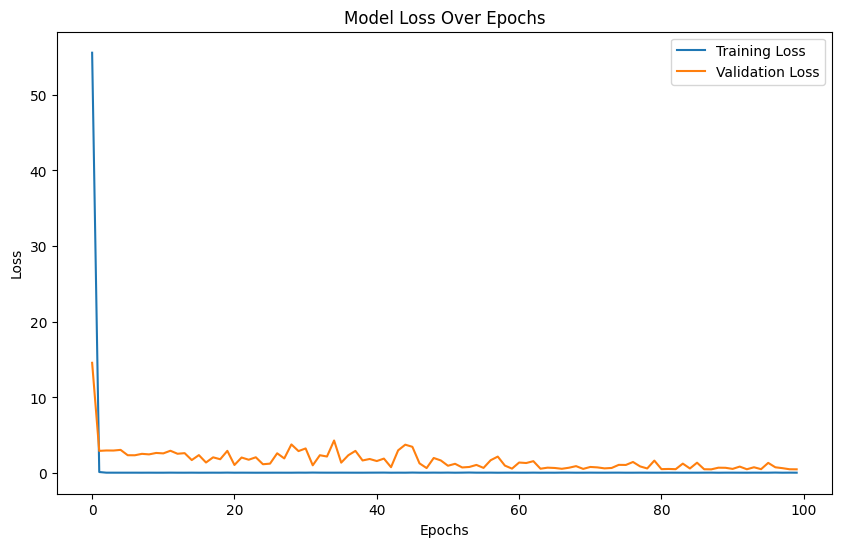

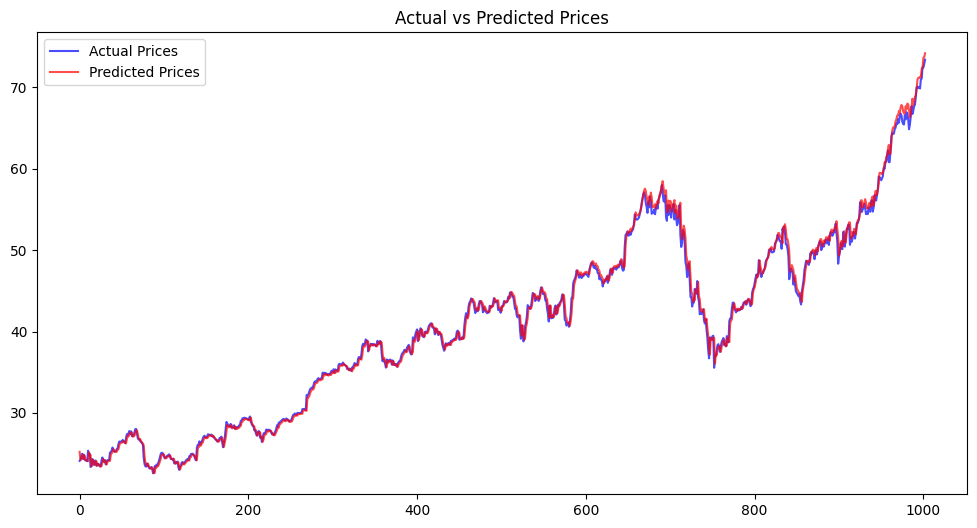

In [ ]:
# visulize the training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue', alpha=0.7)
plt.plot(y_pred, label='Predicted Prices', color='red', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Prices')
plt.show()

### Fine tuning hyperparmeters

In [ ]:
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, mean_squared_error
from scipy.stats import uniform, randint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam, SGD

# want to create the MLP model with hyperparameters
def create_mlp_model(optimizer='adam', learning_rate=0.001, layer_size=(128, 64, 32)):
    # we map the optimizer string to actual optimizer class
    if optimizer == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)

    model = Sequential()
    model.add(Dense(layer_size[0], activation='relu', input_dim=X_train_scaled.shape[1]))
    model.add(Dense(layer_size[1], activation='relu'))
    model.add(Dense(layer_size[2], activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# feature scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# put model in keras wrap
mlp_model = KerasRegressor(model=create_mlp_model, verbose=0)

# hyperparameter grid
param_dist = {
    'optimizer': ['adam', 'sgd'],  # optimizers
    'model__learning_rate': uniform(0.0001, 0.1),  # learning rate values from 0.0001 to 0.1
    'batch_size': randint(16, 128),
    'epochs': [50, 100, 150],
    'model__layer_size': [(128, 64, 32), (256, 128, 64), (64, 32, 16)],  # the different layer sizes
}

# we define the scoring function for regression (Negative MSE)
mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# using RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=mlp_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    verbose=1,
    n_jobs=-1,
    scoring=mse_scorer
)

# search
random_search.fit(X_train_scaled, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best score found: ", random_search.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best parameters found:  {'batch_size': 89, 'epochs': 50, 'model__layer_size': (64, 32, 16), 'model__learning_rate': 0.030352075650423926, 'optimizer': 'sgd'}
Best score found:  -0.39424621691604567


In [ ]:
# gett the best parameters and model
best_params_random = random_search.best_params_
best_model_random = random_search.best_estimator_
print(f"Best hyperparameters from RandomizedSearch: {best_params_random}")
print(f"Best best_model_random : {best_model_random}")

Best hyperparameters from RandomizedSearch: {'batch_size': 89, 'epochs': 50, 'model__layer_size': (64, 32, 16), 'model__learning_rate': 0.030352075650423926, 'optimizer': 'sgd'}
Best best_model_random : KerasRegressor(
	model=<function create_mlp_model at 0x7ad41fc8cd30>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=sgd
	loss=None
	metrics=None
	batch_size=89
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=50
	model__layer_size=(64, 32, 16)
	model__learning_rate=0.030352075650423926
)


testing the bets hyperparameters found

In [ ]:
import numpy as np

# troubleshooting here, checking for any NaN in the data
print(np.isnan(X_train_scaled).any())  # check for NaN in features
print(np.isinf(X_train_scaled).any())
print(np.isnan(y_train).any())  # checking in target
print(np.isinf(y_train).any())


False
False
Ticker
AAPL    False
dtype: bool
Ticker
AAPL    False
dtype: bool


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# have model make predictions
y_pred = mlp_model.predict(X_test_scaled)

# calculatiung the errors
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)


print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)


In [ ]:
# model evaluation
y_pred = mlp_model.predict(X_test_scaled).flatten()

# we print out the errors
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")


In [ ]:
# feature engineering

# using 7-day and 21-day Moving Averages
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()

print(data.head)

# feature engineering: lagging values of closing price
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

print(data.head)

<bound method NDFrame.head of Price       Adj Close      Close       High        Low       Open     Volume  \
Ticker           GOOG       GOOG       GOOG       GOOG       GOOG       GOOG   
Date                                                                           
2004-08-19   2.490186   2.499133   2.591785   2.390042   2.490664  897427216   
2004-08-20   2.687981   2.697639   2.716817   2.503118   2.515820  458857488   
2004-08-23   2.715032   2.724787   2.826406   2.716070   2.758411  366857939   
2004-08-24   2.602608   2.611960   2.779581   2.579581   2.770615  306396159   
2004-08-25   2.630652   2.640104   2.689918   2.587302   2.614201  184645512   
...               ...        ...        ...        ...        ...        ...   
2019-12-24  66.937492  67.178001  67.513000  67.139000  67.425003    6950000   
2019-12-26  67.776474  68.019997  68.066353  67.223503  67.308502   13350000   
2019-12-27  67.352493  67.594498  68.226501  67.465500  68.149498   20768000   
2019-12-30

In [ ]:
# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X_goog = data[['Lag_1', '7_MA']]
y_goog = data['Close']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order


In [ ]:
# feature engineering

# using 7-day and 21-day Moving Averages
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()

# feature engineering: lagging values of closing price
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X = data[['7_MA', '21_MA', 'Lag_1', 'Lag_2', 'Volume']]
y = data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order

# feature scalings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Evaluate the previously trained model from Apple to new stock, GOOG
y_pred = mlp_model.predict(X_goog).flatten()

# Calculate error metrics
mse = mean_squared_error(y_goog, y_pred)
mae = mean_absolute_error(y_goog, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 71813.73031221946
Mean Absolute Error (MAE): 222.9393575257777


In [ ]:
# feature engineering

# using 7-day and 21-day Moving Averages
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()

print(data.head)

# feature engineering: lagging values of closing price
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

print(data.head)

<bound method NDFrame.head of Price      Adj Close     Close      High       Low      Open     Volume  \
Ticker          NVDA      NVDA      NVDA      NVDA      NVDA       NVDA   
Date                                                                      
2000-01-03  0.089440  0.097526  0.099219  0.091927  0.098438  300912000   
2000-01-04  0.087052  0.094922  0.096094  0.090104  0.095833  300480000   
2000-01-05  0.084186  0.091797  0.093750  0.090495  0.092188  188352000   
2000-01-06  0.078692  0.085807  0.091797  0.082292  0.091797  120480000   
2000-01-07  0.080007  0.087240  0.088151  0.084115  0.085417   71184000   
...              ...       ...       ...       ...       ...        ...   
2019-12-24  5.940596  5.965500  5.982750  5.920500  5.955000  138864000   
2019-12-26  5.954786  5.979750  6.008000  5.950000  5.969000  182852000   
2019-12-27  5.897027  5.921750  6.008500  5.895250  5.995000  254644000   
2019-12-30  5.783753  5.808000  5.905000  5.776500  5.899750  25805600

In [ ]:
# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X_nvda = data[['Lag_1', '7_MA']]
y_nvda = data['Close']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order


In [ ]:
# feature engineering

# using 7-day and 21-day Moving Averages
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()

# feature engineering: lagging values of closing price
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X = data[['7_MA', '21_MA', 'Lag_1', 'Lag_2', 'Volume']]
y = data['Close']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order

# feature scalings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


## Model Results

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_test)
    test_loss = criterion(predictions, y_test)
    print(f"Test Loss: {test_loss.item()}")

# Reverse scaling for interpretability
predicted_prices = scaler.inverse_transform(predictions.numpy())
actual_prices = scaler.inverse_transform(y_test.numpy())


Test Loss: 0.008322750218212605


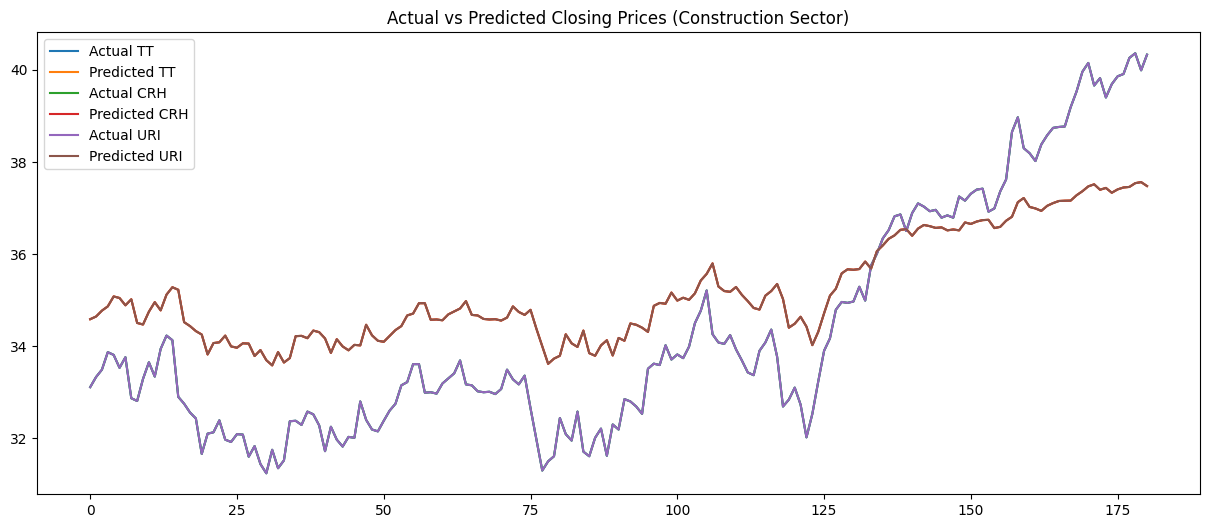

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))
# Iterate through the selected tickers instead of all tickers
for i, ticker in enumerate(tickers[selected_ticker_set]):
    # Plot only the first column (index 0) since there's only one stock
    plt.plot(actual_prices[:, 0], label=f"Actual {ticker}")
    plt.plot(predicted_prices[:, 0], label=f"Predicted {ticker}")
plt.legend()
plt.title("Actual vs Predicted Closing Prices (Construction Sector)")
plt.show()


Using the model trained on Apple stock (technology industry) and to predict Google stock (technology industry)




In [ ]:
# downloading stock data

stock_name = "GOOG"
# YYYY-MM-DD
start_date = "2000-01-01"
end_date = "2020-01-01"

data = yf.download(stock_name, start=start_date, end=end_date)
print()
print(data.head())
print(data.shape)


[*********************100%***********************]  1 of 1 completed


Price      Adj Close     Close      High       Low      Open     Volume
Ticker          GOOG      GOOG      GOOG      GOOG      GOOG       GOOG
Date                                                                   
2004-08-19  2.490186  2.499133  2.591785  2.390042  2.490664  897427216
2004-08-20  2.687981  2.697639  2.716817  2.503118  2.515820  458857488
2004-08-23  2.715032  2.724787  2.826406  2.716070  2.758411  366857939
2004-08-24  2.602608  2.611960  2.779581  2.579581  2.770615  306396159
2004-08-25  2.630652  2.640104  2.689918  2.587302  2.614201  184645512
(3869, 6)


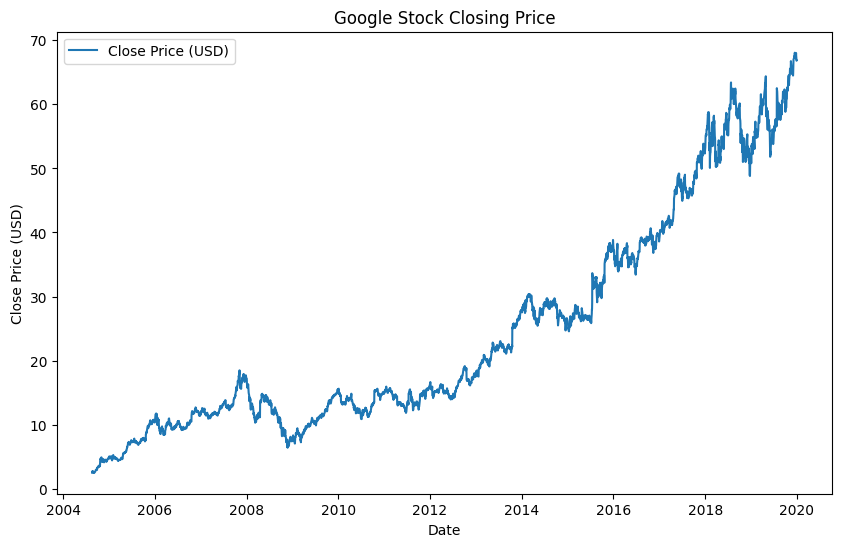

In [ ]:
# visualize data we loaded in
# plot closing price
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price (USD)')
plt.title('Google Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

In [ ]:
# feature engineering

# using 7-day and 21-day Moving Averages
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()

print(data.head)

# feature engineering: lagging values of closing price
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

print(data.head)

<bound method NDFrame.head of Price       Adj Close      Close       High        Low       Open     Volume  \
Ticker           GOOG       GOOG       GOOG       GOOG       GOOG       GOOG   
Date                                                                           
2004-08-19   2.490186   2.499133   2.591785   2.390042   2.490664  897427216   
2004-08-20   2.687981   2.697639   2.716817   2.503118   2.515820  458857488   
2004-08-23   2.715032   2.724787   2.826406   2.716070   2.758411  366857939   
2004-08-24   2.602608   2.611960   2.779581   2.579581   2.770615  306396159   
2004-08-25   2.630652   2.640104   2.689918   2.587302   2.614201  184645512   
...               ...        ...        ...        ...        ...        ...   
2019-12-24  66.937492  67.178001  67.513000  67.139000  67.425003    6950000   
2019-12-26  67.776474  68.019997  68.066353  67.223503  67.308502   13350000   
2019-12-27  67.352493  67.594498  68.226501  67.465500  68.149498   20768000   
2019-12-30

In [ ]:
# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X_goog = data[['Lag_1', '7_MA']]
y_goog = data['Close']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order


In [ ]:
# feature engineering

# using 7-day and 21-day Moving Averages
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()

# feature engineering: lagging values of closing price
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X = data[['7_MA', '21_MA', 'Lag_1', 'Lag_2', 'Volume']]
y = data['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order

# feature scalings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Evaluate the previously trained model from Apple to new stock, GOOG
y_pred = mlp_model.predict(X_goog).flatten()

# Calculate error metrics
mse = mean_squared_error(y_goog, y_pred)
mae = mean_absolute_error(y_goog, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 71813.73031221946
Mean Absolute Error (MAE): 222.9393575257777


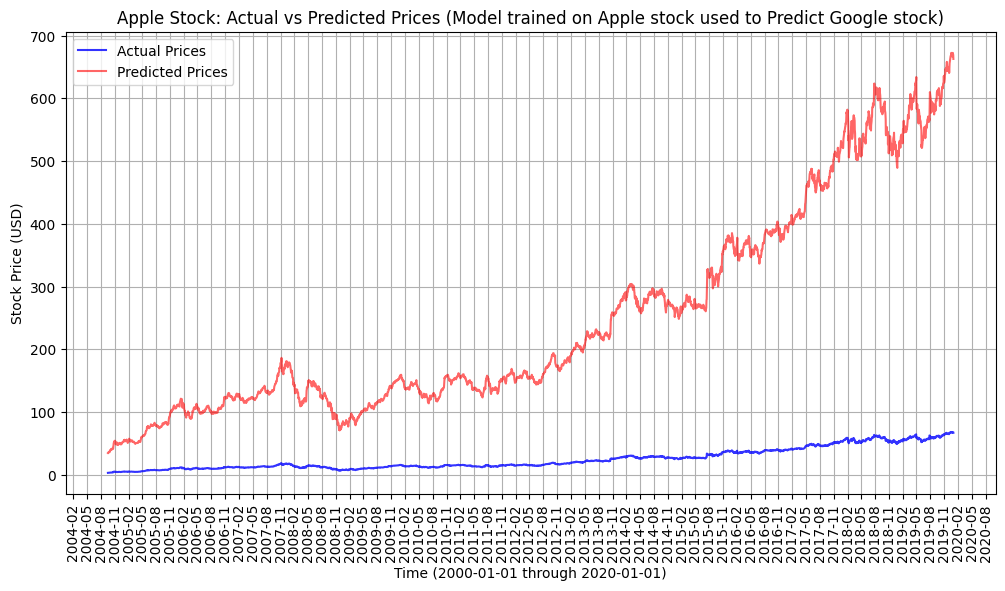

In [ ]:
# visualize model predictions vs actual stock closing prices

plt.figure(figsize=(12, 6))

# plot ground truth prices
plt.plot(data.index, data['Close'], label='Actual Prices', color='blue', alpha=0.8)

# plot predicted prices
plt.plot(data.index[-len(y_pred):], y_pred, label='Predicted Prices', color='red', alpha=0.6)

# formatting plot to account for dates format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # adjust this interval if we need
plt.xticks(rotation=90)

plt.xlabel('Time (2000-01-01 through 2020-01-01)')
plt.ylabel('Stock Price (USD)')
plt.title('Apple Stock: Actual vs Predicted Prices (Model trained on Apple stock used to Predict Google stock)')
plt.legend()

plt.grid(True)
plt.show()


Using the model trained on Apple stock (technology industry) and to predict NVDA stock (technology industry)




In [ ]:
# downloading stock data

stock_name = "NVDA"
# YYYY-MM-DD
start_date = "2000-01-01"
end_date = "2020-01-01"

data = yf.download(stock_name, start=start_date, end=end_date)
print()
print(data.head())
print(data.shape)


[*********************100%***********************]  1 of 1 completed


Price      Adj Close     Close      High       Low      Open     Volume
Ticker          NVDA      NVDA      NVDA      NVDA      NVDA       NVDA
Date                                                                   
2000-01-03  0.089440  0.097526  0.099219  0.091927  0.098438  300912000
2000-01-04  0.087052  0.094922  0.096094  0.090104  0.095833  300480000
2000-01-05  0.084186  0.091797  0.093750  0.090495  0.092188  188352000
2000-01-06  0.078692  0.085807  0.091797  0.082292  0.091797  120480000
2000-01-07  0.080007  0.087240  0.088151  0.084115  0.085417   71184000
(5031, 6)


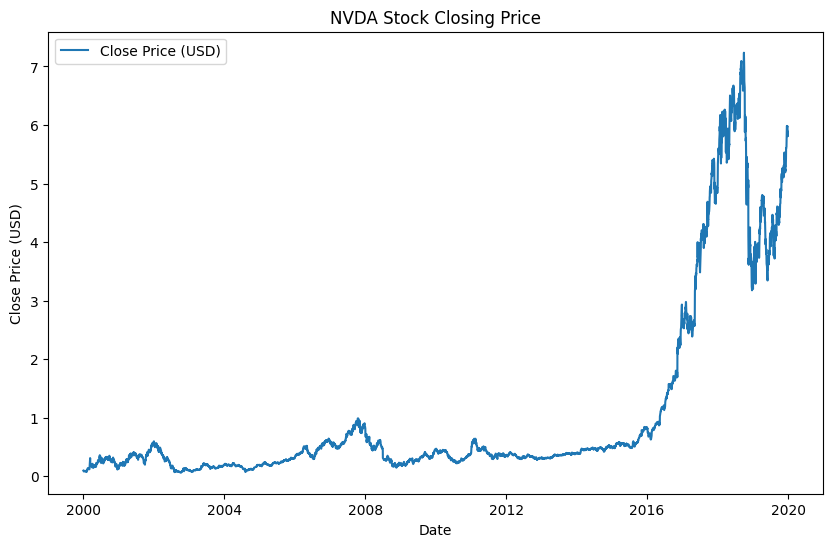

In [ ]:
# visualize data we loaded in
# plot closing price
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price (USD)')
plt.title('NVDA Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

In [ ]:
# feature engineering

# using 7-day and 21-day Moving Averages
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()

print(data.head)

# feature engineering: lagging values of closing price
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

print(data.head)

<bound method NDFrame.head of Price      Adj Close     Close      High       Low      Open     Volume  \
Ticker          NVDA      NVDA      NVDA      NVDA      NVDA       NVDA   
Date                                                                      
2000-01-03  0.089440  0.097526  0.099219  0.091927  0.098438  300912000   
2000-01-04  0.087052  0.094922  0.096094  0.090104  0.095833  300480000   
2000-01-05  0.084186  0.091797  0.093750  0.090495  0.092188  188352000   
2000-01-06  0.078692  0.085807  0.091797  0.082292  0.091797  120480000   
2000-01-07  0.080007  0.087240  0.088151  0.084115  0.085417   71184000   
...              ...       ...       ...       ...       ...        ...   
2019-12-24  5.940596  5.965500  5.982750  5.920500  5.955000  138864000   
2019-12-26  5.954786  5.979750  6.008000  5.950000  5.969000  182852000   
2019-12-27  5.897027  5.921750  6.008500  5.895250  5.995000  254644000   
2019-12-30  5.783753  5.808000  5.905000  5.776500  5.899750  25805600

In [ ]:
# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X_nvda = data[['Lag_1', '7_MA']]
y_nvda = data['Close']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order


In [ ]:
# feature engineering

# using 7-day and 21-day Moving Averages
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()

# feature engineering: lagging values of closing price
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X = data[['7_MA', '21_MA', 'Lag_1', 'Lag_2', 'Volume']]
y = data['Close']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order

# feature scalings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Evaluate the previously trained model from Apple to new stock, GOOG
y_pred = mlp_model.predict(X_nvda).flatten()

# Calculate error metrics
mse = mean_squared_error(y_nvda, y_pred)
mae = mean_absolute_error(y_nvda, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 481.2389590100721
Mean Absolute Error (MAE): 17.24226981276846


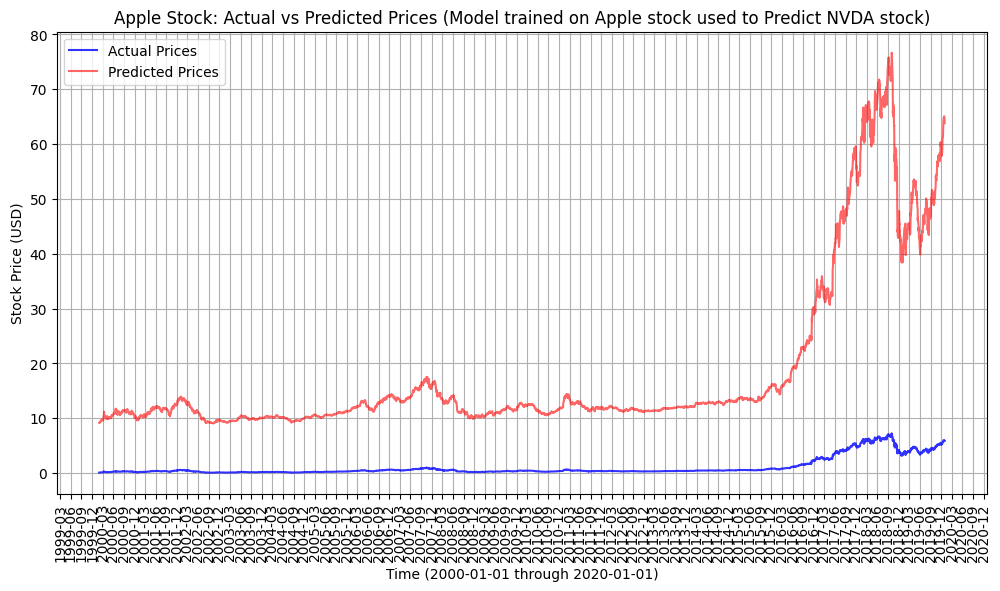

In [ ]:
# visualize model predictions vs actual stock closing prices

plt.figure(figsize=(12, 6))

# plot ground truth prices
plt.plot(data.index, data['Close'], label='Actual Prices', color='blue', alpha=0.8)

# plot predicted prices
plt.plot(data.index[-len(y_pred):], y_pred, label='Predicted Prices', color='red', alpha=0.6)

# formatting plot to account for dates format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # adjust this interval if we need
plt.xticks(rotation=90)

plt.xlabel('Time (2000-01-01 through 2020-01-01)')
plt.ylabel('Stock Price (USD)')
plt.title('Apple Stock: Actual vs Predicted Prices (Model trained on Apple stock used to Predict NVDA stock)')
plt.legend()

plt.grid(True)
plt.show()


Using the model trained on Apple stock (technology industry) and to predict ADM stock (food industry)




In [ ]:
# downloading stock data

stock_name = "ADM"
# YYYY-MM-DD
start_date = "2000-01-01"
end_date = "2020-01-01"

data = yf.download(stock_name, start=start_date, end=end_date)
print()
print(data.head())
print(data.shape)


[*********************100%***********************]  1 of 1 completed


Price      Adj Close      Close       High        Low       Open   Volume
Ticker           ADM        ADM        ADM        ADM        ADM      ADM
Date                                                                     
2000-01-03  6.248419  10.884354  10.941043  10.770975  10.884354   984753
2000-01-04  6.183335  10.770975  11.054422  10.714286  10.714286  1088057
2000-01-05  6.085704  10.600907  10.770975  10.544218  10.770975  1087947
2000-01-06  6.118245  10.657596  10.770975  10.487528  10.544218   899971
2000-01-07  6.215878  10.827664  10.884354  10.714286  10.770975  1186290
(5031, 6)


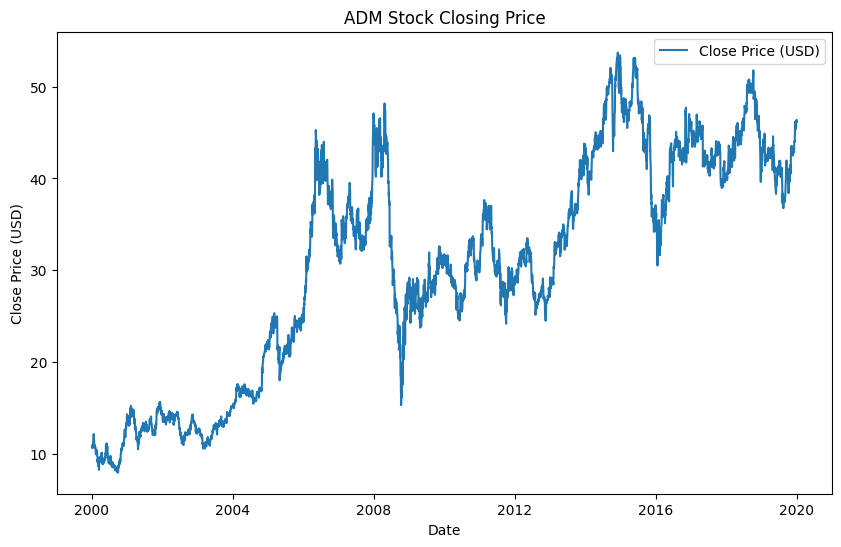

In [ ]:
# visualize data we loaded in
# plot closing price
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price (USD)')
plt.title('ADM Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

In [ ]:
# feature engineering

# using 7-day and 21-day Moving Averages
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()

print(data.head)

# feature engineering: lagging values of closing price
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

print(data.head)

<bound method NDFrame.head of Price       Adj Close      Close       High        Low       Open   Volume  \
Ticker            ADM        ADM        ADM        ADM        ADM      ADM   
Date                                                                         
2000-01-03   6.248419  10.884354  10.941043  10.770975  10.884354   984753   
2000-01-04   6.183335  10.770975  11.054422  10.714286  10.714286  1088057   
2000-01-05   6.085704  10.600907  10.770975  10.544218  10.770975  1087947   
2000-01-06   6.118245  10.657596  10.770975  10.487528  10.544218   899971   
2000-01-07   6.215878  10.827664  10.884354  10.714286  10.770975  1186290   
...               ...        ...        ...        ...        ...      ...   
2019-12-24  40.287457  46.080002  46.270000  46.009998  46.250000   708300   
2019-12-26  40.392372  46.200001  46.380001  45.950001  46.029999   985100   
2019-12-27  40.479797  46.299999  46.400002  46.110001  46.380001  1355000   
2019-12-30  40.322422  46.119999  

In [ ]:
# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X_adm = data[['Lag_1', '7_MA']]
y_adm = data['Close']


# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order


In [ ]:
# feature engineering

# using 7-day and 21-day Moving Averages
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()

# feature engineering: lagging values of closing price
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X = data[['7_MA', '21_MA', 'Lag_1', 'Lag_2', 'Volume']]
y = data['Close']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order

# scaling our features here
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
X_goog.shape

(0, 2)

In [ ]:
# Evaluate the previously trained model from Apple to new stock, ADM
y_pred = mlp_model.predict(X_adm).flatten()

# Calculate error metrics
mse = mean_squared_error(y_adm, y_pred)
mae = mean_absolute_error(y_adm, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Mean Squared Error (MSE): 87714.49943855987
Mean Absolute Error (MAE): 275.91621841172974


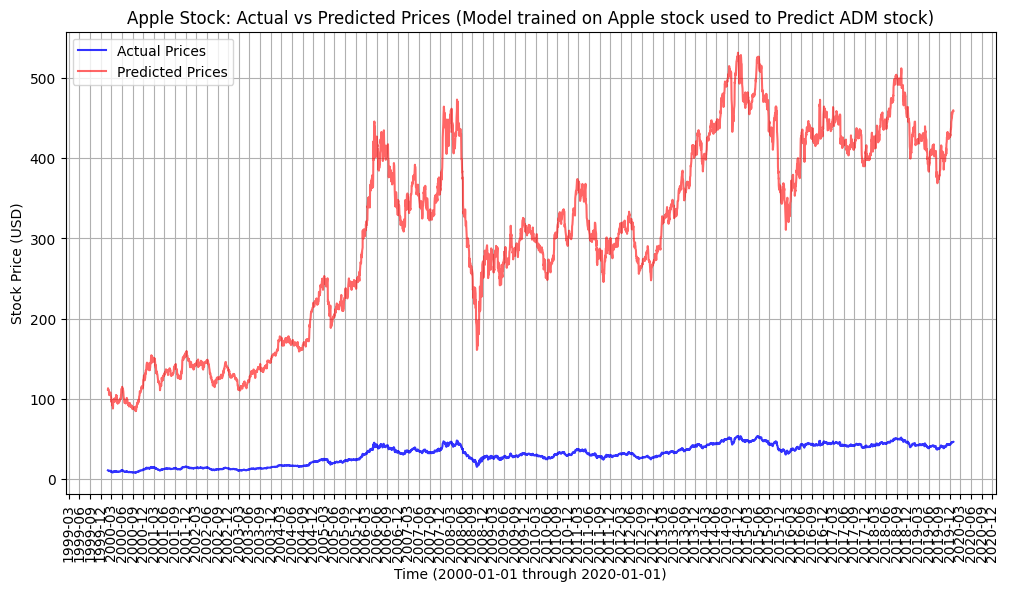

In [ ]:
# visualize model predictions vs actual stock closing prices

plt.figure(figsize=(12, 6))

# plot ground truth prices
plt.plot(data.index, data['Close'], label='Actual Prices', color='blue', alpha=0.8)

# plot predicted prices
plt.plot(data.index[-len(y_pred):], y_pred, label='Predicted Prices', color='red', alpha=0.6)

# formatting plot to account for dates format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # adjust this interval if we need
plt.xticks(rotation=90)

plt.xlabel('Time (2000-01-01 through 2020-01-01)')
plt.ylabel('Stock Price (USD)')
plt.title('Apple Stock: Actual vs Predicted Prices (Model trained on Apple stock used to Predict ADM stock)')
plt.legend()

plt.grid(True)
plt.show()


Using the model trained on Apple stock (technology industry) and to predict GIS stock (food industry)




In [ ]:
# downloading stock data

stock_name = "GIS"
# YYYY-MM-DD
start_date = "2000-01-01"
end_date = "2020-01-01"

data = yf.download(stock_name, start=start_date, end=end_date)
print()
print(data.head())
print(data.shape)


[*********************100%***********************]  1 of 1 completed


Price      Adj Close     Close      High       Low      Open   Volume
Ticker           GIS       GIS       GIS       GIS       GIS      GIS
Date                                                                 
2000-01-03  8.111927  17.21875  17.75000  17.03125  17.68750  2078200
2000-01-04  7.964708  16.90625  17.21875  16.78125  17.03125  1546800
2000-01-05  7.920538  16.81250  17.09375  16.59375  16.59375  2018800
2000-01-06  7.971004  16.78125  17.00000  16.46875  16.78125  3292600
2000-01-07  7.985846  16.81250  17.28125  16.75000  17.21875  4529000
(5031, 6)


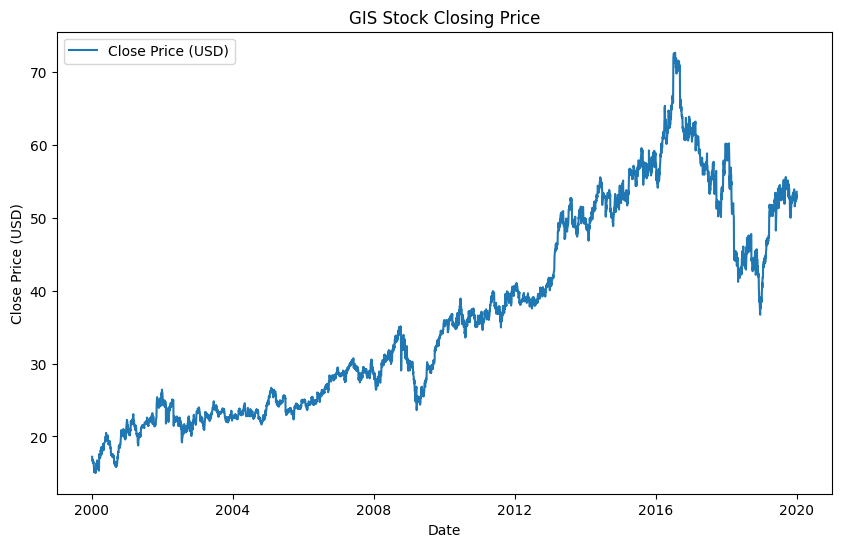

In [ ]:
# visualize data we loaded in
# plot closing price
plt.figure(figsize=(10, 6))
plt.plot(data['Close'], label='Close Price (USD)')
plt.title('GIS Stock Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price (USD)')
plt.legend()
plt.show()

In [ ]:
# feature engineering

# using 7-day and 21-day Moving Averages
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()

print(data.head)

# feature engineering: lagging values of closing price
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

print(data.head)

<bound method NDFrame.head of Price       Adj Close      Close       High        Low       Open   Volume  \
Ticker            GIS        GIS        GIS        GIS        GIS      GIS   
Date                                                                         
2000-01-03   8.111927  17.218750  17.750000  17.031250  17.687500  2078200   
2000-01-04   7.964708  16.906250  17.218750  16.781250  17.031250  1546800   
2000-01-05   7.920538  16.812500  17.093750  16.593750  16.593750  2018800   
2000-01-06   7.971004  16.781250  17.000000  16.468750  16.781250  3292600   
2000-01-07   7.985846  16.812500  17.281250  16.750000  17.218750  4529000   
...               ...        ...        ...        ...        ...      ...   
2019-12-24  45.047890  52.980000  52.980000  52.730000  52.820000   811200   
2019-12-26  44.571735  52.419998  53.049999  52.250000  52.980000  2843600   
2019-12-27  45.226448  53.189999  53.189999  52.459999  52.560001  2017400   
2019-12-30  44.843826  52.740002  

In [ ]:
# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X_gis = data[['Lag_1', '7_MA']]
y_gis = data['Close']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order


In [ ]:
# feature engineering

# using 7-day and 21-day Moving Averages
data['7_MA'] = data['Close'].rolling(window=7).mean()
data['21_MA'] = data['Close'].rolling(window=21).mean()

# feature engineering: lagging values of closing price
data['Lag_1'] = data['Close'].shift(1)
data['Lag_2'] = data['Close'].shift(2)

# drop rows with NaN values after feature creation
# create our train test split
data = data.dropna()

X = data[['7_MA', '21_MA', 'Lag_1', 'Lag_2', 'Volume']]
y = data['Close']

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)    # shuffle=False because we want to keep time series data in order

# feature scalings
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [ ]:
# Evaluate the previously trained model from Apple to new stock, GOOG
y_pred = mlp_model.predict(X_gis).flatten()

# Calculate error metrics
mse = mean_squared_error(y_gis, y_pred)
mae = mean_absolute_error(y_gis, y_pred)

print(f"Mean Squared Error (MSE): {mse}")
print(f"Mean Absolute Error (MAE): {mae}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE): 124301.7595811832
Mean Absolute Error (MAE): 330.9713993685328


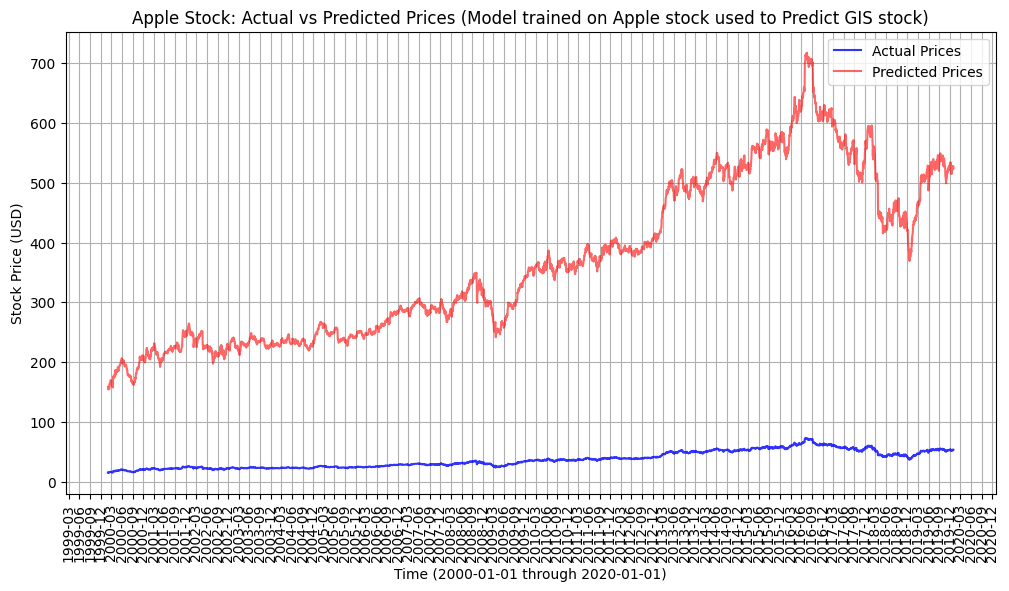

In [ ]:
# visualize model predictions vs actual stock closing prices

plt.figure(figsize=(12, 6))

# plot ground truth prices
plt.plot(data.index, data['Close'], label='Actual Prices', color='blue', alpha=0.8)

# plot predicted prices
plt.plot(data.index[-len(y_pred):], y_pred, label='Predicted Prices', color='red', alpha=0.6)

# formatting plot to account for dates format
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # adjust this interval if we need
plt.xticks(rotation=90)

plt.xlabel('Time (2000-01-01 through 2020-01-01)')
plt.ylabel('Stock Price (USD)')
plt.title('Apple Stock: Actual vs Predicted Prices (Model trained on Apple stock used to Predict GIS stock)')
plt.legend()

plt.grid(True)
plt.show()


In [ ]:
# Predictions

predictions_list = []

pred_input = data[tickers[ticker_set][single_index] + '-Close']
pred_input = list(pred_input.dropna().to_numpy())
pred_input = pred_input[:-100]
pred_input.insert(0, 0)
pred_input.pop()

print(pred_input)

model_stock.eval()

with torch.no_grad():
    predictions_stock_train = model_stock(X_stock.unsqueeze(2)).squeeze(2).numpy()
    print('Predicted output:', predictions_stock_train)

for i in range(100):
  with torch.no_grad():
      pred_input_tensor = torch.tensor([pred_input], dtype=torch.float32)
      # print(pred_input)
      predictions_stock = model_stock(pred_input_tensor.unsqueeze(2)).squeeze(2).numpy()
      # print('Predicted output:', predictions_stock)
      predictions_list.append(predictions_stock[0][-1])
      pred_input = pred_input[1:]
      pred_input.append(next_day_true_price[i])

[0, 40.585147857666016, 40.881141662597656, 41.22514724731445, 40.95314407348633, 40.88915252685547, 41.34516525268555, 41.54517364501953, 41.657169342041016, 41.95317840576172, 42.729209899902344, 44.24125289916992, 44.12923812866211, 44.473262786865234, 44.48125076293945, 44.121238708496094, 43.29722595214844, 43.30521011352539, 43.38521957397461, 43.129215240478516, 42.61720275878906, 43.20921325683594, 42.12918472290039, 42.481197357177734, 42.177188873291016, 42.177188873291016, 42.56919479370117, 43.17721939086914, 43.60922622680664, 43.04412841796875, 43.17329406738281, 43.75453567504883, 44.602176666259766, 46.894859313964844, 46.86256790161133, 46.7899169921875, 46.84642791748047, 47.20969009399414, 47.355003356933594, 48.065406799316406, 48.121917724609375, 47.65369415283203, 48.31566619873047, 47.97661590576172, 47.40343475341797, 47.298500061035156, 47.548770904541016, 47.169342041015625, 47.790924072265625, 47.0966796875, 47.5245361328125, 47.5245361328125, 47.952384948730

In [ ]:
next_day_predicted_price = predictions_list[0]
print(next_day_predicted_price)
print(next_day_true_price[0])
print(predictions_list)
print(next_day_true_price)

103.21956
105.43152618408203
[103.21956, 105.040184, 105.12199, 106.42273, 103.08334, 102.58785, 103.03149, 104.67823, 103.66477, 103.61553, 103.810326, 102.26638, 103.92599, 103.44877, 103.30071, 104.32949, 104.98771, 105.70152, 105.129654, 106.0041, 105.84022, 103.51261, 103.399574, 104.048096, 103.9314, 103.373024, 102.72176, 103.477905, 104.87023, 106.16805, 107.50743, 106.12639, 105.01213, 103.667564, 104.08877, 104.74062, 104.28667, 103.42391, 100.639565, 100.63709, 101.2489, 101.0413, 100.54212, 100.53619, 100.26628, 101.29581, 101.11643, 102.403305, 101.27474, 101.40572, 101.59878, 101.08491, 102.50149, 100.92594, 100.944145, 102.77509, 105.191475, 104.23688, 104.49125, 105.54153, 104.55444, 104.81742, 103.569725, 105.48199, 105.13584, 105.32583, 104.76082, 104.96906, 104.821785, 104.203865, 105.6016, 106.5847, 107.34234, 106.9374, 106.85941, 107.99338, 109.363945, 109.6702, 109.88473, 109.74066, 109.23153, 109.751945, 111.08261, 112.66137, 113.50903, 114.013115, 114.02356, 113

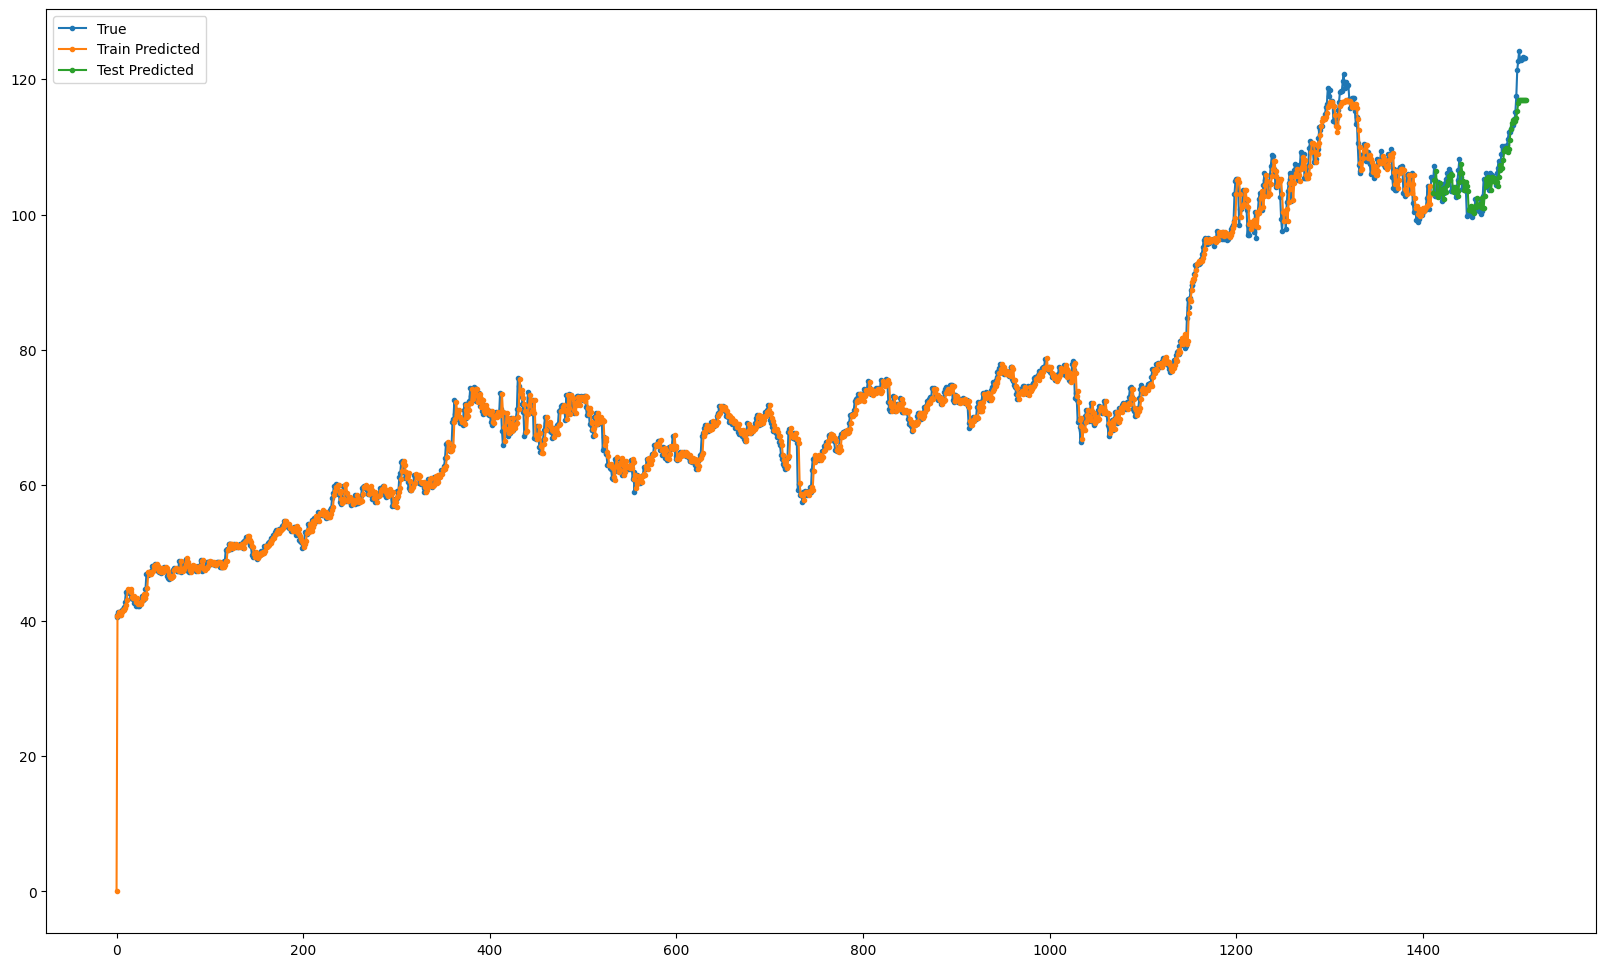

[ 40.585148  40.88114   41.225147 ... 103.23522  102.97577  105.61688 ]
[ 77.83177   89.322365  63.330513 ... 116.93645  116.94337  116.939644]
[  0.          40.70326996  40.86952209 ... 101.50641632 103.05835724
 103.21955872]
[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

In [ ]:
placeholder = np.array([0])
predictions_stock_plot = np.append(placeholder, predictions_stock_train[0])

predictions_future = []
for item in predictions_stock_plot:
  predictions_future.append(np.NaN)
predictions_future.extend(predictions_list)

X_stock_review = data[tickers[ticker_set][single_index] + '-Close']
X_stock_review = list(X_stock_review.dropna().to_numpy())

# Plot results
plt.figure(figsize=(20, 12))
plt.plot(X_stock_review, label='True', marker='.')
plt.plot(predictions_stock_plot, label='Train Predicted', marker='.')
plt.plot(predictions_future, label='Test Predicted', marker='.')
plt.legend()
plt.show()

print(y_stock[0].numpy())
print(predictions_stock[0])
print(predictions_stock_plot)
print(predictions_future)
print(next_day_true_price)

In [ ]:
from sklearn.metrics import mean_squared_error
print('True:', next_day_true_price)
print('Predicted:', predictions_list)
print('MSE Loss:', mean_squared_error(next_day_true_price, predictions_list))

True: [105.43152618408203, 105.27399444580078, 107.2200698852539, 102.7795639038086, 102.7236557006836, 102.99388885498047, 104.86703491210938, 103.45052337646484, 103.869873046875, 104.0096664428711, 102.05268096923828, 104.16807556152344, 103.18959045410156, 103.41324615478516, 104.60609436035156, 105.27705383300781, 106.19963836669922, 105.53800201416016, 106.79606628417969, 106.28350830078125, 103.50643157958984, 103.53440856933594, 104.08419799804688, 103.87920379638672, 103.33869171142578, 102.63044738769531, 103.55305480957031, 105.04408264160156, 106.56306457519531, 108.24981689453125, 106.40465545654297, 105.53800201416016, 103.80467224121094, 104.20536041259766, 104.7179183959961, 104.21468353271484, 103.40393829345703, 99.71359252929688, 99.98384094238281, 100.83186340332031, 100.4870834350586, 99.8906478881836, 99.9931640625, 99.63905334472656, 100.98098754882812, 100.55231475830078, 102.22975158691406, 100.59890747070312, 101.07417297363281, 101.2419204711914, 100.56164550

## Predicting other stocks in the Healthcare Industry using pretrained Healthcare Industry models

## Making Predictions on ABBV using LLY Model

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


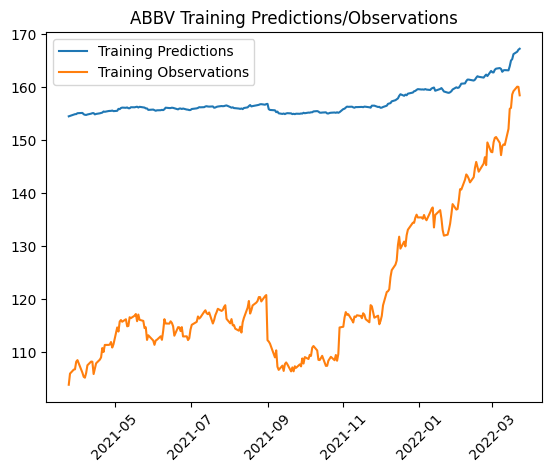

In [ ]:
data_ABBV = np.concatenate([train_data_ABBV['X'], val_data_ABBV['X'], test_data_ABBV['X']], axis=0)
dates_ABBV = np.concatenate([train_data_ABBV['dates'], val_data_ABBV['dates'], test_data_ABBV['dates']], axis=0)
observations_ABBV = np.concatenate([train_data_ABBV['y'], val_data_ABBV['y'], test_data_ABBV['y']], axis=0)

predictions_ABBV = model_LLY.predict(data_ABBV).flatten()

plt.plot(dates_ABBV, predictions_ABBV)
plt.plot(dates_ABBV, observations_ABBV)
plt.xticks(rotation=45)
plt.title("ABBV Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

ABBV_LLYModel_MAE = calculate_mae(observations_ABBV, predictions_ABBV)

## Making Predictions on ABBV using MRK Model




8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step


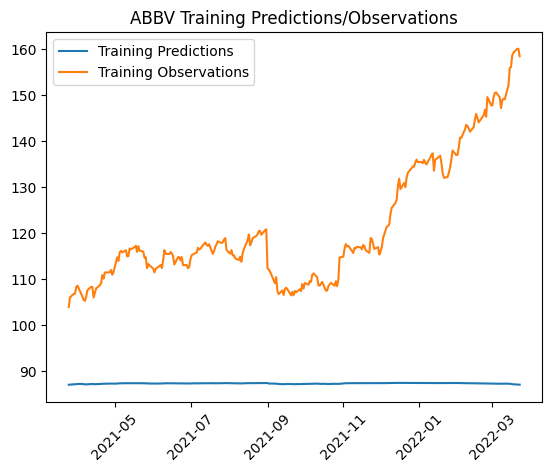

In [ ]:
data_ABBV = np.concatenate([train_data_ABBV['X'], val_data_ABBV['X'], test_data_ABBV['X']], axis=0)
dates_ABBV = np.concatenate([train_data_ABBV['dates'], val_data_ABBV['dates'], test_data_ABBV['dates']], axis=0)
observations_ABBV = np.concatenate([train_data_ABBV['y'], val_data_ABBV['y'], test_data_ABBV['y']], axis=0)

predictions_ABBV = model_MRK.predict(data_ABBV).flatten()

plt.plot(dates_ABBV, predictions_ABBV)
plt.plot(dates_ABBV, observations_ABBV)
plt.xticks(rotation=45)
plt.title("ABBV Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

ABBV_ABBVModel_MAE = calculate_mae(observations_ABBV, predictions_ABBV)

## Making Predictions on LLY using ABBV Model

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


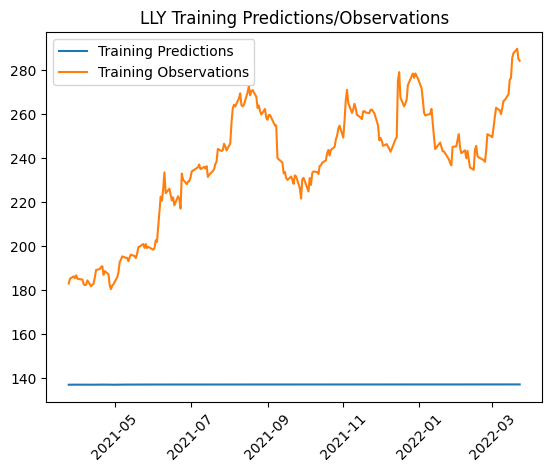

In [ ]:
data_LLY = np.concatenate([train_data_LLY['X'], val_data_LLY['X'], test_data_LLY['X']], axis=0)
dates_LLY = np.concatenate([train_data_LLY['dates'], val_data_LLY['dates'], test_data_LLY['dates']], axis=0)
observations_LLY = np.concatenate([train_data_LLY['y'], val_data_LLY['y'], test_data_LLY['y']], axis=0)

predictions_LLY = model_ABBV.predict(data_LLY).flatten()

plt.plot(dates_LLY, predictions_LLY)
plt.plot(dates_LLY, observations_LLY)
plt.xticks(rotation=45)
plt.title("LLY Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

LLY_LLYModel_MAE = calculate_mae(observations_LLY, predictions_LLY)

## Making Predictions on LLY using MRK Model




8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


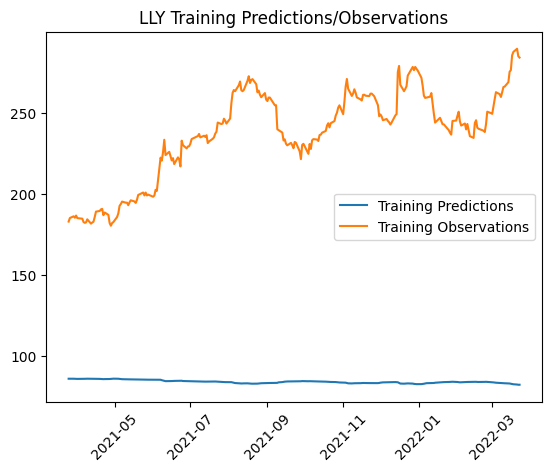

In [ ]:
data_LLY = np.concatenate([train_data_LLY['X'], val_data_LLY['X'], test_data_LLY['X']], axis=0)
dates_LLY = np.concatenate([train_data_LLY['dates'], val_data_LLY['dates'], test_data_LLY['dates']], axis=0)
observations_LLY = np.concatenate([train_data_LLY['y'], val_data_LLY['y'], test_data_LLY['y']], axis=0)

predictions_LLY = model_MRK.predict(data_LLY).flatten()

plt.plot(dates_LLY, predictions_LLY)
plt.plot(dates_LLY, observations_LLY)
plt.xticks(rotation=45)
plt.title("LLY Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

LLY_LLYModel_MAE = calculate_mae(observations_LLY, predictions_LLY)

## Making Predictions on MRK using ABBV Model

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


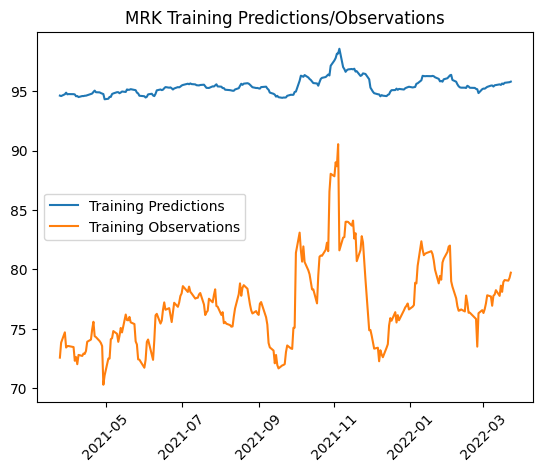

In [ ]:
data_MRK = np.concatenate([train_data_MRK['X'], val_data_MRK['X'], test_data_MRK['X']], axis=0)
dates_MRK = np.concatenate([train_data_MRK['dates'], val_data_MRK['dates'], test_data_MRK['dates']], axis=0)
observations_MRK = np.concatenate([train_data_MRK['y'], val_data_MRK['y'], test_data_MRK['y']], axis=0)

predictions_MRK = model_ABBV.predict(data_MRK).flatten()

plt.plot(dates_MRK, predictions_MRK)
plt.plot(dates_MRK, observations_MRK)
plt.xticks(rotation=45)
plt.title("MRK Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

MRK_MRKModel_MAE = calculate_mae(observations_MRK, predictions_MRK)

## Making Predictions on MRK using LLY Model






8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


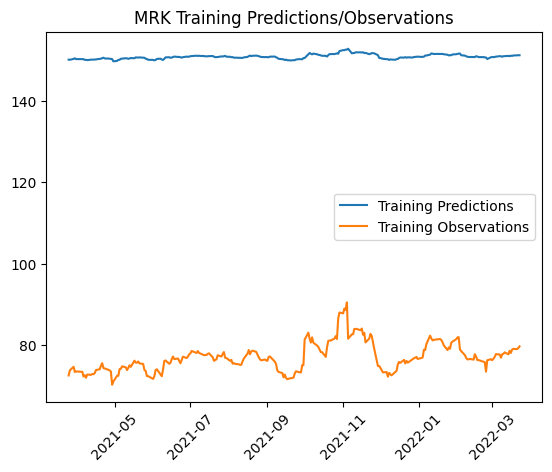

In [ ]:
data_MRK = np.concatenate([train_data_MRK['X'], val_data_MRK['X'], test_data_MRK['X']], axis=0)
dates_MRK = np.concatenate([train_data_MRK['dates'], val_data_MRK['dates'], test_data_MRK['dates']], axis=0)
observations_MRK = np.concatenate([train_data_MRK['y'], val_data_MRK['y'], test_data_MRK['y']], axis=0)

predictions_MRK = model_LLY.predict(data_MRK).flatten()

plt.plot(dates_MRK, predictions_MRK)
plt.plot(dates_MRK, observations_MRK)
plt.xticks(rotation=45)
plt.title("MRK Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

MRK_MRKModel_MAE = calculate_mae(observations_MRK, predictions_MRK)

## Predicting stocks in the Construction Industry using pretrained Healthcare Industry models

## Making Predictions on TT using LLY Model

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


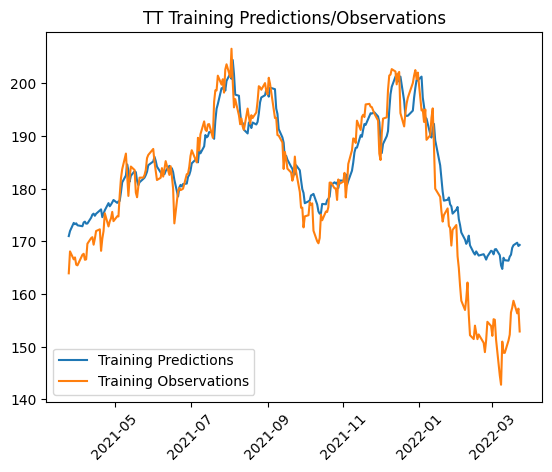

In [ ]:
data_TT = np.concatenate([train_data_TT['X'], val_data_TT['X'], test_data_TT['X']], axis=0)
dates_TT = np.concatenate([train_data_TT['dates'], val_data_TT['dates'], test_data_TT['dates']], axis=0)
observations_TT = np.concatenate([train_data_TT['y'], val_data_TT['y'], test_data_TT['y']], axis=0)

predictions_TT = model_LLY.predict(data_TT).flatten()

plt.plot(dates_TT, predictions_TT)
plt.plot(dates_TT, observations_TT)
plt.xticks(rotation=45)
plt.title("TT Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

TT_LLYModel_MAE = calculate_mae(observations_TT, predictions_TT)

## Making Predictions on TT using ABBV Model




8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


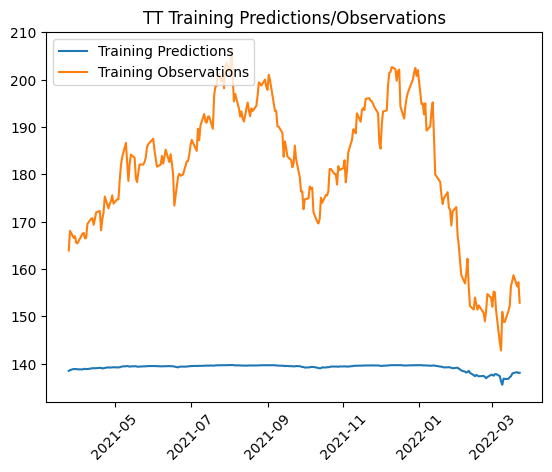

In [ ]:
data_TT = np.concatenate([train_data_TT['X'], val_data_TT['X'], test_data_TT['X']], axis=0)
dates_TT = np.concatenate([train_data_TT['dates'], val_data_TT['dates'], test_data_TT['dates']], axis=0)
observations_TT = np.concatenate([train_data_TT['y'], val_data_TT['y'], test_data_TT['y']], axis=0)

predictions_TT = model_ABBV.predict(data_TT).flatten()

plt.plot(dates_TT, predictions_TT)
plt.plot(dates_TT, observations_TT)
plt.xticks(rotation=45)
plt.title("TT Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

TT_ABBVModel_MAE = calculate_mae(observations_TT, predictions_TT)

## Making Predictions on TT using MRK Model

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


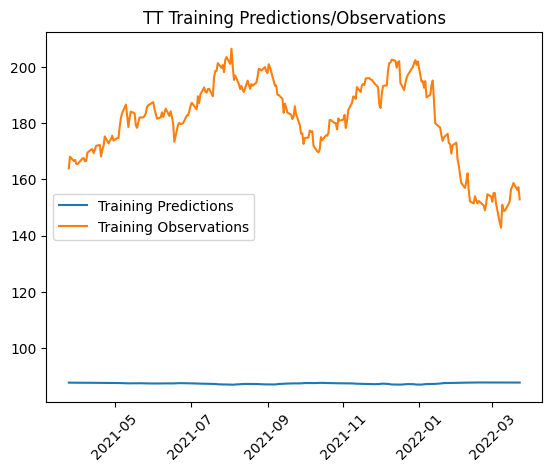

In [ ]:
data_TT = np.concatenate([train_data_TT['X'], val_data_TT['X'], test_data_TT['X']], axis=0)
dates_TT = np.concatenate([train_data_TT['dates'], val_data_TT['dates'], test_data_TT['dates']], axis=0)
observations_TT = np.concatenate([train_data_TT['y'], val_data_TT['y'], test_data_TT['y']], axis=0)

predictions_TT = model_MRK.predict(data_TT).flatten()

plt.plot(dates_TT, predictions_TT)
plt.plot(dates_TT, observations_TT)
plt.xticks(rotation=45)
plt.title("TT Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

TT_MRKModel_MAE = calculate_mae(observations_TT, predictions_TT)

## Making Predictions on CRH using LLY Model

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


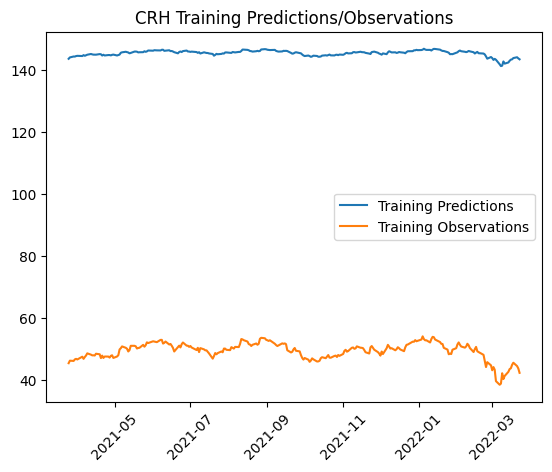

In [ ]:
data_CRH = np.concatenate([train_data_CRH['X'], val_data_CRH['X'], test_data_CRH['X']], axis=0)
dates_CRH = np.concatenate([train_data_CRH['dates'], val_data_CRH['dates'], test_data_CRH['dates']], axis=0)
observations_CRH = np.concatenate([train_data_CRH['y'], val_data_CRH['y'], test_data_CRH['y']], axis=0)

predictions_CRH = model_LLY.predict(data_CRH).flatten()

plt.plot(dates_CRH, predictions_CRH)
plt.plot(dates_CRH, observations_CRH)
plt.xticks(rotation=45)
plt.title("CRH Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

CRH_LLYModel_MAE = calculate_mae(observations_CRH, predictions_CRH)

## Making Predictions on CRH using ABBV Model




8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


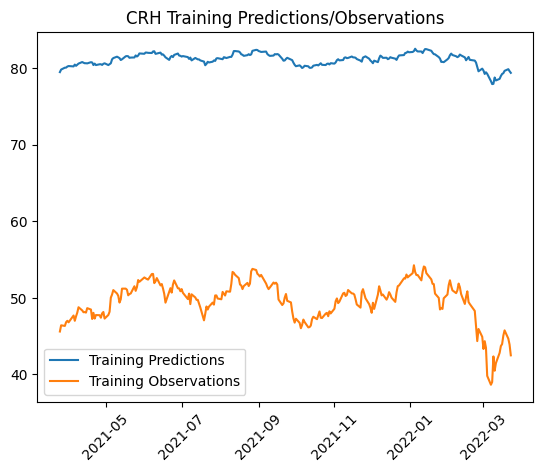

In [ ]:
data_CRH = np.concatenate([train_data_CRH['X'], val_data_CRH['X'], test_data_CRH['X']], axis=0)
dates_CRH = np.concatenate([train_data_CRH['dates'], val_data_CRH['dates'], test_data_CRH['dates']], axis=0)
observations_CRH = np.concatenate([train_data_CRH['y'], val_data_CRH['y'], test_data_CRH['y']], axis=0)

predictions_CRH = model_ABBV.predict(data_CRH).flatten()

plt.plot(dates_CRH, predictions_CRH)
plt.plot(dates_CRH, observations_CRH)
plt.xticks(rotation=45)
plt.title("CRH Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

CRH_ABBVModel_MAE = calculate_mae(observations_CRH, predictions_CRH)

## Making Predictions on CRH using MRK Model

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


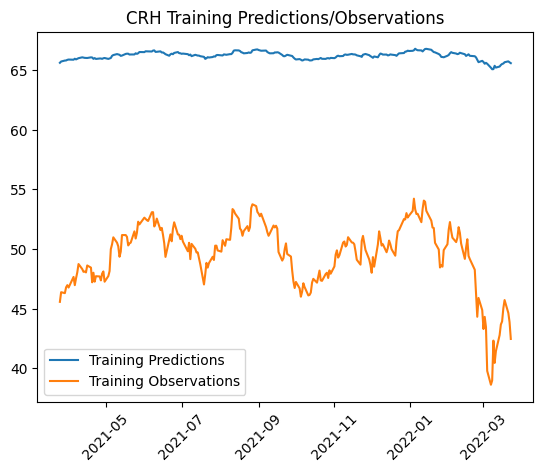

In [ ]:
data_CRH = np.concatenate([train_data_CRH['X'], val_data_CRH['X'], test_data_CRH['X']], axis=0)
dates_CRH = np.concatenate([train_data_CRH['dates'], val_data_CRH['dates'], test_data_CRH['dates']], axis=0)
observations_CRH = np.concatenate([train_data_CRH['y'], val_data_CRH['y'], test_data_CRH['y']], axis=0)

predictions_CRH = model_MRK.predict(data_CRH).flatten()

plt.plot(dates_CRH, predictions_CRH)
plt.plot(dates_CRH, observations_CRH)
plt.xticks(rotation=45)
plt.title("CRH Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

CRH_MRKModel_MAE = calculate_mae(observations_CRH, predictions_CRH)

## Making Predictions on URI using LLY Model

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


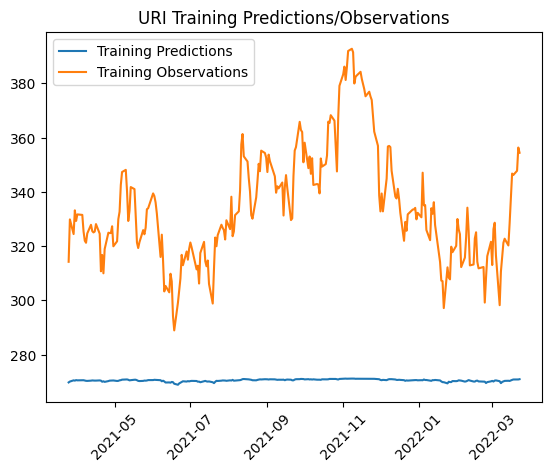

In [ ]:
data_URI = np.concatenate([train_data_URI['X'], val_data_URI['X'], test_data_URI['X']], axis=0)
dates_URI = np.concatenate([train_data_URI['dates'], val_data_URI['dates'], test_data_URI['dates']], axis=0)
observations_URI = np.concatenate([train_data_URI['y'], val_data_URI['y'], test_data_URI['y']], axis=0)

predictions_URI = model_LLY.predict(data_URI).flatten()

plt.plot(dates_URI, predictions_URI)
plt.plot(dates_URI, observations_URI)
plt.xticks(rotation=45)
plt.title("URI Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

URI_LLYModel_MAE = calculate_mae(observations_URI, predictions_URI)

## Making Predictions on URI using ABBV Model




8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


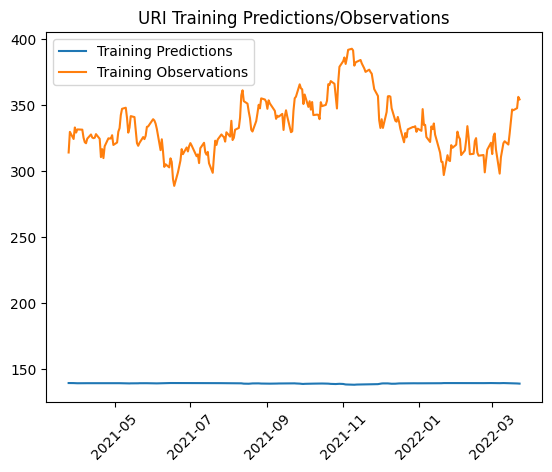

In [ ]:
data_URI = np.concatenate([train_data_URI['X'], val_data_URI['X'], test_data_URI['X']], axis=0)
dates_URI = np.concatenate([train_data_URI['dates'], val_data_URI['dates'], test_data_URI['dates']], axis=0)
observations_URI = np.concatenate([train_data_URI['y'], val_data_URI['y'], test_data_URI['y']], axis=0)

predictions_URI = model_ABBV.predict(data_URI).flatten()

plt.plot(dates_URI, predictions_URI)
plt.plot(dates_URI, observations_URI)
plt.xticks(rotation=45)
plt.title("URI Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

URI_ABBVModel_MAE = calculate_mae(observations_URI, predictions_URI)

## Making Predictions on URI using MRK Model

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


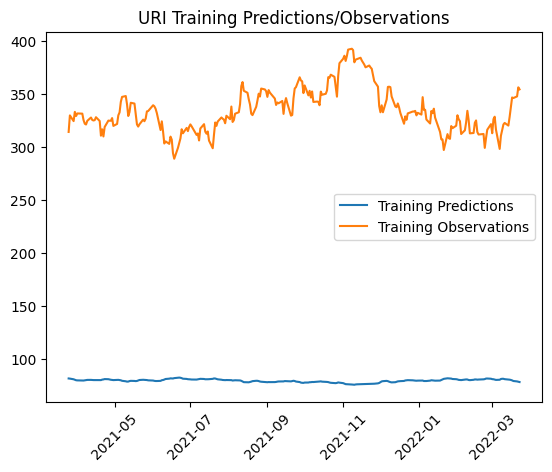

In [ ]:
data_URI = np.concatenate([train_data_URI['X'], val_data_URI['X'], test_data_URI['X']], axis=0)
dates_URI = np.concatenate([train_data_URI['dates'], val_data_URI['dates'], test_data_URI['dates']], axis=0)
observations_URI = np.concatenate([train_data_URI['y'], val_data_URI['y'], test_data_URI['y']], axis=0)

predictions_URI = model_MRK.predict(data_URI).flatten()

plt.plot(dates_URI, predictions_URI)
plt.plot(dates_URI, observations_URI)
plt.xticks(rotation=45)
plt.title("URI Training Predictions/Observations")
plt.legend(['Training Predictions', 'Training Observations'])

URI_MRKModel_MAE = calculate_mae(observations_URI, predictions_URI)

## Healthcare Model's prediction performance on Construction Stocks


In [ ]:
averge_mae_LLY = np.mean([TT_LLYModel_MAE, CRH_LLYModel_MAE, URI_LLYModel_MAE])
averge_mae_MRK = np.mean([TT_MRKModel_MAE, CRH_MRKModel_MAE, URI_MRKModel_MAE])
averge_mae_ABBV = np.mean([TT_ABBVModel_MAE, CRH_ABBVModel_MAE, URI_ABBVModel_MAE])

In [ ]:
averge_mae_LLY

54.910046

In [ ]:
averge_mae_MRK

121.90002

In [ ]:
averge_mae_ABBV

89.553406

## Conclusory Findings

The results suggest that the Lilly (LLY) model's relative success in predicting construction stocks, compared to the ABBV and MRK models, may indicate that the price range and patterns in LLY's training data aligned more closely with those of the construction stock TT. This alignment could have enabled the model to better generalize its learned relationships, allowing it to capture trends or shapes in the new data, even if the industry contexts differ. The inability of the healthcare models to fully predict construction stock behavior highlights the industry-specific nature of stock price movements, driven by distinct market dynamics, economic factors, and industry-specific events. However, the LLY model's performance hints at potential overlaps in broader market trends or pricing structures that can transcend industries under certain conditions, especially when price ranges are similar. This underscores the importance of considering data characteristics, such as price ranges and volatility, when applying machine learning models across different domains.

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step
Training Loss (MSE): 0.001496272161602974
Testing Loss (MSE): 0.0024323591496795416
Mean Squared Error (Test Set): 2.1173090656032216


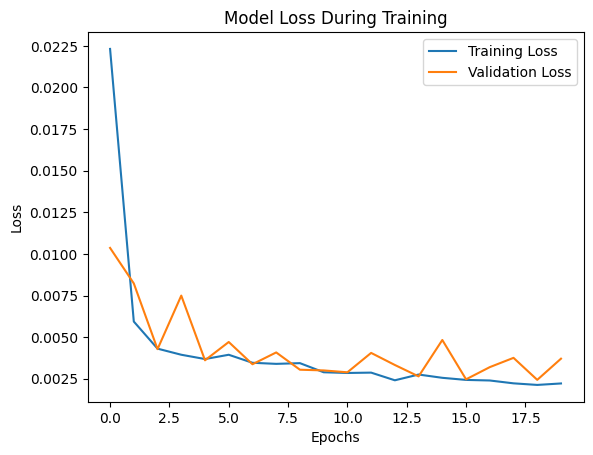

In [ ]:
# Step 7: Evaluate the Model
# Load the best model
model.load_weights(checkpoint_path)
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)

# Predict and calculate MSE
predictions = model.predict(X_test)
y_test_original = scaler.inverse_transform(y_test.reshape(-1, 1))
predictions_original = scaler.inverse_transform(predictions)
mse = mean_squared_error(y_test_original, predictions_original)

# Print metrics
print(f"Training Loss (MSE): {train_loss}")
print(f"Testing Loss (MSE): {test_loss}")
print(f"Mean Squared Error (Test Set): {mse}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


Tested on data from 2015-01-01 to 2018-12-31 for predictions from 2018-12-31 to 2020-01-01
      


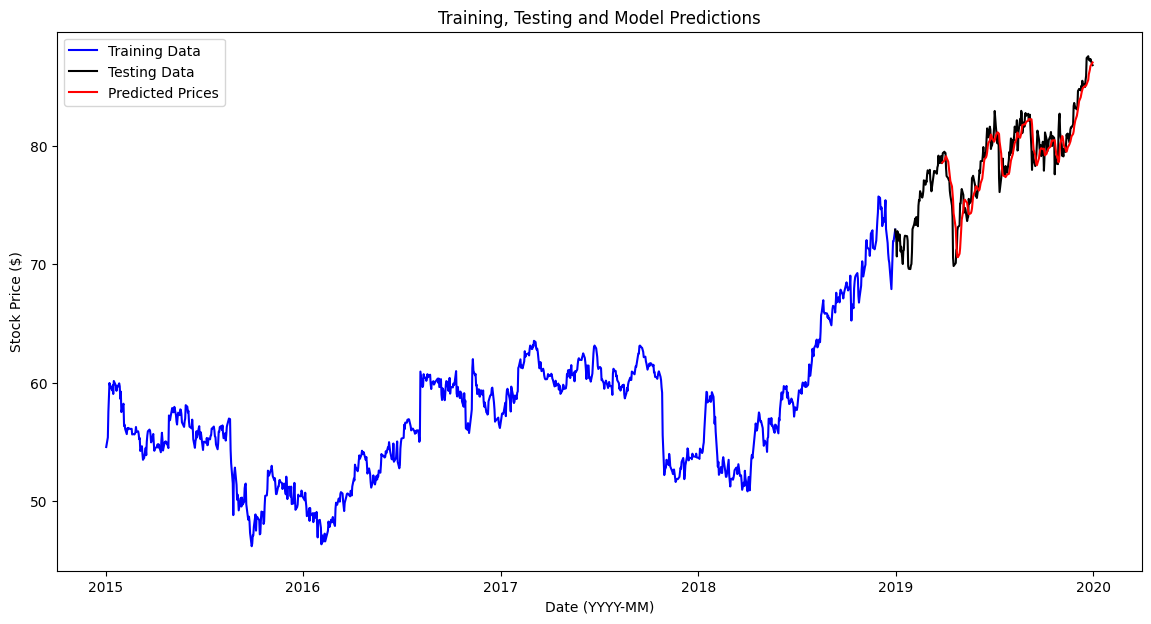

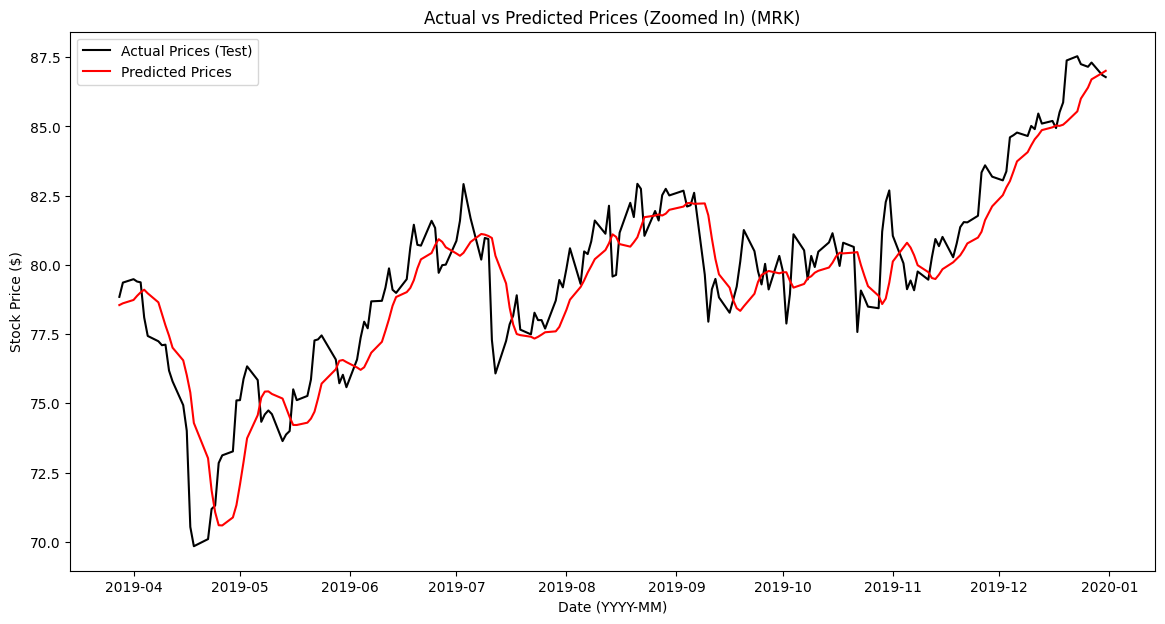

In [ ]:
# Step 8: Predict and Visualize
print(f"""
Tested on data from {start_date} to {train_end_date} for predictions from {train_end_date} to {end_date}
      """)

# Convert training and testing data back to original scale for visualization
train_original = scaler.inverse_transform(scaled_train_data)
test_original = scaler.inverse_transform(scaled_test_data)

# Plot the training and testing data
plt.figure(figsize=(14, 7))
plt.plot(train_data.index, train_original, label="Training Data", color="blue")
plt.plot(test_data.index, test_original, label="Testing Data", color="black")
plt.plot(test_data.index[sequence_length:], predictions_original, label="Predicted Prices", color="red")
plt.title("Training, Testing and Model Predictions")
plt.xlabel("Date (YYYY-MM)")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()

# Overlay predictions on test data
plt.figure(figsize=(14, 7))
plt.plot(test_data.index[sequence_length:], y_test_original, label="Actual Prices (Test)", color="black")
plt.plot(test_data.index[sequence_length:], predictions_original, label="Predicted Prices", color="red")
plt.title(f"Actual vs Predicted Prices (Zoomed In) ({symbol})")
plt.xlabel("Date (YYYY-MM)")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.show()
